In [253]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../Class")
sys.path.append("../utils")

import numpy as np
import matplotlib.pyplot as plt
from loss import MSELoss, LogSoftMaxCrossEntropy, BCELoss
from transformations import TanH, SoftMax, ReLU 
from encapsulage import Sequential, Optim
from AutoEncoder import AutoEncoder_simple, AutoEncoder_complex, AutoEncoder_complex2
from lineaire import Linear
from sklearn.datasets import fetch_openml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.astype('float32') / 255
#y = mnist.target.values.astype('int32')
#X = X.reshape(-1, 784)
#y = y.reshape(-1, 1)

X_train = X[:60000]
#y_train = y[:60000]


/Library/Python/3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [255]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")


uspsdatatrain = "../data/USPS_train.txt"
uspsdatatest = "../data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
neg = 5
pos = 6
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)


In [6]:
print(alltrainx.shape)
print(alltrainy.shape)

(7291, 256)
(7291,)


In [256]:
# reconstruction of usps
def train_visualize_Usps(autoencoder, optimizer, X_train, batch_size, epochs, display_num=10, test_images = alltestx,plot = True ,bruit = False):
    #test_images = test_images[np.random.choice(test_images.shape[0], display_num, replace=False)]
    test_images = test_images[:display_num]
    Loss = []
    if not bruit:
        for epoch in range(epochs):
            np.random.shuffle(X_train)
        
            for start_idx in range(0, len(X_train), batch_size):
                end_idx = min(start_idx + batch_size, len(X_train))
                batch_x = X_train[start_idx:end_idx]

                loss = optimizer.step(batch_x, batch_x)
            
            Loss.append(loss)
            print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

            #reconstruct les images apres chaque epoch
            if (epoch % 5 == 0 or epoch == epochs-1) and plot:
                reconstructed_images = autoencoder.forward(test_images)
                fig, axes = plt.subplots(2, display_num, figsize=(20, 4))
                for i in range(display_num):
                    axes[0, i].title.set_text('Original')
                    axes[0, i].imshow(test_images[i].reshape(16, 16), cmap='gray')
                    axes[0, i].axis('off')
                    axes[1, i].title.set_text('Reconstructed')
                    axes[1, i].imshow(reconstructed_images[i].reshape(16, 16), cmap='gray')
                    axes[1, i].axis('off')
                plt.show()
    else:
        X_train_noisy = X_train #+ 0.1 * np.random.randn(*X_train.shape)
        test_images_noisy = test_images + 0.4 * np.random.randn(*test_images.shape)
        for epoch in range(epochs):
            np.random.shuffle(X_train_noisy)
        
            for start_idx in range(0, len(X_train_noisy), batch_size):
                end_idx = min(start_idx + batch_size, len(X_train))
                batch_x = X_train_noisy[start_idx:end_idx]
  
                loss = optimizer.step(batch_x, batch_x)
            
            Loss.append(loss)
            print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

            # reconstruct les images apres chaque epoch
            #random test images
            
            if (epoch % 5 == 0 or epoch == epochs-1) and plot:
                reconstructed_images = autoencoder.forward(test_images_noisy)
                fig, axes = plt.subplots(3, display_num, figsize=(20, 4))
                for i in range(display_num):
                    axes[0, i].title.set_text('Original')
                    axes[0, i].imshow(test_images[i].reshape(16, 16), cmap='gray')
                    axes[0, i].axis('off')
                    axes[1, i].title.set_text('Bruit gaussien 0.4')
                    axes[1, i].imshow(test_images_noisy[i].reshape(16, 16), cmap='gray')
                    axes[1, i].axis('off')
                    axes[2, i].title.set_text('Reconstructed')
                    axes[2, i].imshow(reconstructed_images[i].reshape(16, 16), cmap='gray')
                    axes[2, i].axis('off')
                plt.show()


    
    # plot loss
    plt.plot(Loss)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
        
    

In [272]:
def train_and_visualize(autoencoder, optimizer, X_train, test_images, batch_size, epochs, display_num=10 ,plot=True ,bruit = False):
    Loss = []
    #X_train_copy = X_train.copy()
    test_images = test_images[:display_num]
    if not bruit:
        for epoch in range(epochs):
            np.random.shuffle(X_train)
        
            for start_idx in range(0, len(X_train), batch_size):
                end_idx = min(start_idx + batch_size, len(X_train))
                batch_x = X_train[start_idx:end_idx]

                loss = optimizer.step(batch_x, batch_x)
            
            Loss.append(loss)
            
            print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

            # reconstruct les images apres chaque epoch

            
            if (epoch % 5 == 0 or epoch == epochs-1) and plot:
                reconstructed_images = autoencoder.forward(test_images)
                fig, axes = plt.subplots(2, display_num, figsize=(20, 4))
                for i in range(display_num):
                    axes[0, i].title.set_text('Original')
                    axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
                    axes[0, i].axis('off')
                    axes[1, i].title.set_text('Reconstructed')
                    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
                    axes[1, i].axis('off')
                plt.show()
    else:
        X_train_noisy = X_train # + 0.1 * np.random.randn(*X_train.shape)
        for epoch in range(epochs):
            np.random.shuffle(X_train_noisy)
        
            for start_idx in range(0, len(X_train_noisy), batch_size):
                end_idx = min(start_idx + batch_size, len(X_train))
                batch_x = X_train_noisy[start_idx:end_idx]
  
                loss = optimizer.step(batch_x, batch_x)
            
            Loss.append(loss)
            print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')

            # reconstruct les images apres chaque epoch
            #ajouter du bruit de gaussien
            test_images_noisy = test_images + 0.05 * np.random.randn(*test_images.shape)
            if (epoch % 5 == 0 or epoch == epochs-1) and plot:
                reconstructed_images = autoencoder.forward(test_images_noisy)
                fig, axes = plt.subplots(3, display_num, figsize=(20, 4))
                for i in range(display_num):
                    axes[0, i].title.set_text('Original')
                    axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
                    axes[0, i].axis('off')
                    axes[1, i].title.set_text('Bruit gaussien 0.05')
                    axes[1, i].imshow(test_images_noisy[i].reshape(28, 28), cmap='gray')
                    axes[1, i].axis('off')
                    axes[2, i].title.set_text('Reconstructed')
                    axes[2, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
                    axes[2, i].axis('off')
                plt.show()

    # plot loss
    plt.plot(Loss)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


# Données MNIST 

## Fonction d'activation TanH et Fonction de loss MSE

### AutoEncoder Simple

In [240]:
test_images = X_train[:10]

Epoch 1, Loss: 50.6634


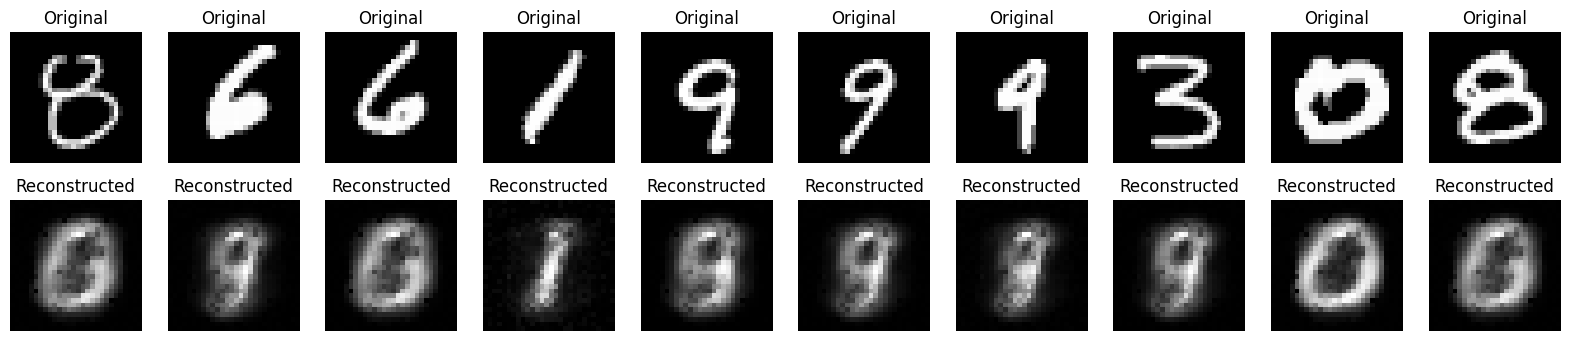

Epoch 2, Loss: 47.4293
Epoch 3, Loss: 43.6919
Epoch 4, Loss: 38.7772
Epoch 5, Loss: 38.6176
Epoch 6, Loss: 38.6947


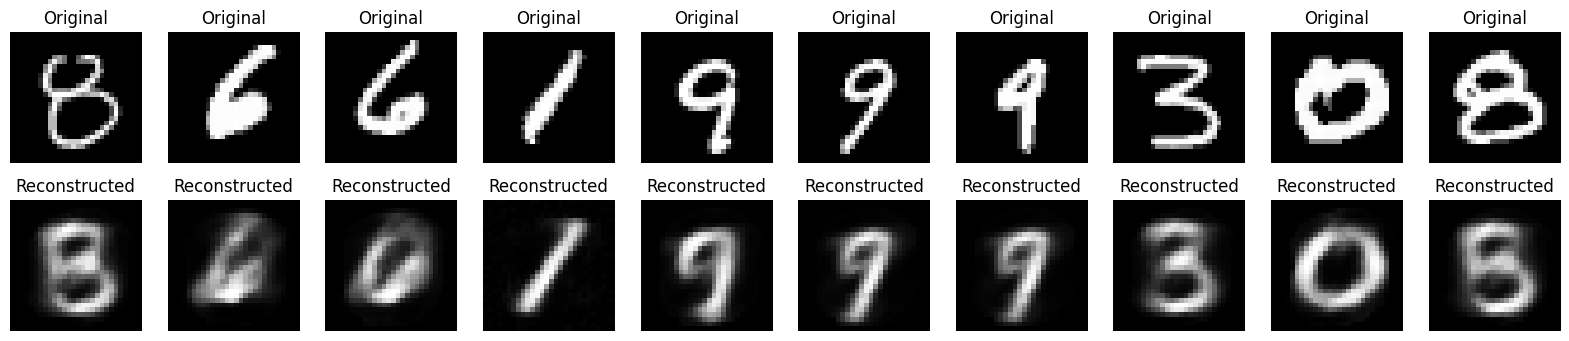

Epoch 7, Loss: 34.5644
Epoch 8, Loss: 31.1483
Epoch 9, Loss: 30.2539
Epoch 10, Loss: 31.2556
Epoch 11, Loss: 32.4091


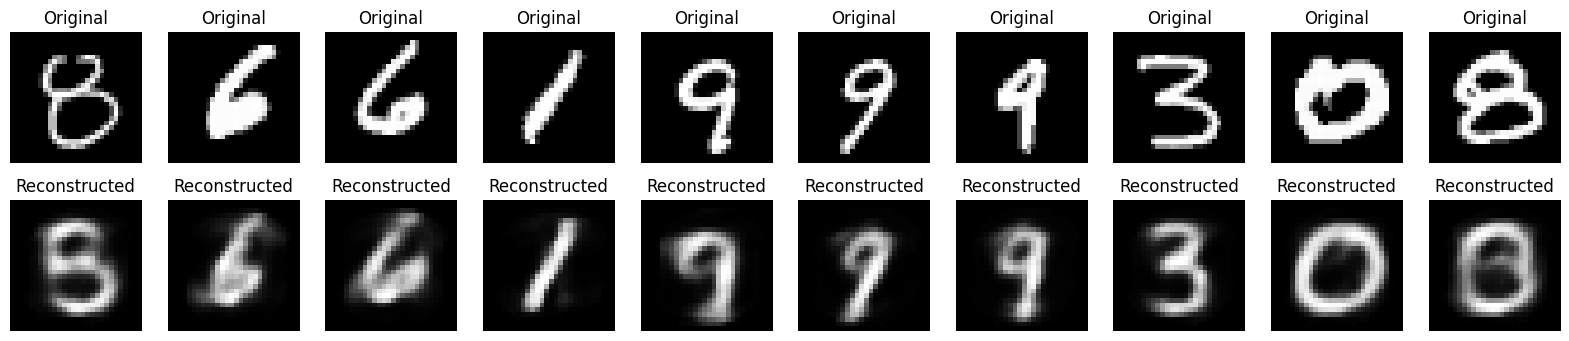

Epoch 12, Loss: 33.3662
Epoch 13, Loss: 34.6732
Epoch 14, Loss: 31.7920
Epoch 15, Loss: 30.4659
Epoch 16, Loss: 29.9846


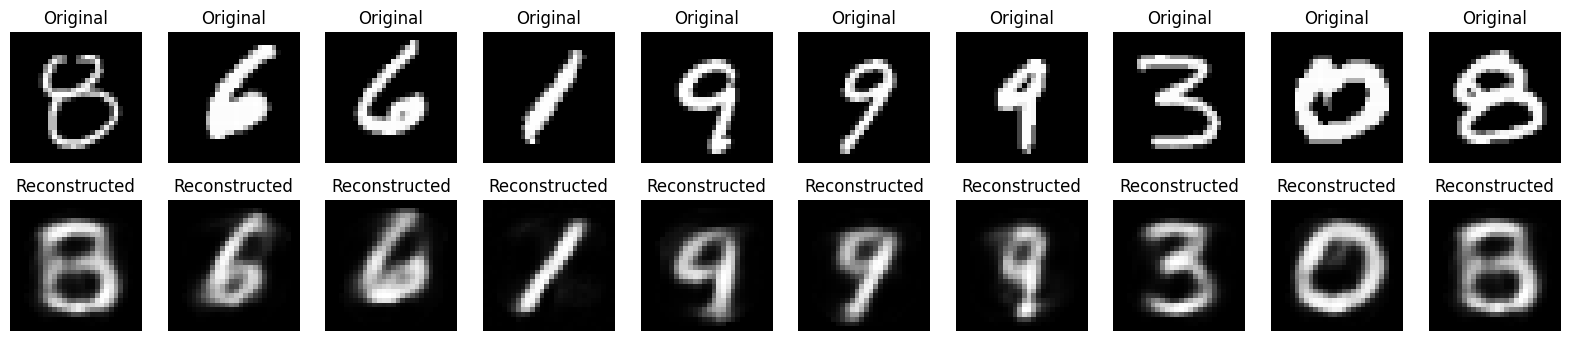

Epoch 17, Loss: 29.4163
Epoch 18, Loss: 31.5922
Epoch 19, Loss: 31.1066
Epoch 20, Loss: 28.2206


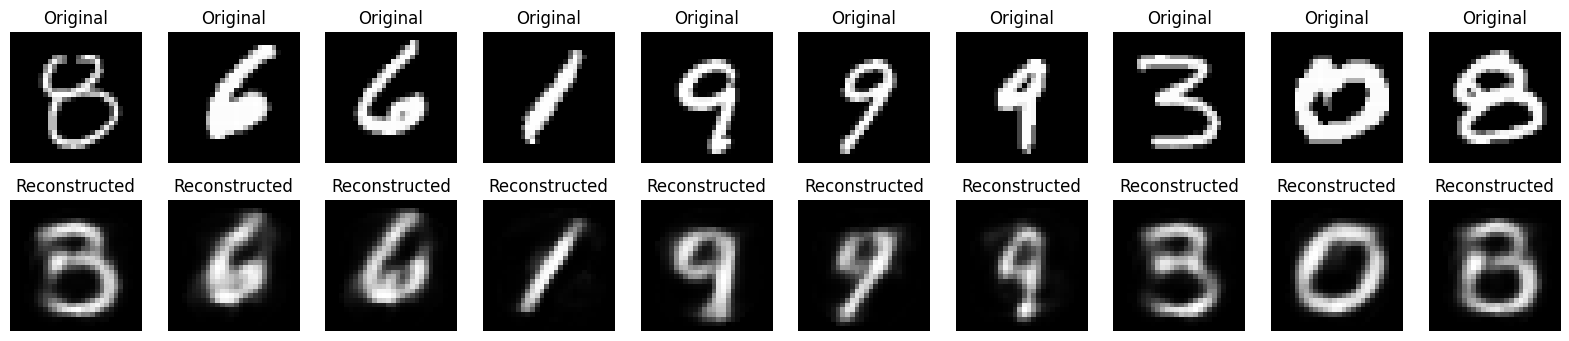

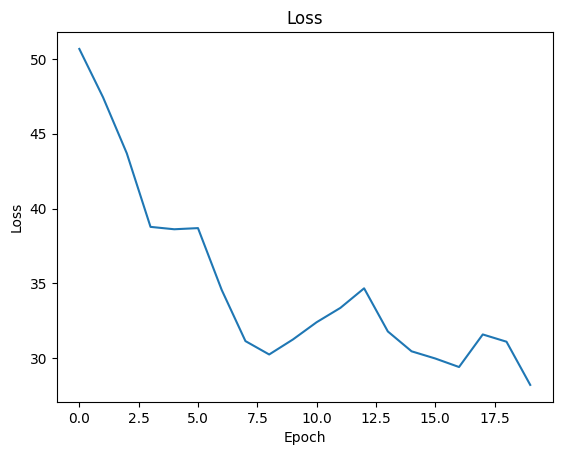

In [261]:
autoencoder = AutoEncoder_simple(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_and_visualize(autoencoder, optimizer, X_train,test_images, batch_size=256, epochs=20)

### AutoEncoder Complex

Epoch 1, Loss: 81.7173


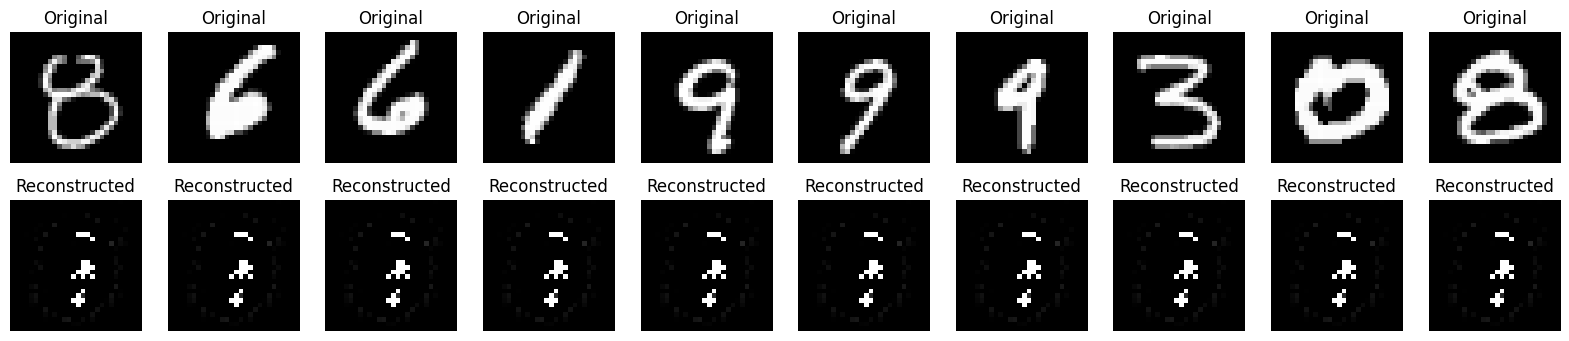

KeyboardInterrupt: 

In [259]:
autoencoder2 = AutoEncoder_complex(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder2.encoder.modules,
            *autoencoder2.decoder.modules
        )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_and_visualize(autoencoder2, optimizer, X_train,test_images, batch_size=256, epochs=20)

## Fonction d'activation TanH et Fonction de loss BCELoss

Epoch 1, Loss: 0.8239


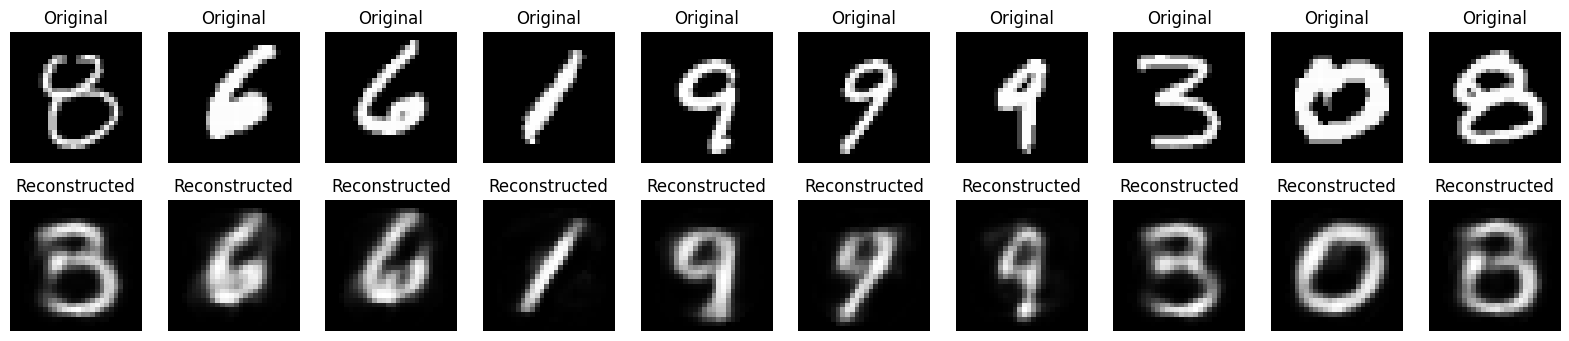

Epoch 2, Loss: 0.8619
Epoch 3, Loss: 0.8274
Epoch 4, Loss: 0.8772
Epoch 5, Loss: 0.8897
Epoch 6, Loss: 0.8351


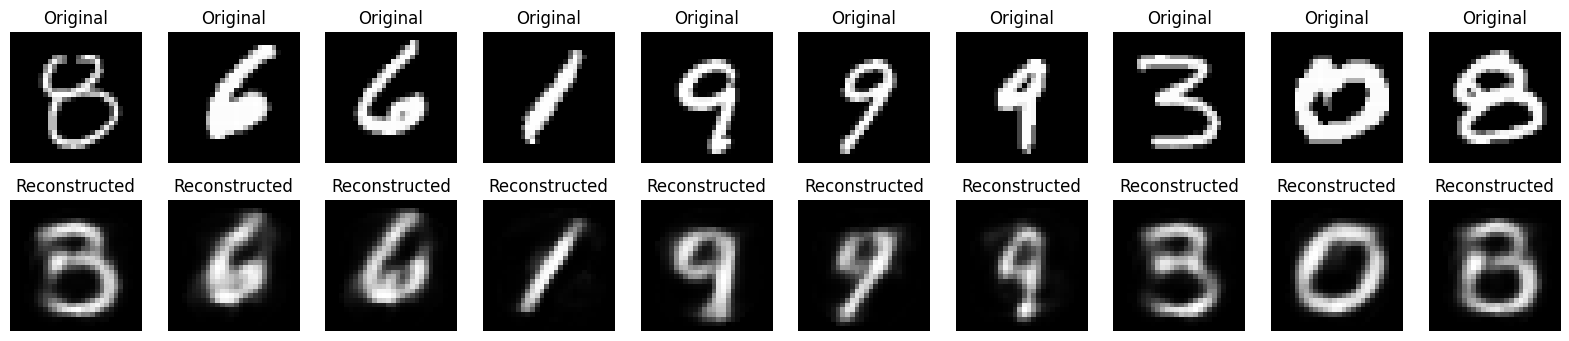

Epoch 7, Loss: 0.8977
Epoch 8, Loss: 0.8849
Epoch 9, Loss: 0.8522
Epoch 10, Loss: 0.8722
Epoch 11, Loss: 0.8870


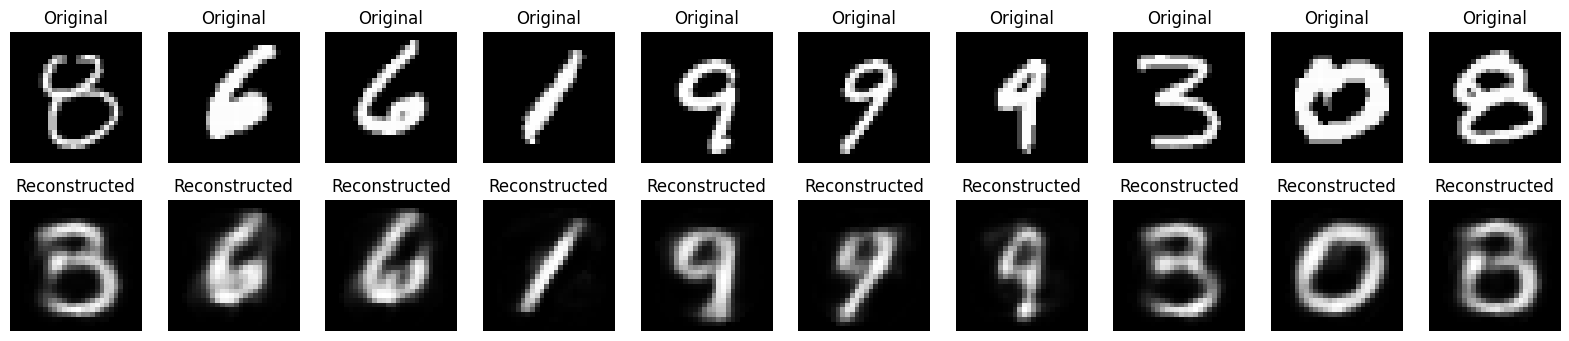

Epoch 12, Loss: 0.9071
Epoch 13, Loss: 0.8935
Epoch 14, Loss: 0.8492
Epoch 15, Loss: 0.8775
Epoch 16, Loss: 0.8294


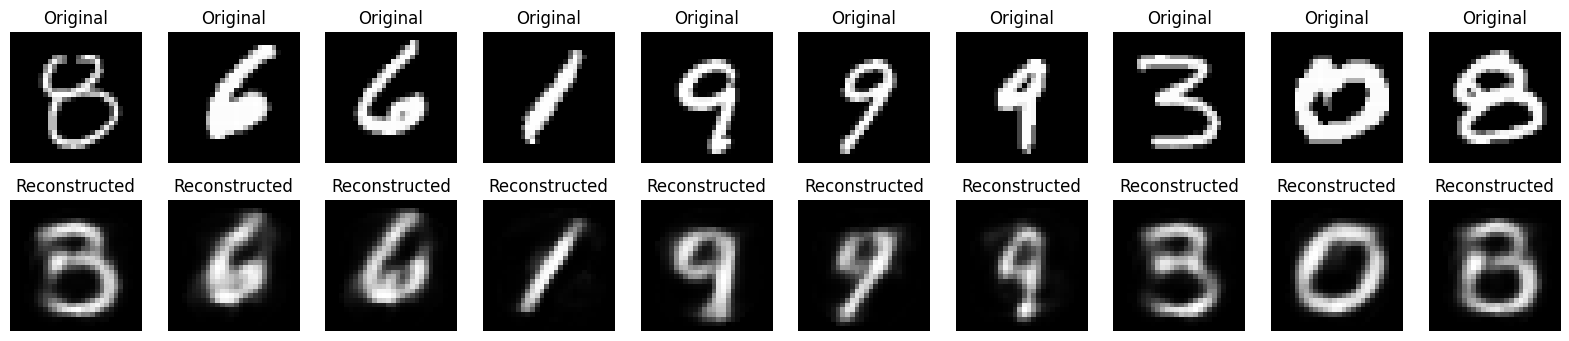

Epoch 17, Loss: 0.8391
Epoch 18, Loss: 0.8589
Epoch 19, Loss: 0.8607
Epoch 20, Loss: 0.8929


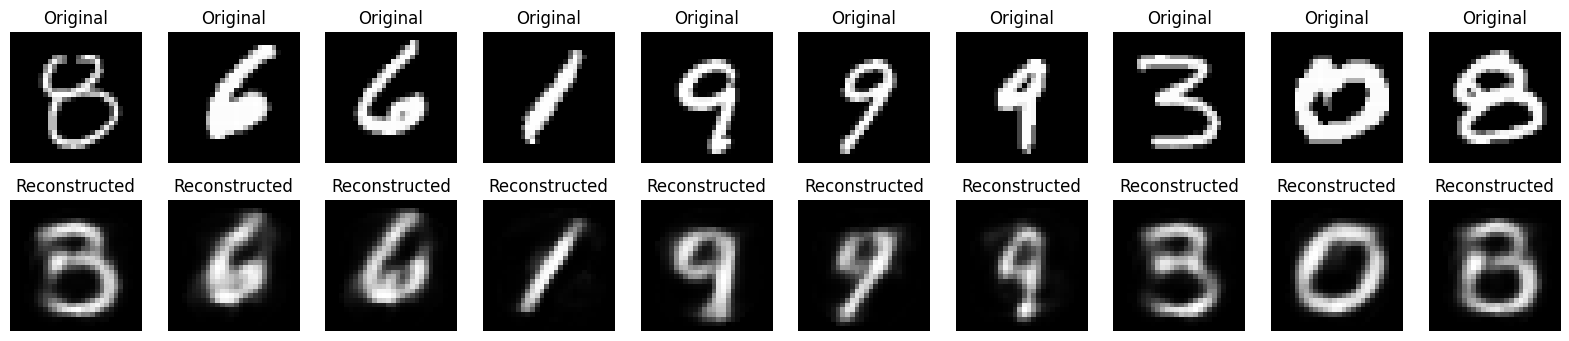

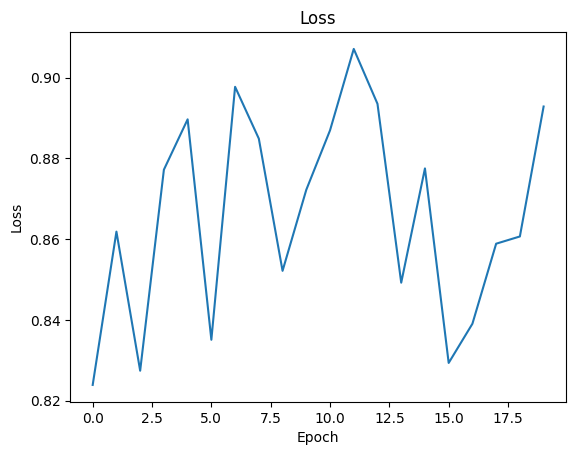

In [262]:
autoencoder3 = AutoEncoder_simple(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder3.encoder.modules,
            *autoencoder3.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_and_visualize(autoencoder, optimizer, X_train, test_images,batch_size=256, epochs=20)

Epoch 1, Loss: 1.0011


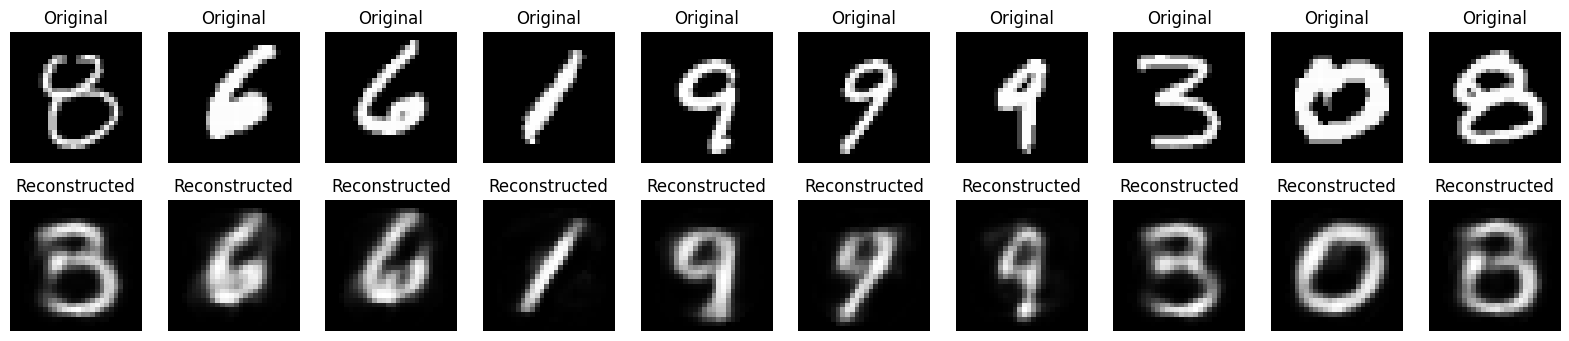

Epoch 2, Loss: 0.9748
Epoch 3, Loss: 0.9683
Epoch 4, Loss: 1.0040
Epoch 5, Loss: 1.0026
Epoch 6, Loss: 1.0262


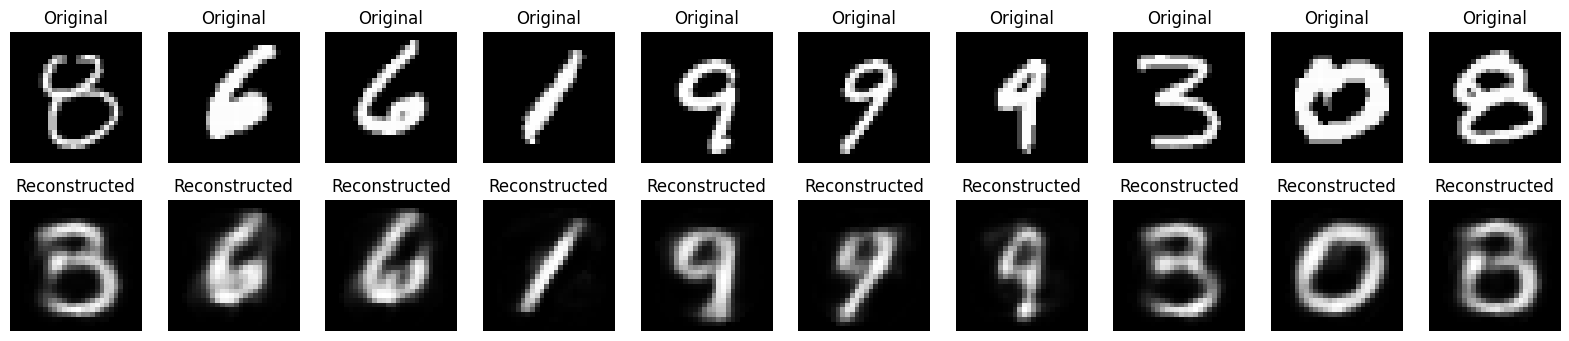

Epoch 7, Loss: 1.0114
Epoch 8, Loss: 0.9877
Epoch 9, Loss: 0.9822
Epoch 10, Loss: 1.0050
Epoch 11, Loss: 0.9958


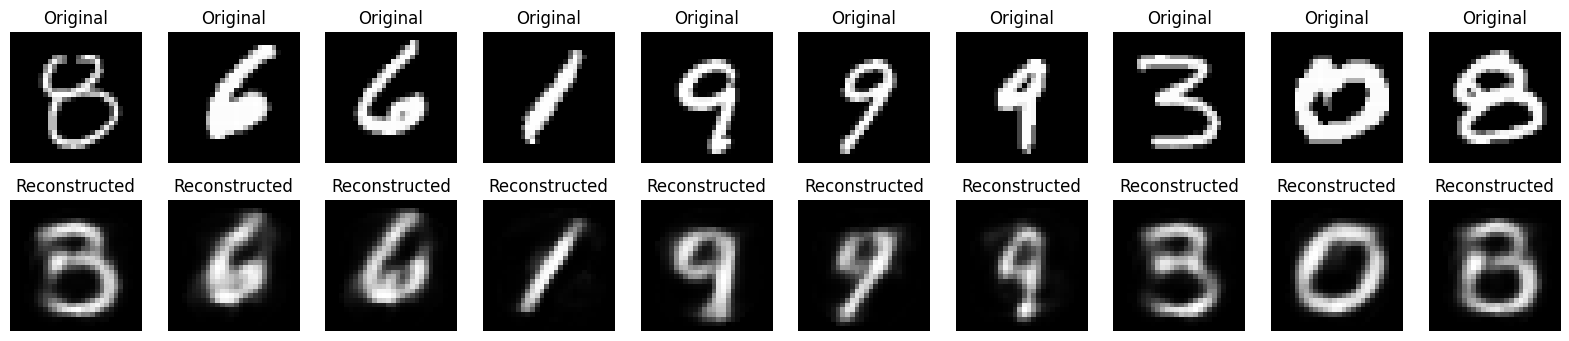

Epoch 12, Loss: 0.9971
Epoch 13, Loss: 0.9724
Epoch 14, Loss: 1.0051
Epoch 15, Loss: 0.9977
Epoch 16, Loss: 1.0030


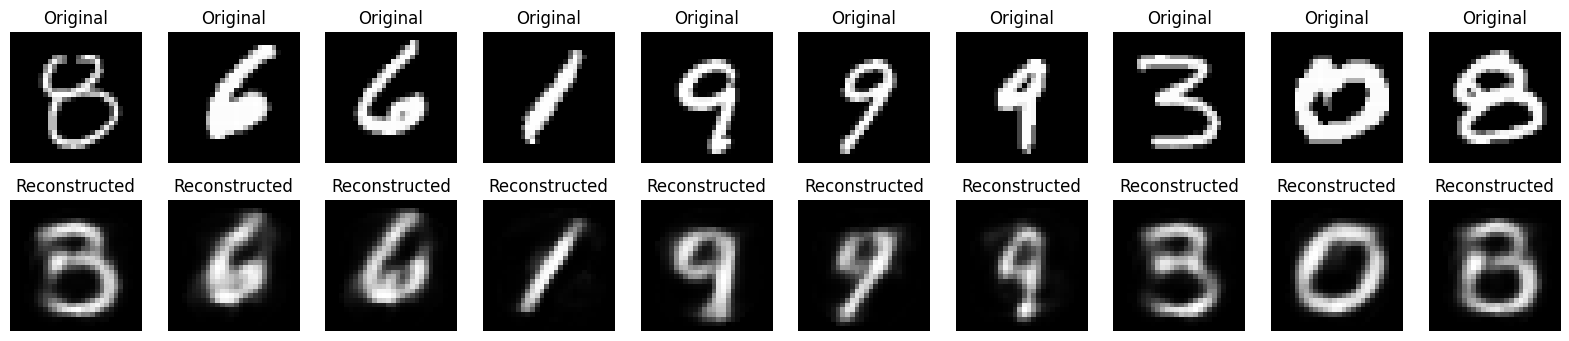

Epoch 17, Loss: 1.0176
Epoch 18, Loss: 0.9850
Epoch 19, Loss: 0.9729
Epoch 20, Loss: 1.0075


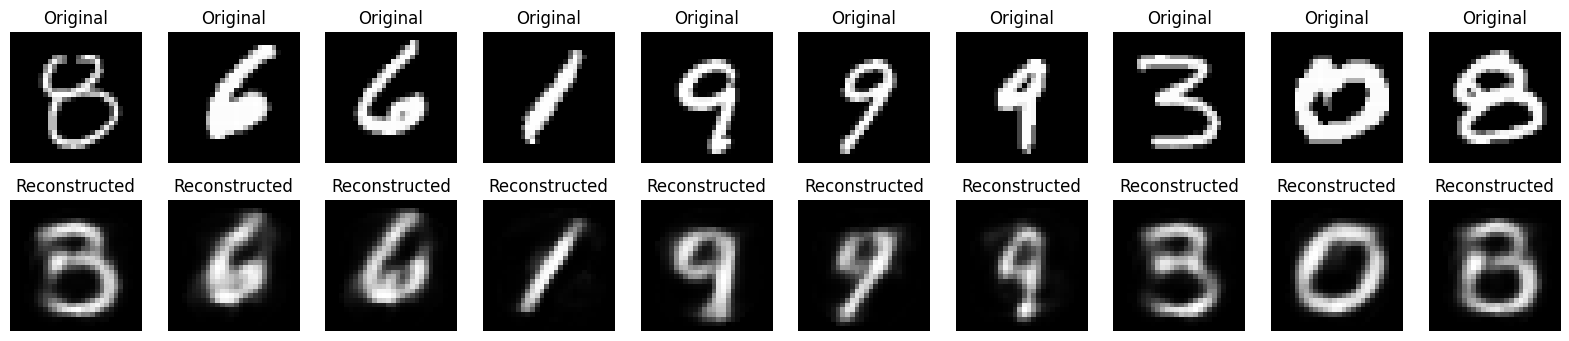

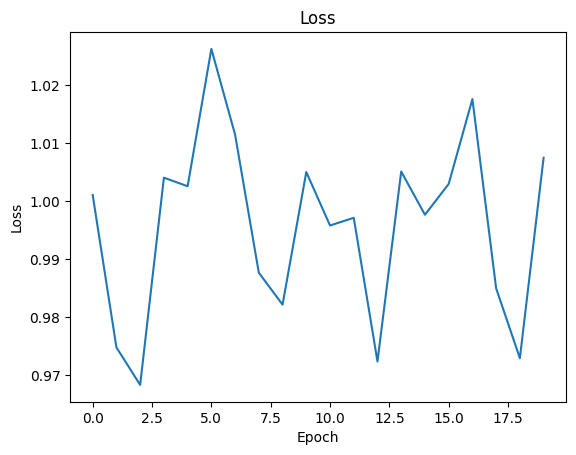

In [264]:
autoencoder4 = AutoEncoder_complex(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder4.encoder.modules,
            *autoencoder4.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_and_visualize(autoencoder, optimizer, X_train, test_images,batch_size=256, epochs=20)

# Données USPS

## Fonction d'activation TanH et Fonction de loss MSE

### AutoEncoder Complexe

Epoch 1, Loss: 130.1934


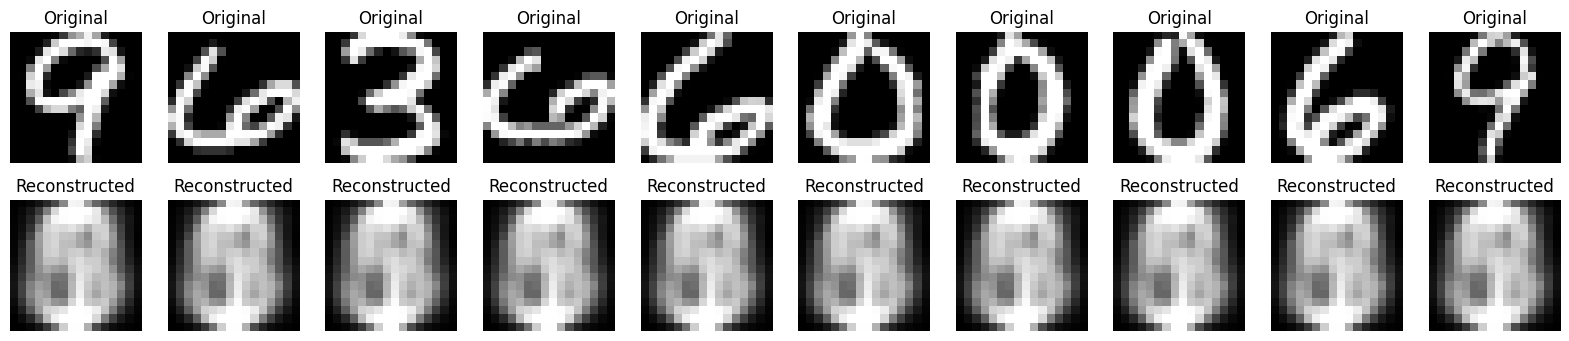

Epoch 2, Loss: 121.9961
Epoch 3, Loss: 101.1483
Epoch 4, Loss: 84.7992
Epoch 5, Loss: 81.7382
Epoch 6, Loss: 80.7456


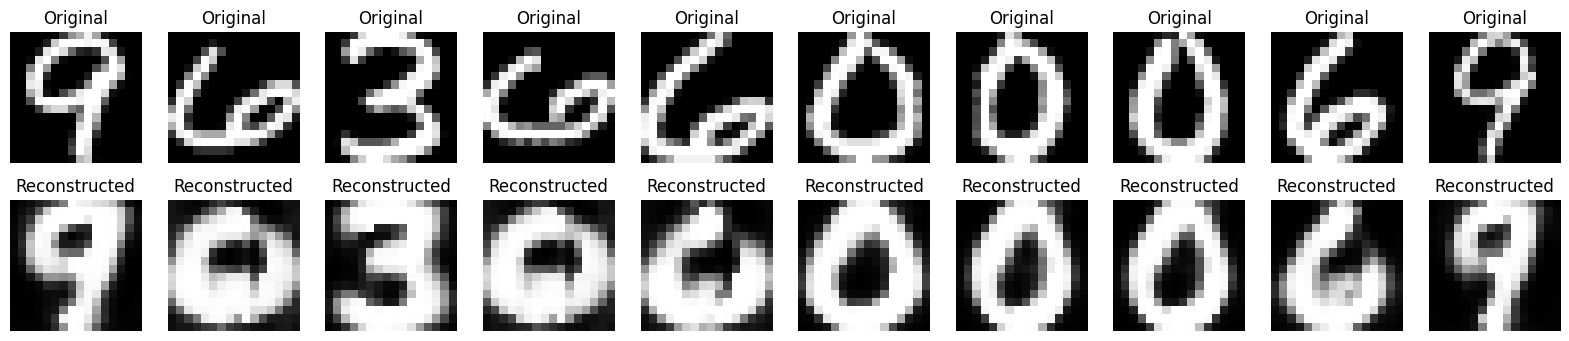

Epoch 7, Loss: 77.1599
Epoch 8, Loss: 79.7946
Epoch 9, Loss: 72.8142
Epoch 10, Loss: 70.9551
Epoch 11, Loss: 71.1899


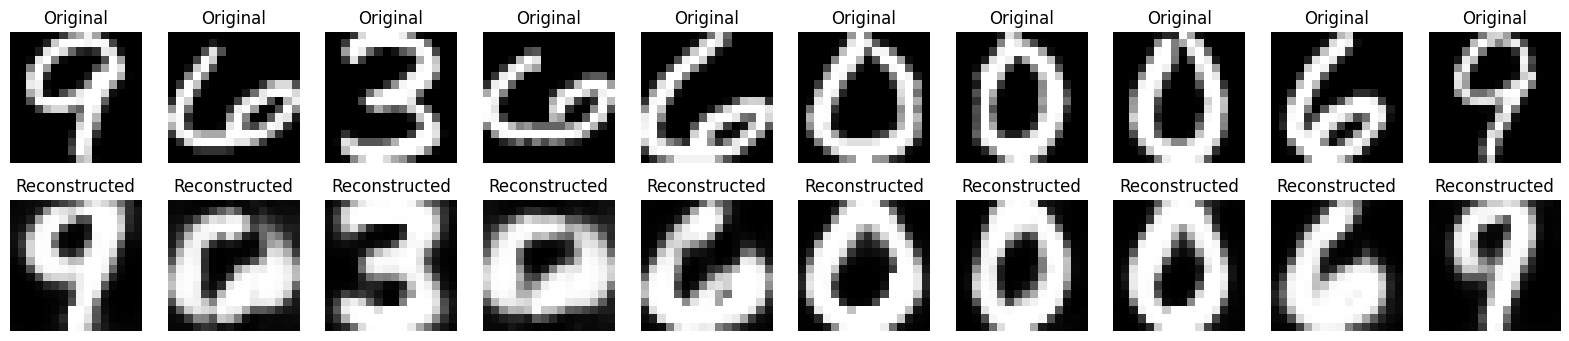

Epoch 12, Loss: 69.4306
Epoch 13, Loss: 59.2557
Epoch 14, Loss: 65.2932
Epoch 15, Loss: 61.3452
Epoch 16, Loss: 62.2262


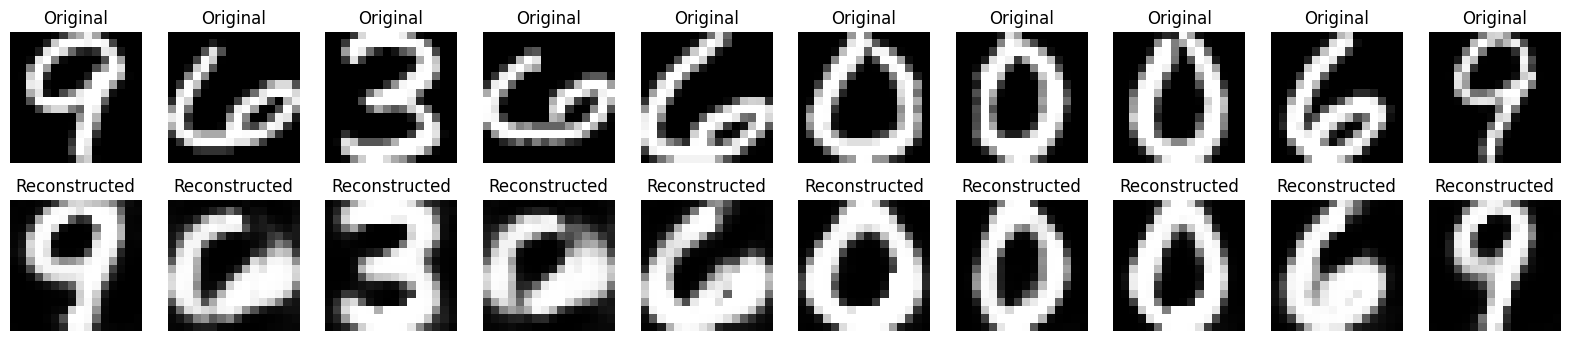

Epoch 17, Loss: 64.7875
Epoch 18, Loss: 66.9221
Epoch 19, Loss: 60.3997
Epoch 20, Loss: 63.1019
Epoch 21, Loss: 57.3488


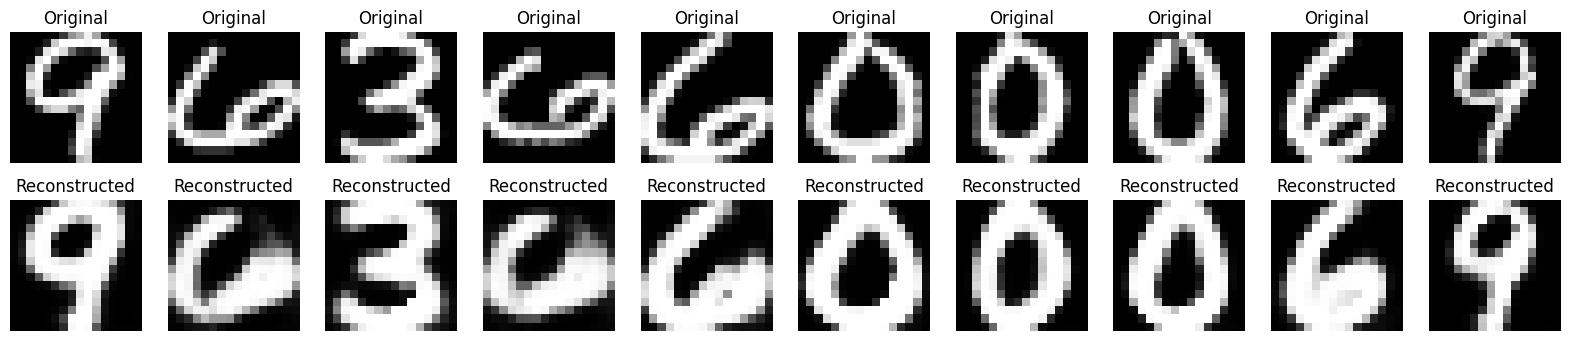

Epoch 22, Loss: 62.6436
Epoch 23, Loss: 62.7030
Epoch 24, Loss: 56.3033
Epoch 25, Loss: 61.8046
Epoch 26, Loss: 58.5407


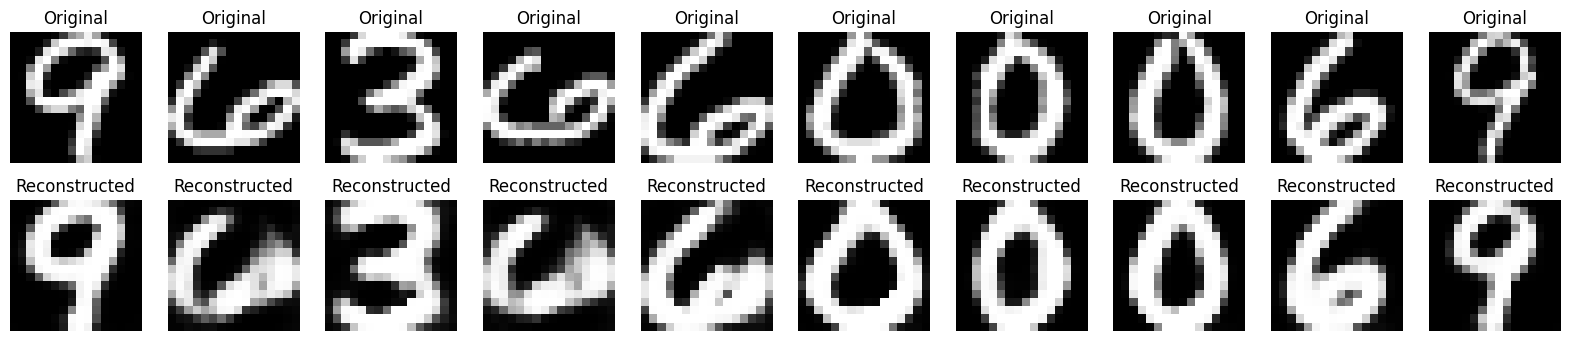

Epoch 27, Loss: 54.4711
Epoch 28, Loss: 63.4098
Epoch 29, Loss: 55.1600
Epoch 30, Loss: 51.9800


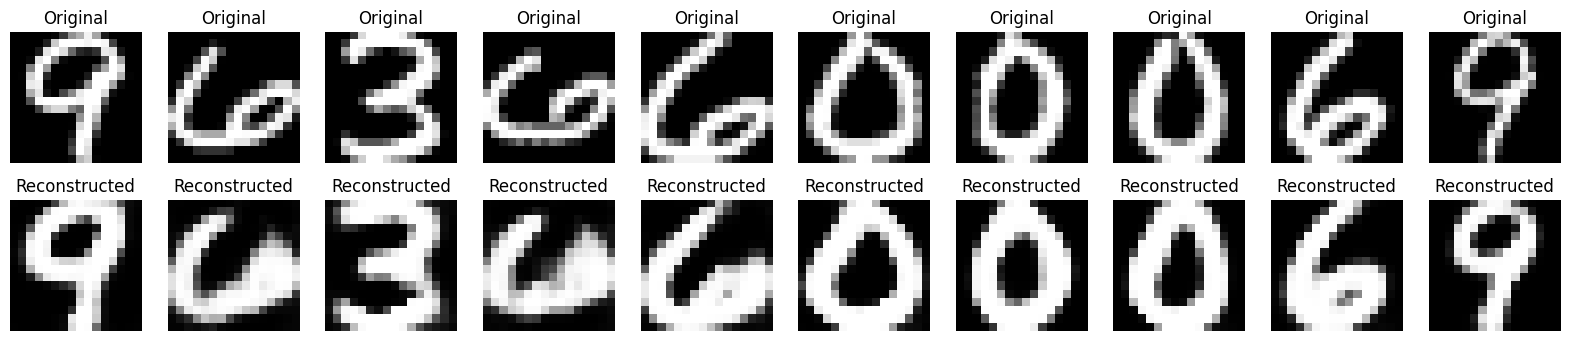

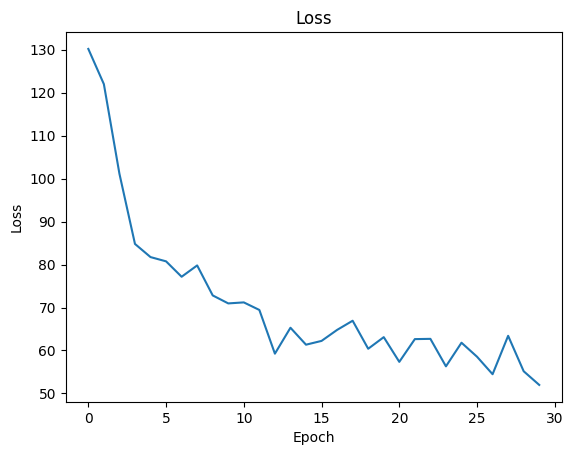

In [163]:
autoencoder_u = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder_u.encoder.modules,
                *autoencoder_u.decoder.modules
            )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_visualize_Usps(autoencoder_u, optimizer, alltrainx, batch_size=64, epochs=30)



### AutoEncoder Complex

Epoch 1, Loss: 126.1998


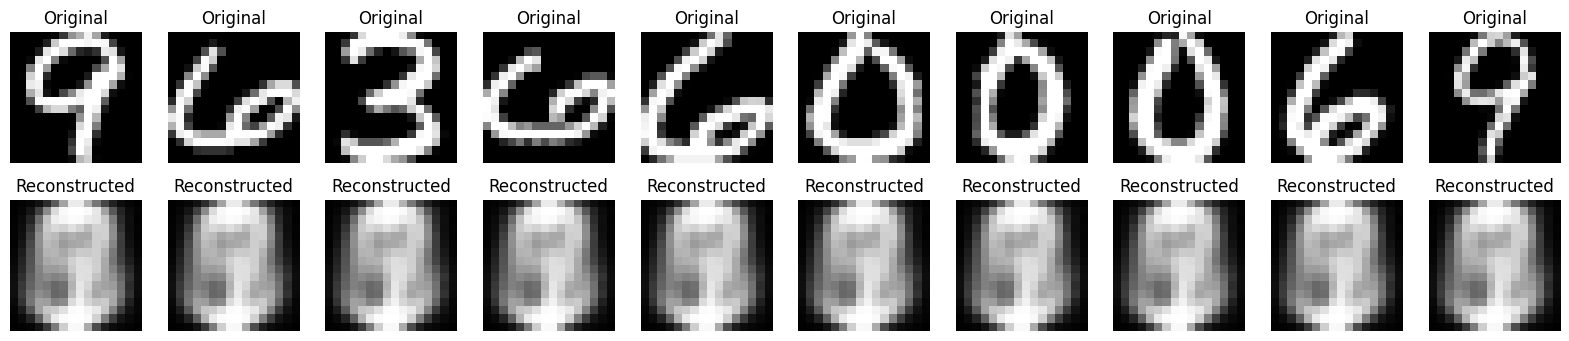

Epoch 2, Loss: 124.4846
Epoch 3, Loss: 112.9668
Epoch 4, Loss: 111.6594
Epoch 5, Loss: 119.0330
Epoch 6, Loss: 126.8985


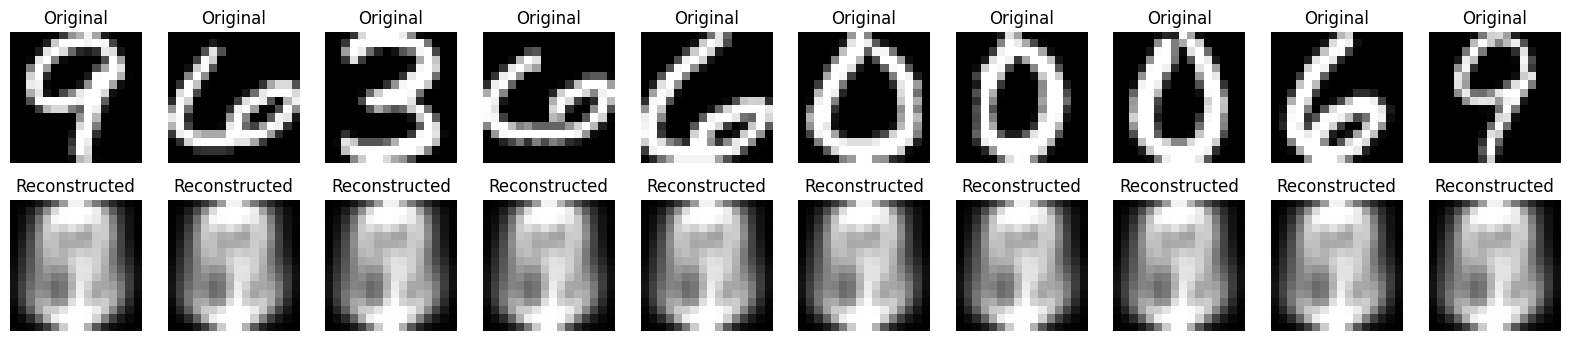

Epoch 7, Loss: 132.3636
Epoch 8, Loss: 125.5635
Epoch 9, Loss: 122.7050
Epoch 10, Loss: 120.1580
Epoch 11, Loss: 120.6051


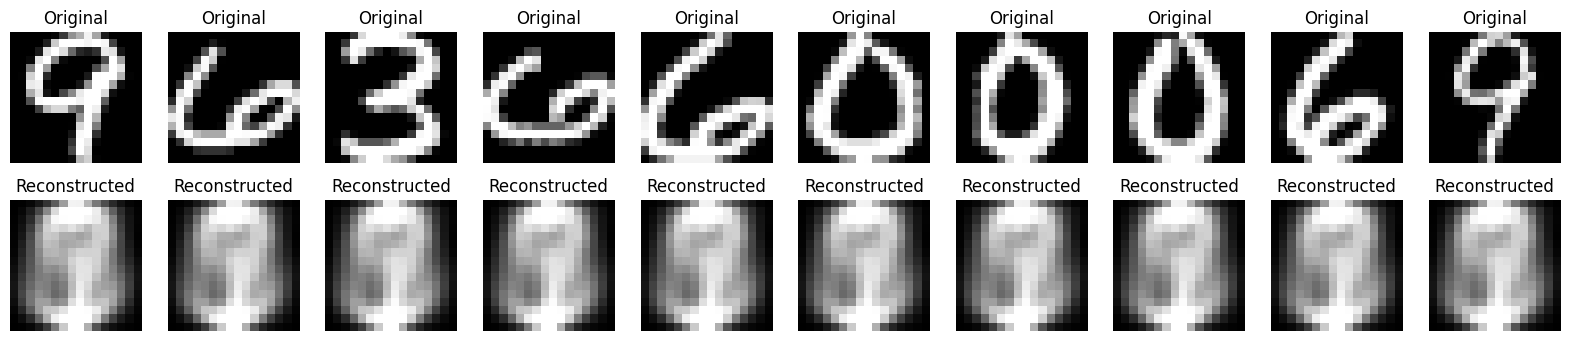

Epoch 12, Loss: 118.3698
Epoch 13, Loss: 121.6047
Epoch 14, Loss: 124.9370
Epoch 15, Loss: 123.9866
Epoch 16, Loss: 116.3568


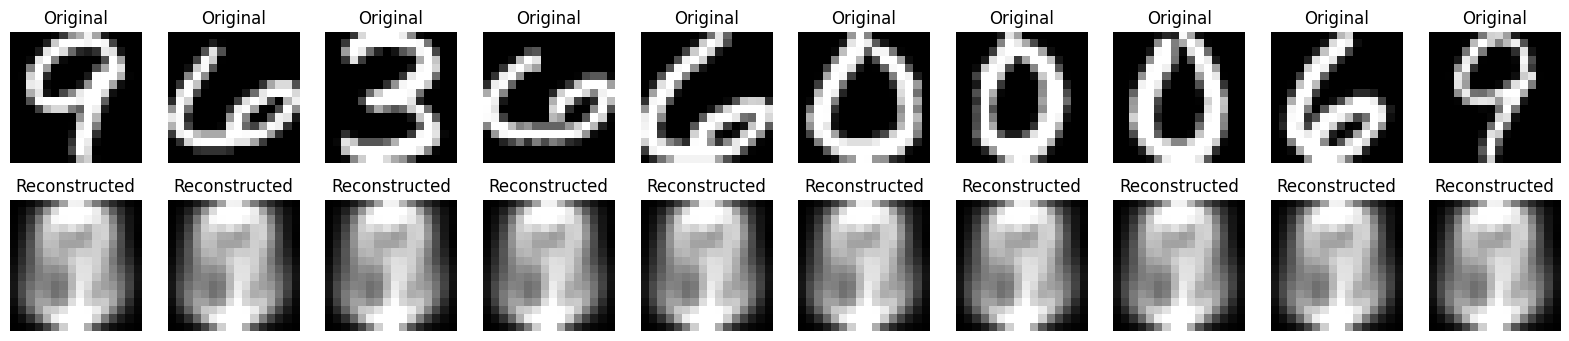

Epoch 17, Loss: 119.8977
Epoch 18, Loss: 121.1582
Epoch 19, Loss: 113.4101
Epoch 20, Loss: 124.9350


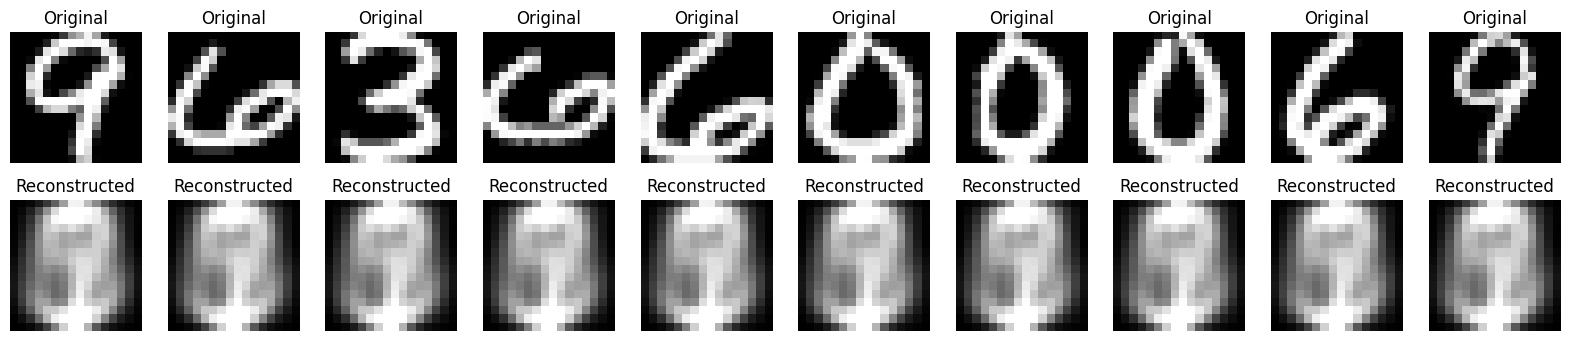

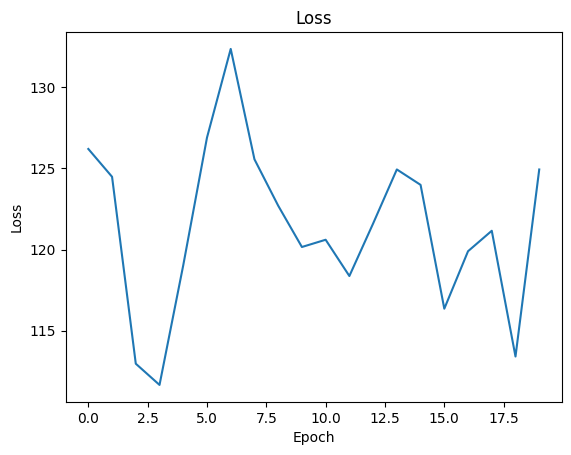

In [159]:
autoencoder2 = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder2.encoder.modules,
                *autoencoder2.decoder.modules
            )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_visualize_Usps(autoencoder2, optimizer, alltrainx, batch_size=64, epochs=20)

## Fonction d'activation TanH et Fonction de loss BCE

### AutoEncoder Simple

Epoch 1, Loss: -0.0353


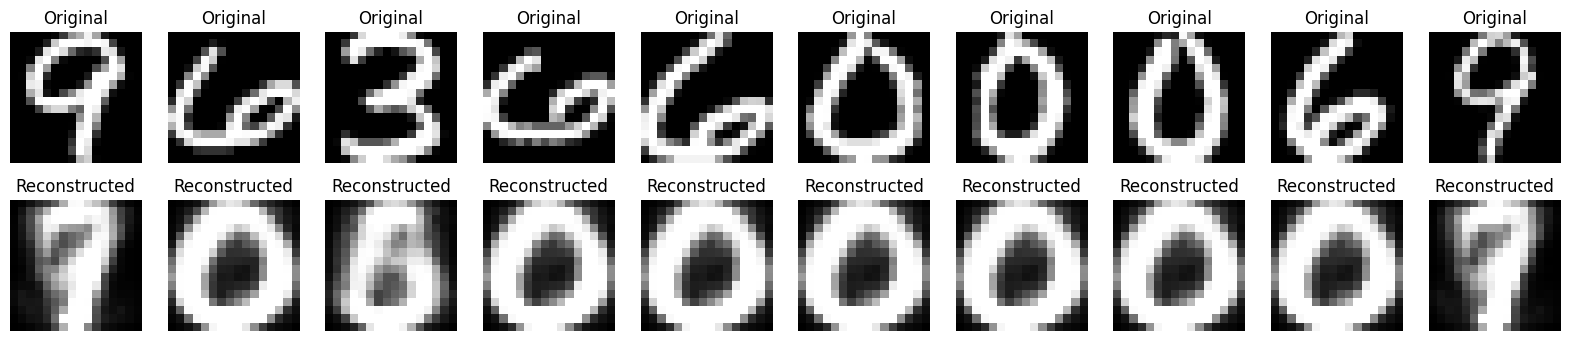

Epoch 2, Loss: -0.2247
Epoch 3, Loss: -0.4135
Epoch 4, Loss: -0.4842
Epoch 5, Loss: -0.6280
Epoch 6, Loss: -0.6891


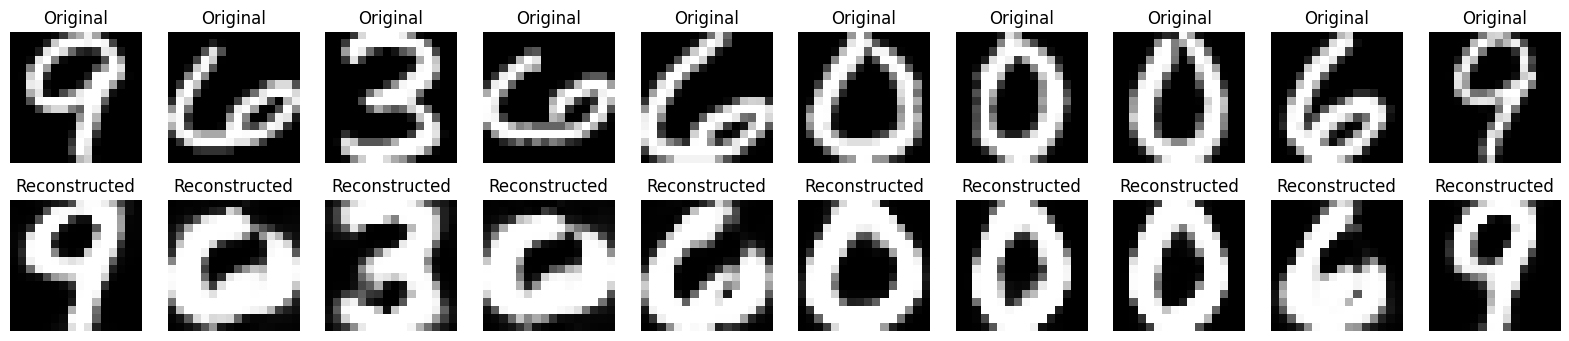

Epoch 7, Loss: -0.5325
Epoch 8, Loss: -0.6238
Epoch 9, Loss: -0.7048
Epoch 10, Loss: -0.7339
Epoch 11, Loss: -0.7772


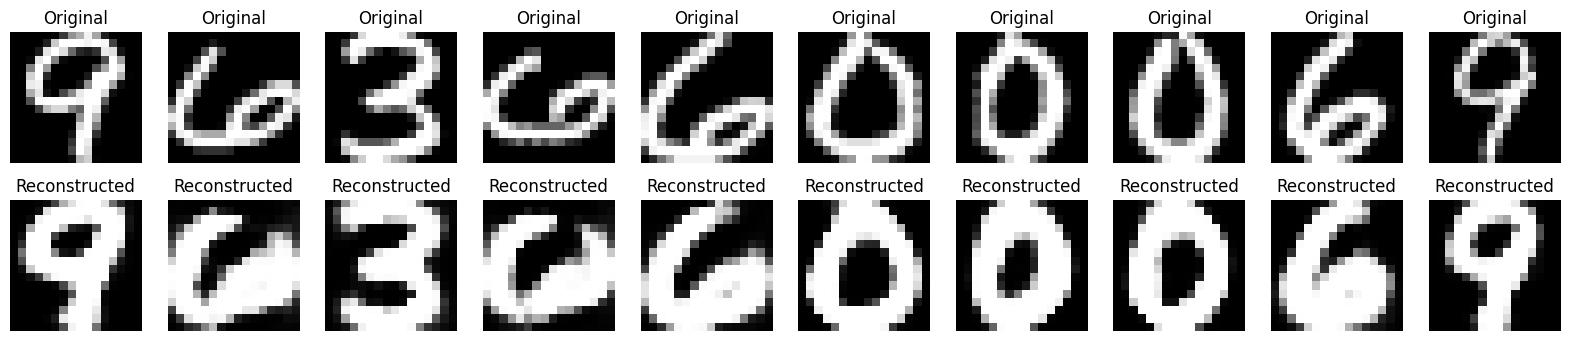

Epoch 12, Loss: -0.7616
Epoch 13, Loss: -0.9428
Epoch 14, Loss: -0.8408
Epoch 15, Loss: -0.7002
Epoch 16, Loss: -0.8514


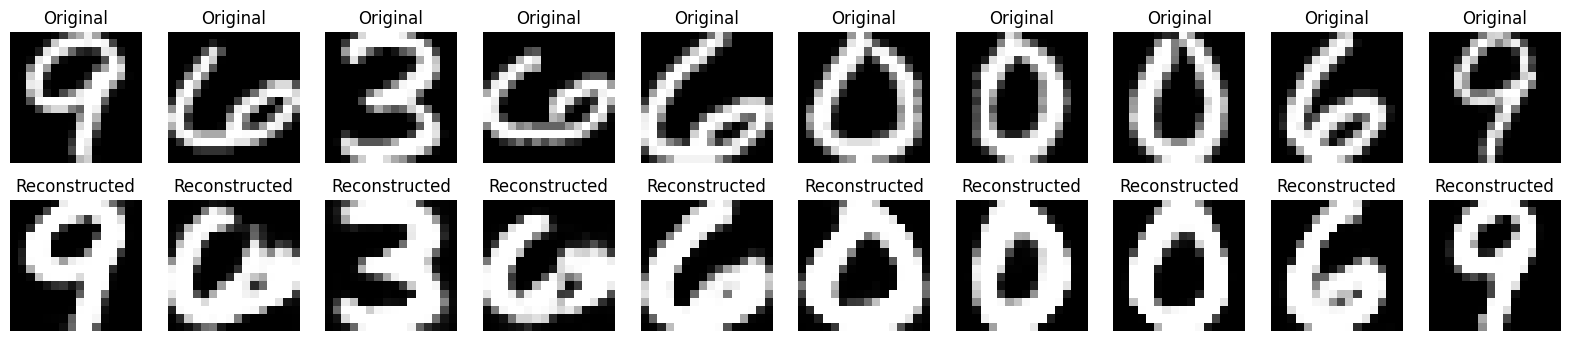

Epoch 17, Loss: -0.9406
Epoch 18, Loss: -0.7989
Epoch 19, Loss: -0.7211
Epoch 20, Loss: -0.7993
Epoch 21, Loss: -0.8374


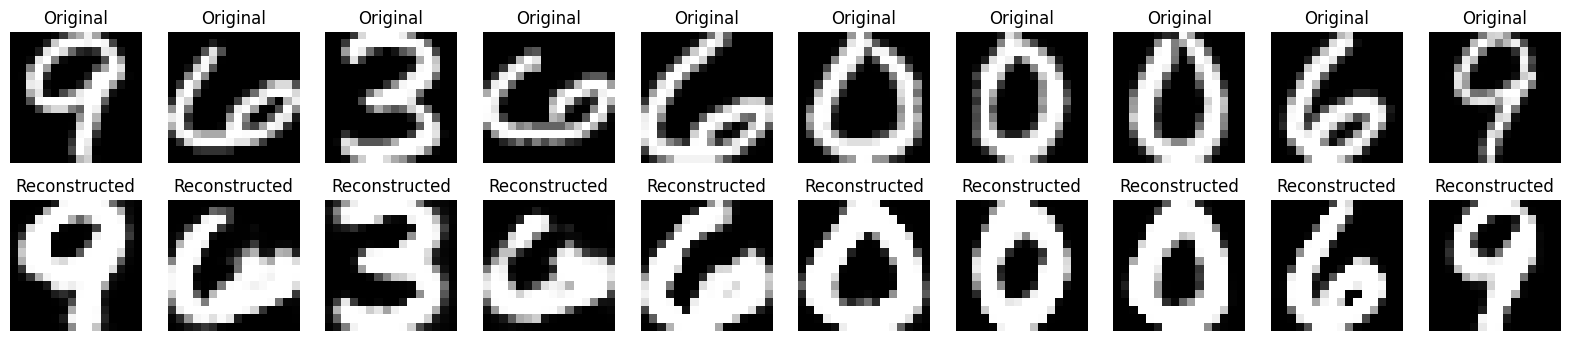

Epoch 22, Loss: -0.9583
Epoch 23, Loss: -0.8339
Epoch 24, Loss: -0.9225
Epoch 25, Loss: -0.9173
Epoch 26, Loss: -0.8243


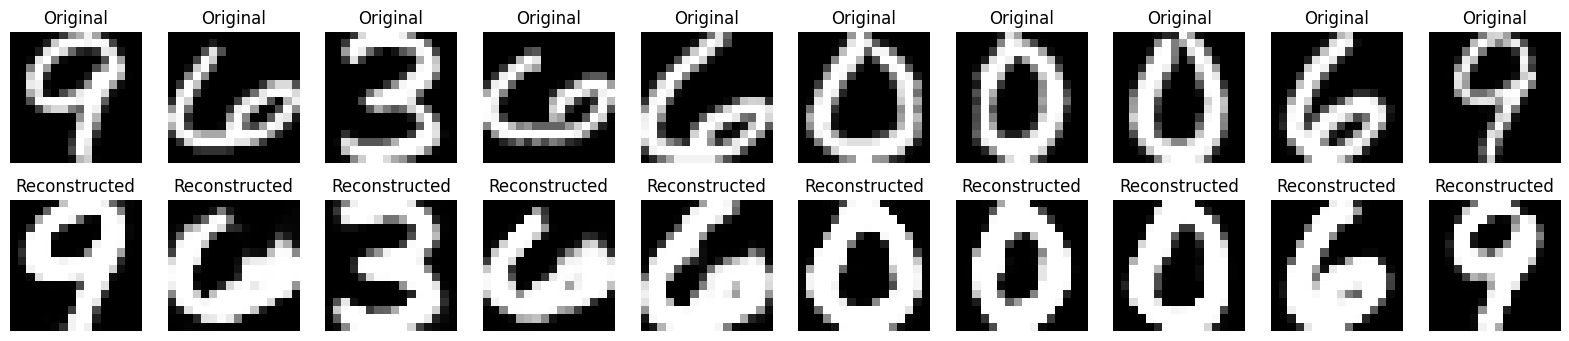

Epoch 27, Loss: -0.9096
Epoch 28, Loss: -0.8200
Epoch 29, Loss: -0.7271
Epoch 30, Loss: -0.9996


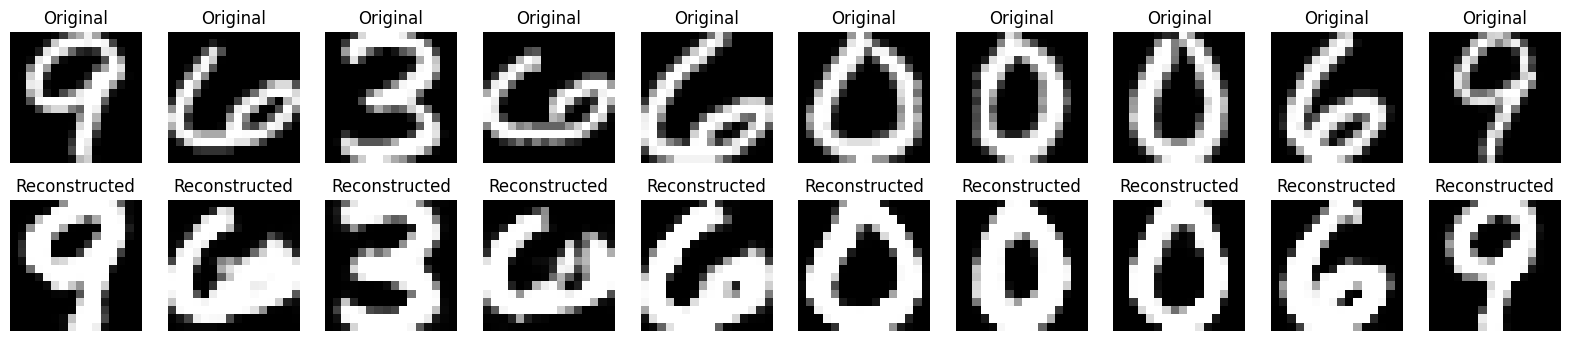

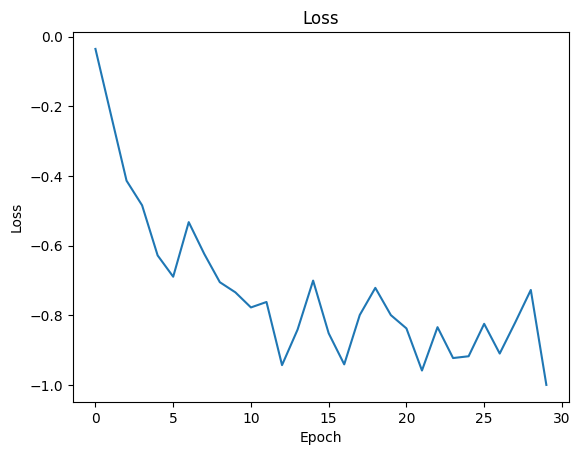

In [92]:
autoencoder3 = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder3.encoder.modules,
                *autoencoder3.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder3, optimizer, alltrainx, batch_size=64, epochs=30, plot=True)


### AutoEncoder Complex

Epoch 1, Loss: 0.3475


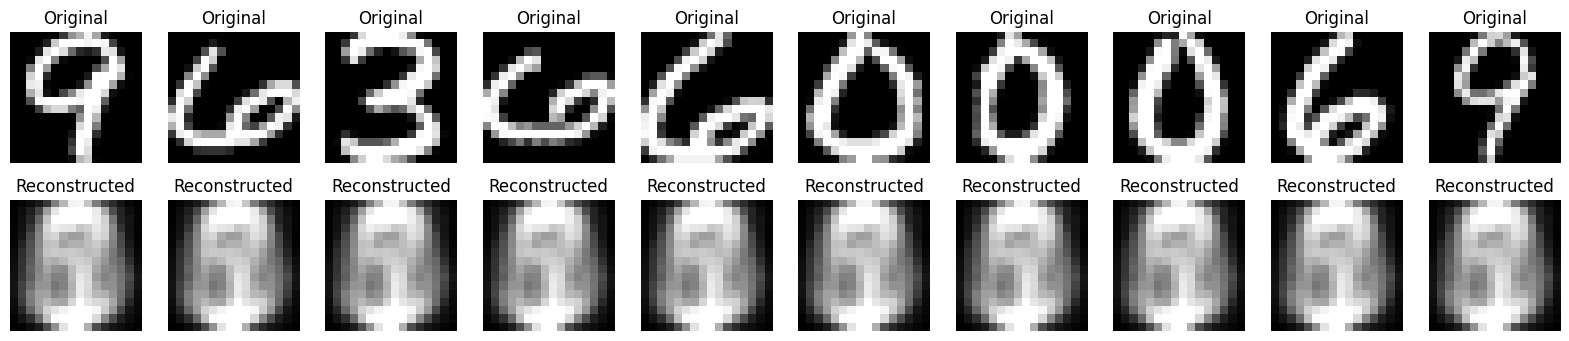

Epoch 2, Loss: 0.3760
Epoch 3, Loss: 0.4186
Epoch 4, Loss: 0.3381
Epoch 5, Loss: 0.3417
Epoch 6, Loss: 0.3396


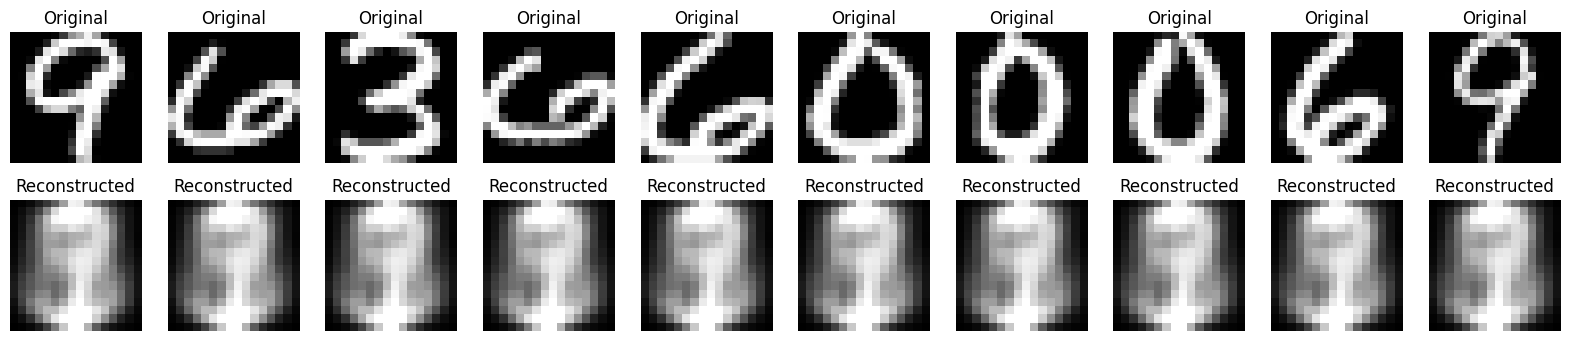

Epoch 7, Loss: 0.3620
Epoch 8, Loss: 0.2677
Epoch 9, Loss: 0.4248
Epoch 10, Loss: 0.3499
Epoch 11, Loss: 0.4355


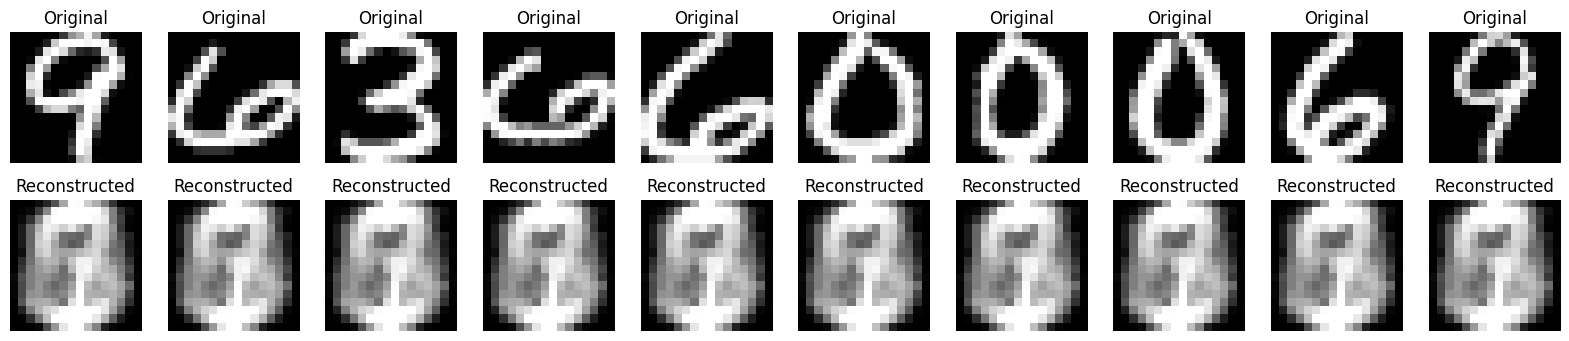

Epoch 12, Loss: 0.0525
Epoch 13, Loss: -0.0183
Epoch 14, Loss: -0.2258
Epoch 15, Loss: 0.0237
Epoch 16, Loss: -0.3265


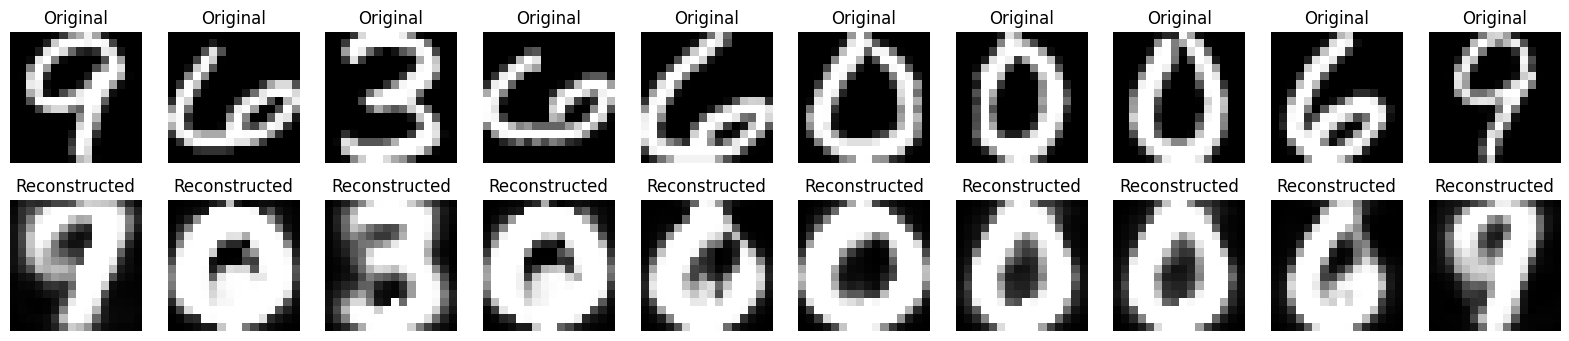

Epoch 17, Loss: -0.3500
Epoch 18, Loss: -0.1402
Epoch 19, Loss: -0.3652
Epoch 20, Loss: -0.4876
Epoch 21, Loss: -0.3311


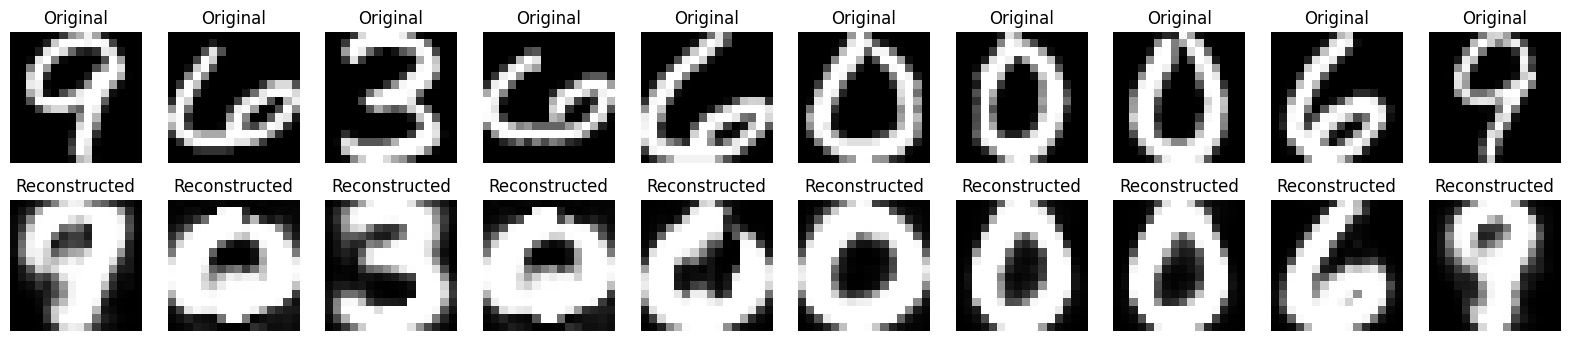

Epoch 22, Loss: -0.4836
Epoch 23, Loss: -0.3755
Epoch 24, Loss: -0.4787
Epoch 25, Loss: -0.4342
Epoch 26, Loss: -0.3821


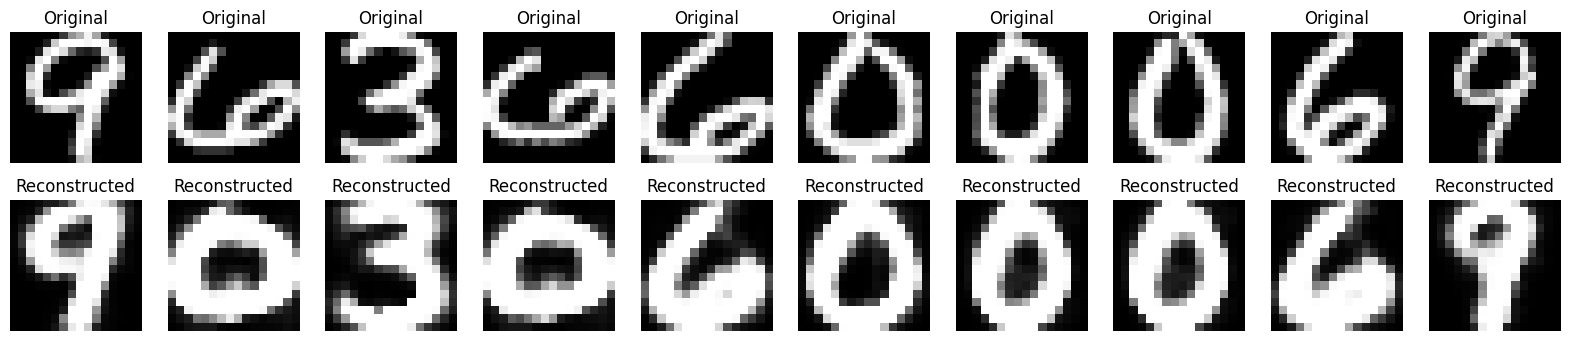

Epoch 27, Loss: -0.4268
Epoch 28, Loss: -0.4344
Epoch 29, Loss: -0.2168
Epoch 30, Loss: -0.3872


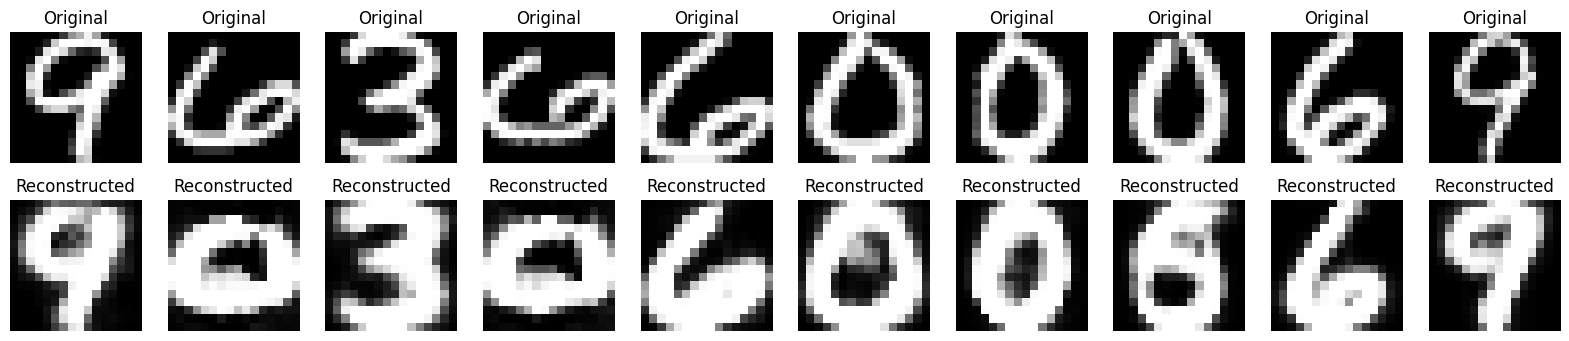

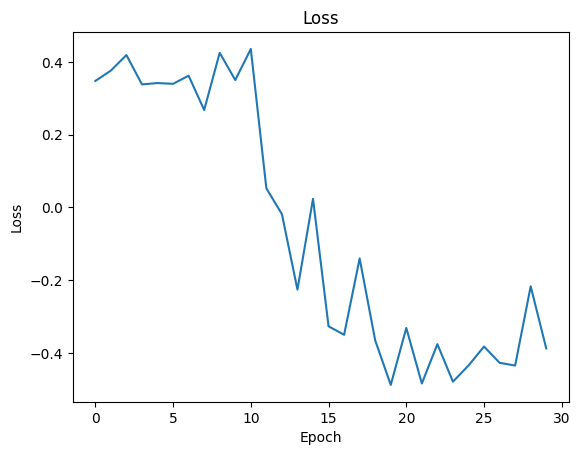

In [95]:
autoencoder4 = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder4.encoder.modules,
                *autoencoder4.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder4, optimizer, alltrainx, batch_size=64, epochs=30)

In [218]:
from sklearn import manifold, cluster, metrics
import seaborn as sns
import pandas as pd


def add_2d_scatter(fig, ax, points, point_color, title=None):
    x, y = points.T
    data = pd.DataFrame({"tsne1": x, "tsne2": y, "label": point_color}).sort_values(by="label")
    sns.despine(fig, left=True, bottom=True)
    sns.scatterplot(
        data=data, x="tsne1", y="tsne2", hue="label", linewidth=0, s=12, ax=ax, palette="deep"
    )
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.0)
    ax.set_title(title)

def plot_tsne2(X_decoded, y,title):
    fig, ax = plt.subplots(ncols=1, figsize=(6,6))
    tsne = manifold.TSNE(n_jobs=-1, perplexity=30)
    x_reduced = tsne.fit_transform(X_decoded)
    add_2d_scatter(fig, ax, x_reduced, y, "")
    ax.set_title(title)


In [210]:
def tsne_plot(autoencoder, X, y , plot, title):
    X_encoded = autoencoder.forward(X)
    #X_decoded = autoencoder.decoder.forward(X_encoded)
    plot(X_encoded, y,title)

# Kmeans clustering
def kmeans_clustering(autoencoder, X, y):
    X_encoded = autoencoder.encoder.forward(X)
    kmeans = cluster.KMeans(n_clusters=2, random_state=0)
    kmeans.fit(X_encoded)
    y_pred = kmeans.predict(X_encoded)
    print(f"Kmeans clustering accuracy: {metrics.accuracy_score(y, y_pred)}")



In [ ]:
encoder = Sequential(
            *autoencoder_u.encoder.modules
        )

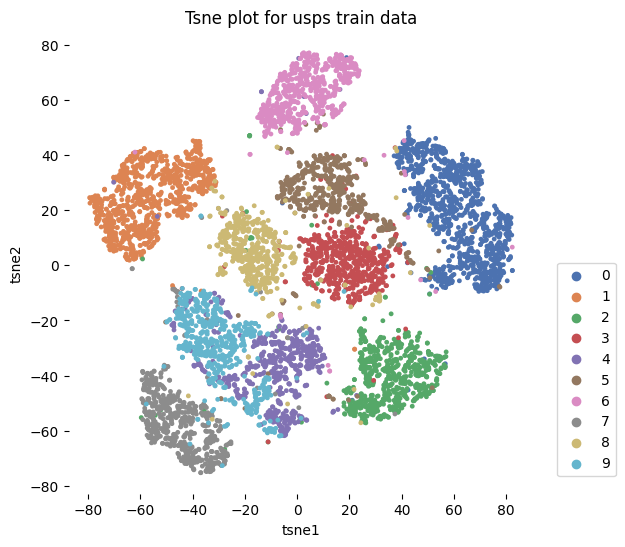

In [219]:
tsne_plot(encoder,alltrainx,alltrainy,plot_tsne2,"Tsne plot for usps train data")

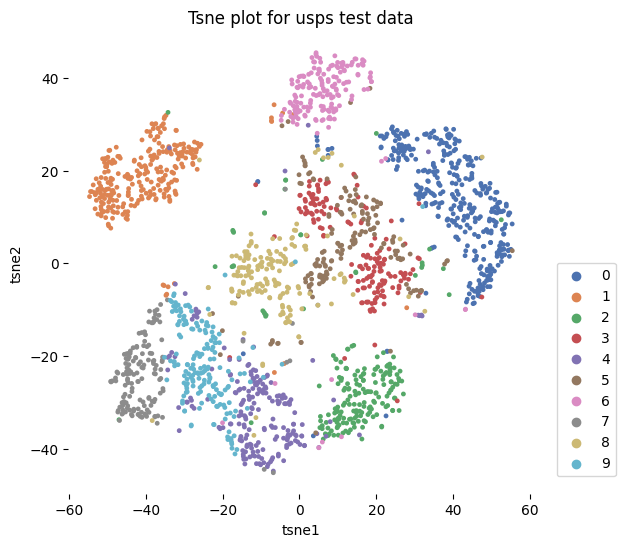

In [220]:
tsne_plot(encoder,alltestx,alltesty,plot_tsne2, "Tsne plot for usps test data")

# Ajouter des Bruit

## MINIST (TanH et MCE avec modèle simple et TanH et BCE avec modèles simple et complex)

Epoch 1, Loss: 37.0976


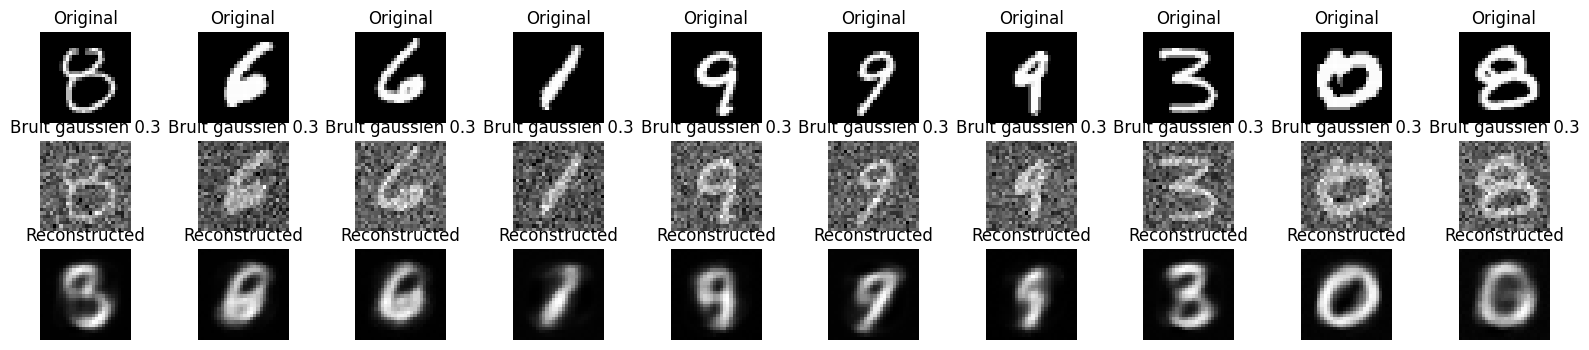

Epoch 2, Loss: 26.2115
Epoch 3, Loss: 17.7496
Epoch 4, Loss: 15.0350
Epoch 5, Loss: 13.5658
Epoch 6, Loss: 11.4137


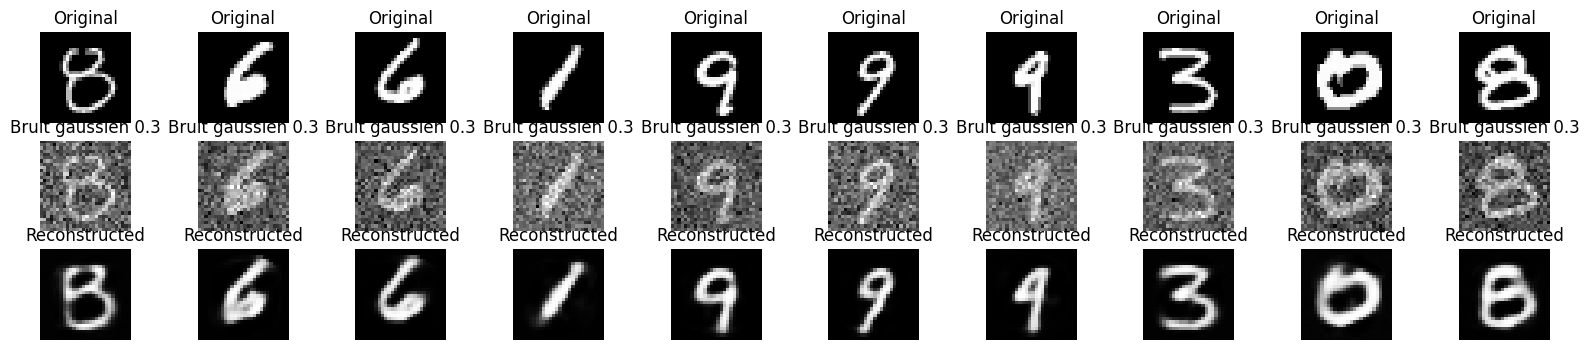

Epoch 7, Loss: 11.9596
Epoch 8, Loss: 10.5240
Epoch 9, Loss: 10.5257
Epoch 10, Loss: 9.8359
Epoch 11, Loss: 9.2076


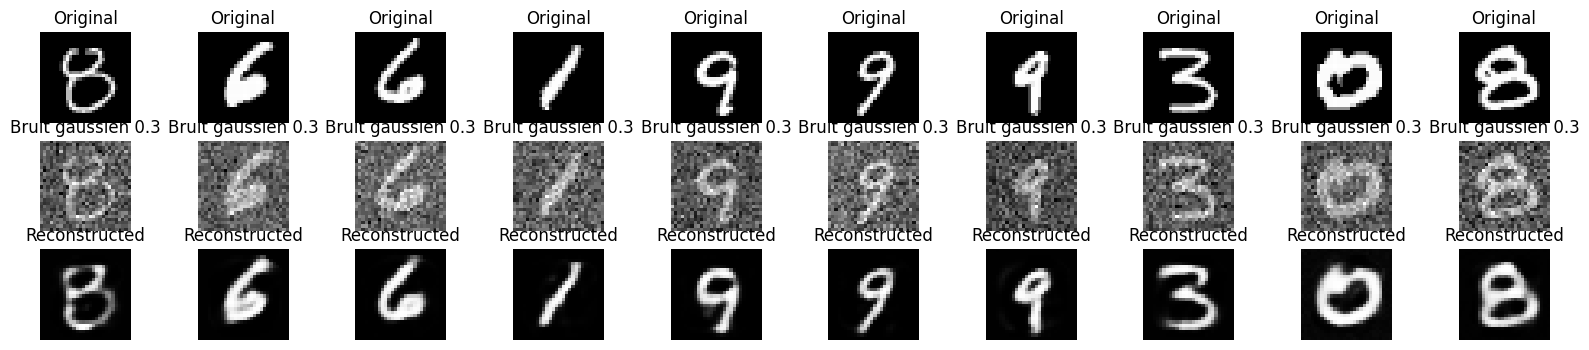

Epoch 12, Loss: 9.5998
Epoch 13, Loss: 8.3132
Epoch 14, Loss: 9.0894
Epoch 15, Loss: 8.2012
Epoch 16, Loss: 8.4667


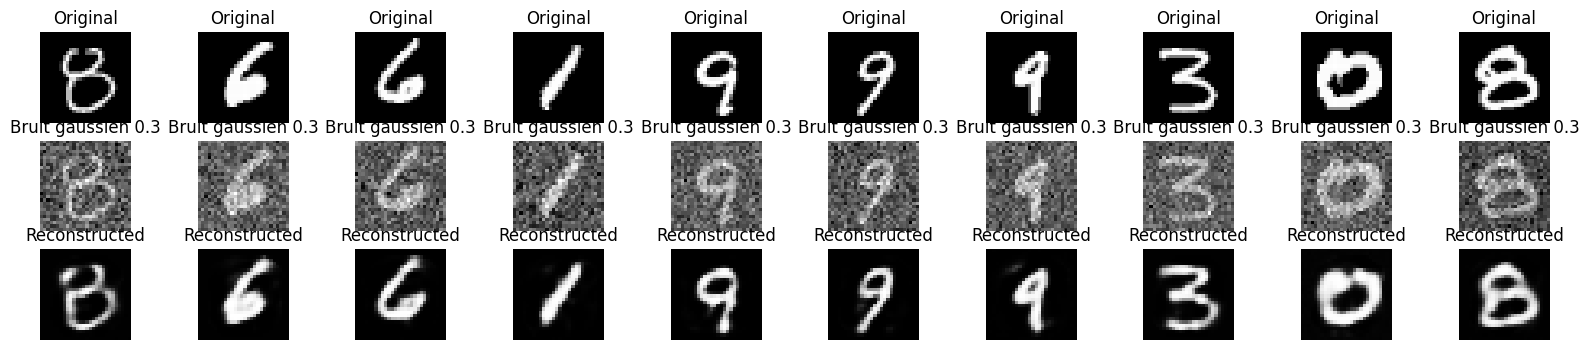

Epoch 17, Loss: 9.2471
Epoch 18, Loss: 8.2272
Epoch 19, Loss: 37.3989
Epoch 20, Loss: 24.8247


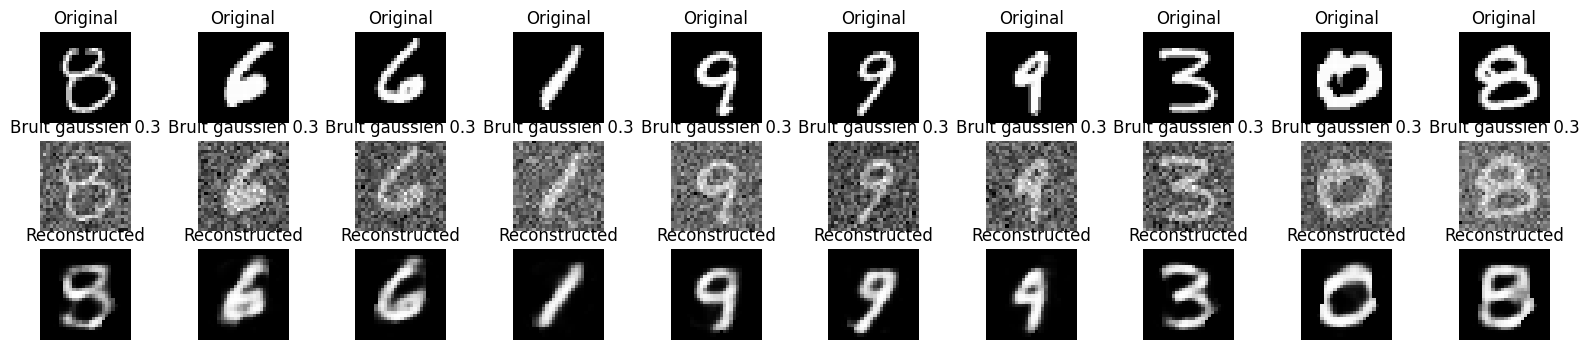

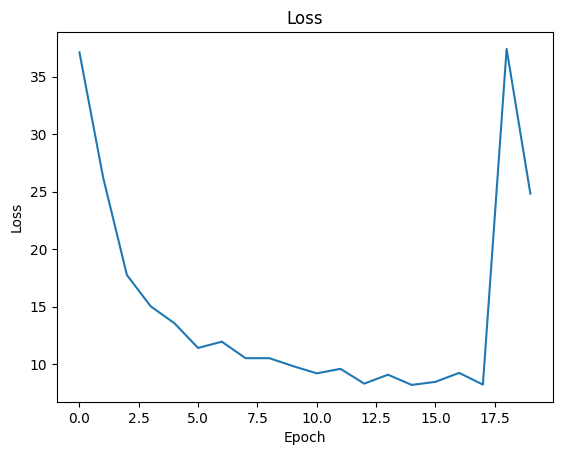

In [265]:
autoencoder = AutoEncoder_simple(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_and_visualize(autoencoder, optimizer, X_train,test_images, batch_size=256, epochs=20, plot=True, bruit=True)

Epoch 1, Loss: 0.2750


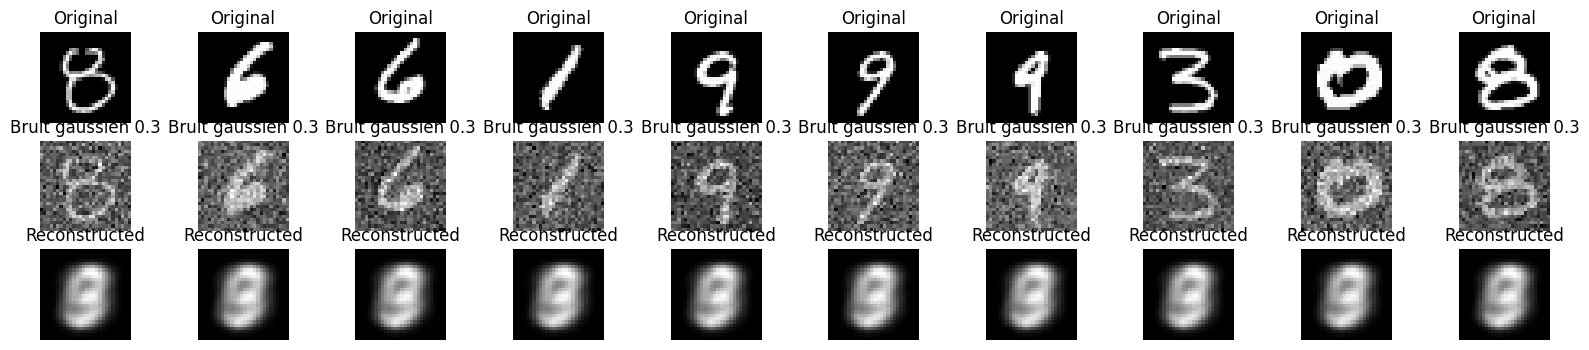

Epoch 2, Loss: 0.2642
Epoch 3, Loss: 0.2434
Epoch 4, Loss: 0.2352
Epoch 5, Loss: 0.2043
Epoch 6, Loss: 0.1997


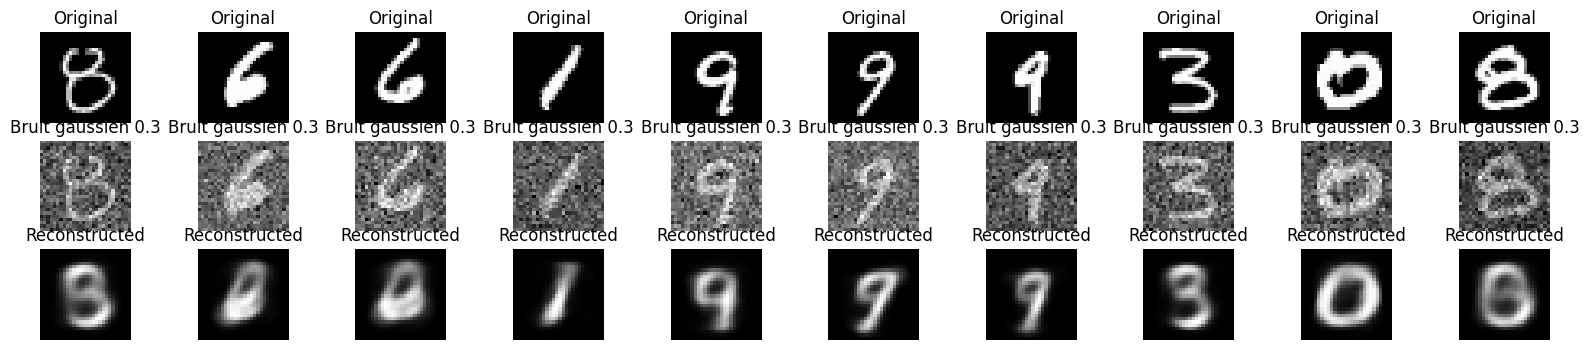

Epoch 7, Loss: 0.1810
Epoch 8, Loss: 0.1764
Epoch 9, Loss: 0.1492
Epoch 10, Loss: 0.1479
Epoch 11, Loss: 0.1501


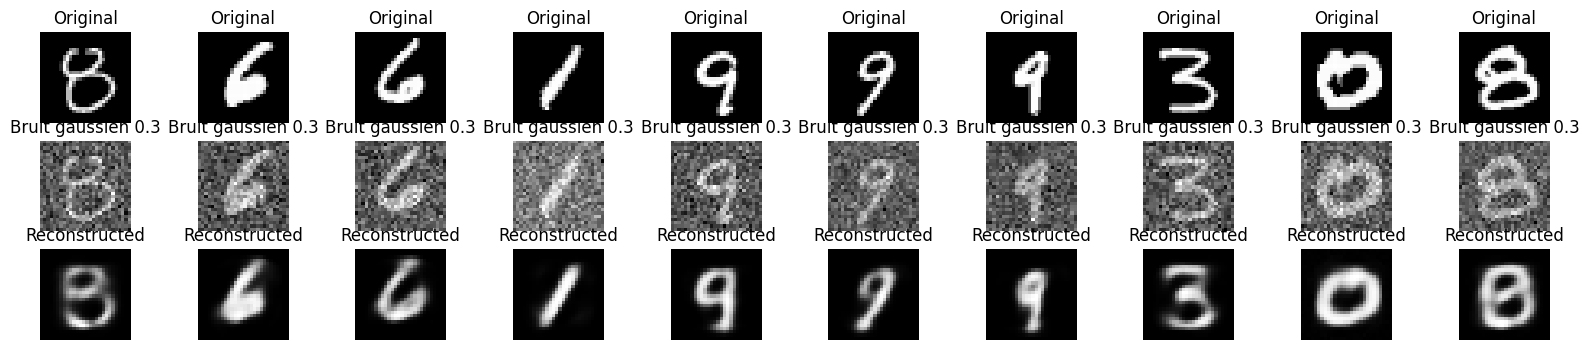

Epoch 12, Loss: 0.1317
Epoch 13, Loss: 0.1328
Epoch 14, Loss: 0.1300
Epoch 15, Loss: 0.1244
Epoch 16, Loss: 0.1246


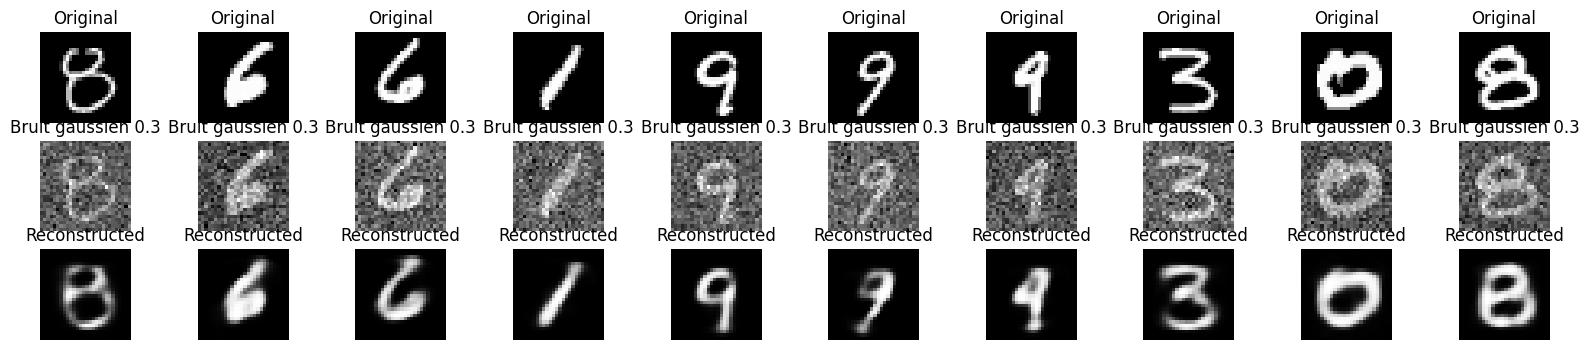

Epoch 17, Loss: 0.1136
Epoch 18, Loss: 0.1147
Epoch 19, Loss: 0.1135
Epoch 20, Loss: 0.1100


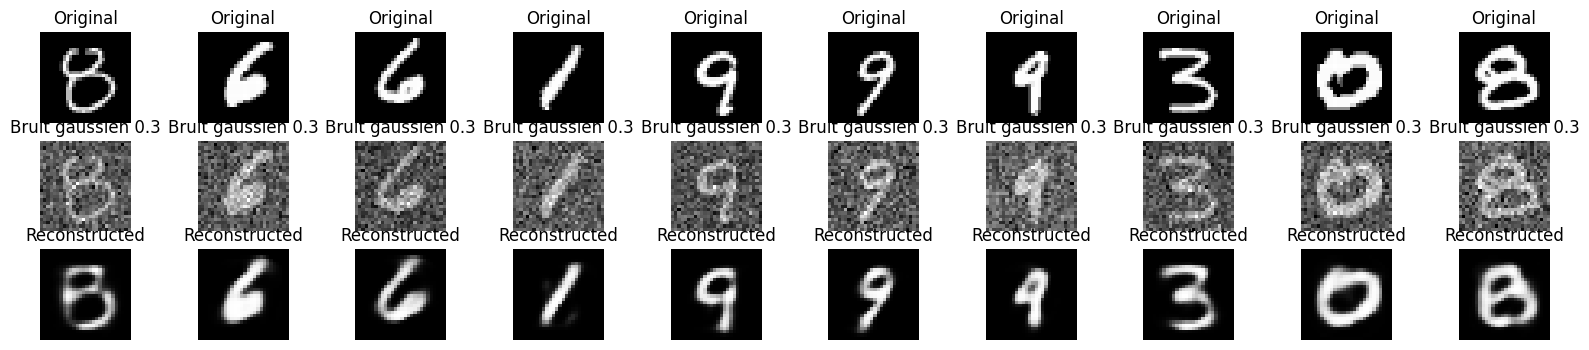

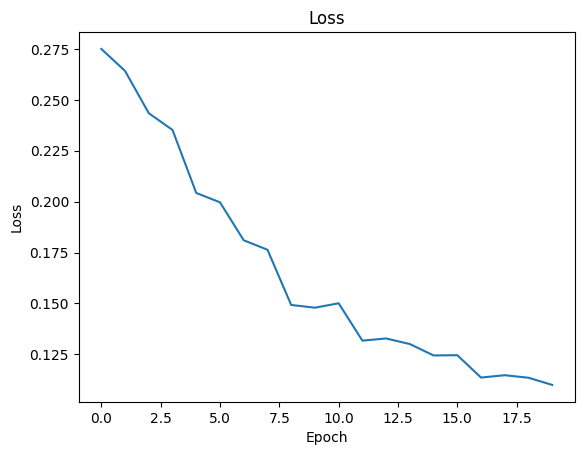

In [266]:
autoencoder = AutoEncoder_simple(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-4)

train_and_visualize(autoencoder, optimizer, X_train,test_images, batch_size=256, epochs=20, plot=True, bruit=True)

Epoch 1, Loss: 0.2627


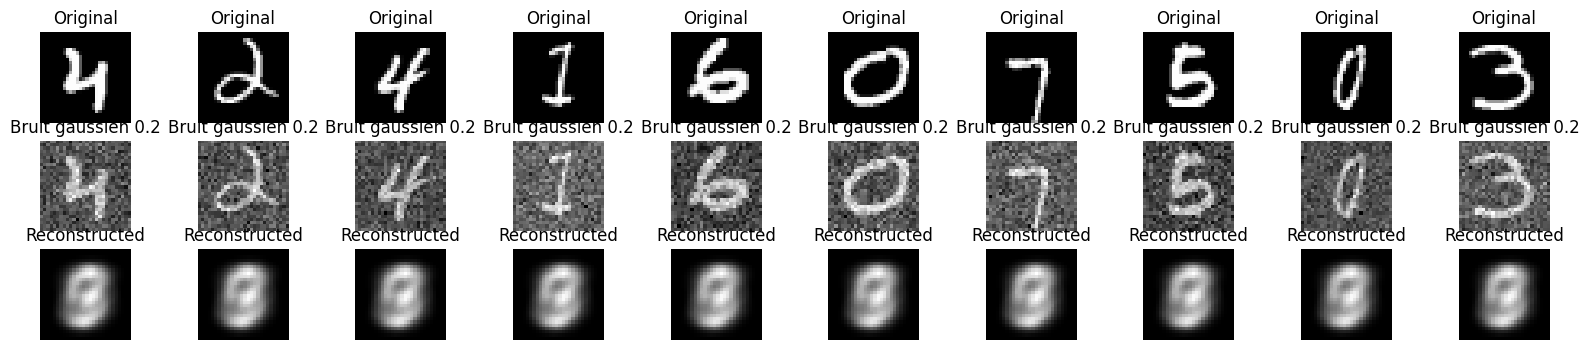

Epoch 2, Loss: 0.2627
Epoch 3, Loss: 0.2611
Epoch 4, Loss: 0.2350
Epoch 5, Loss: 0.2272
Epoch 6, Loss: 0.2016


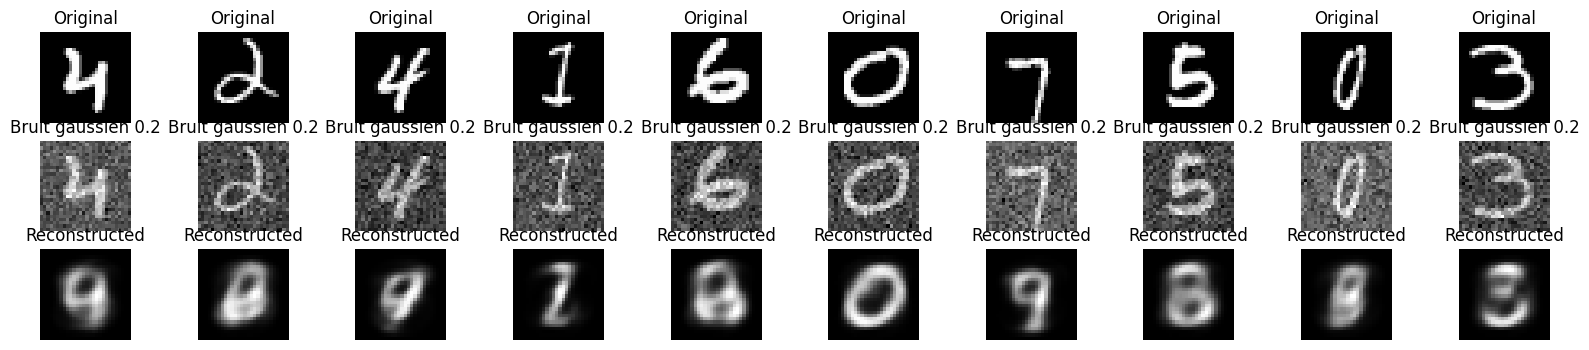

Epoch 7, Loss: 0.1827
Epoch 8, Loss: 0.1677
Epoch 9, Loss: 0.1589
Epoch 10, Loss: 0.1506
Epoch 11, Loss: 0.1513


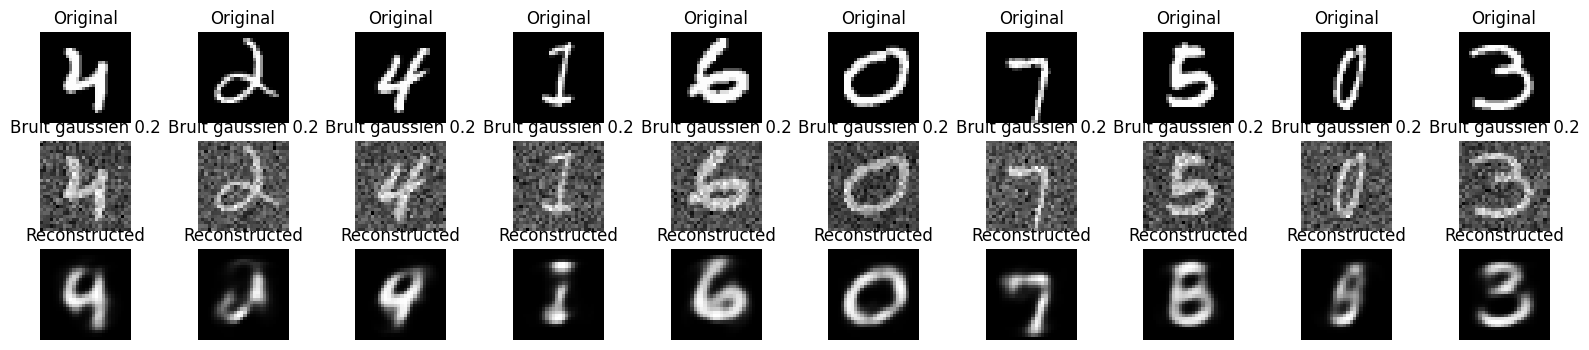

Epoch 12, Loss: 0.1474
Epoch 13, Loss: 0.1435
Epoch 14, Loss: 0.1301
Epoch 15, Loss: 0.1316
Epoch 16, Loss: 0.1350


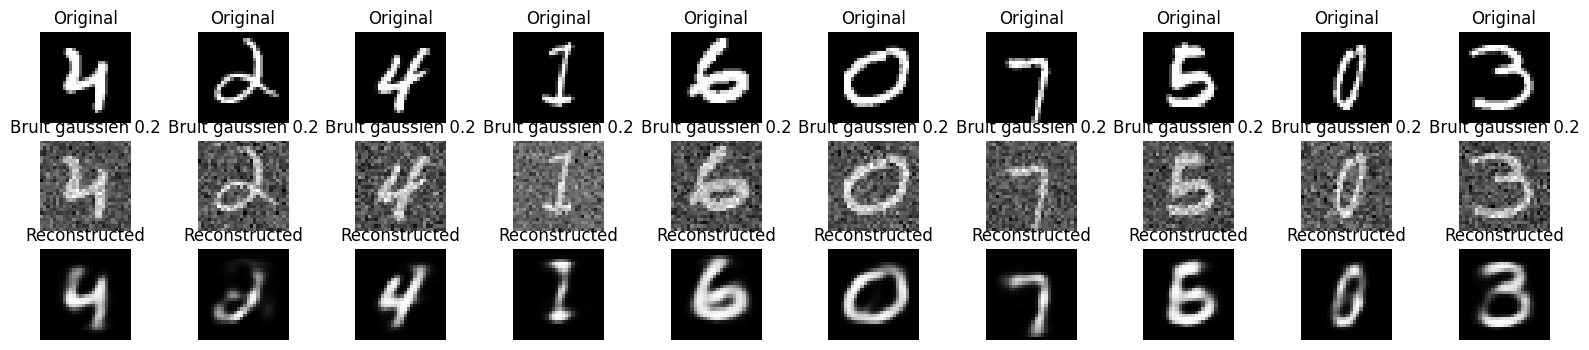

Epoch 17, Loss: 0.1145
Epoch 18, Loss: 0.1165
Epoch 19, Loss: 0.1156
Epoch 20, Loss: 0.1147


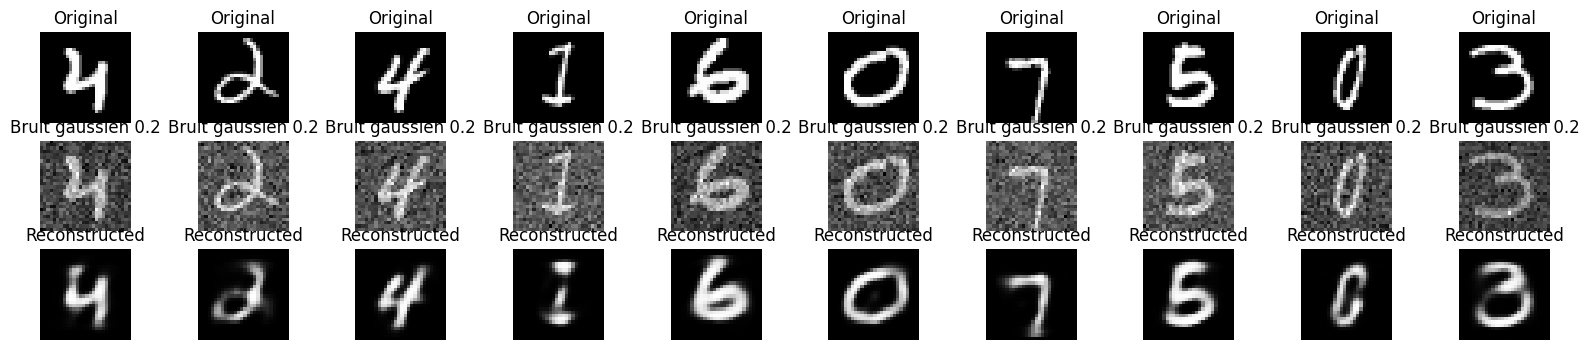

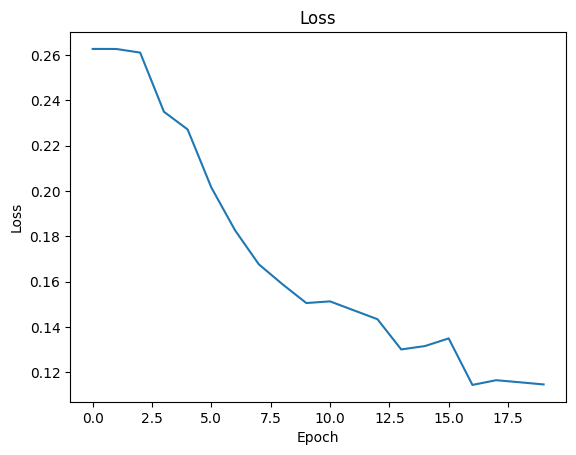

In [148]:
autoencoder = AutoEncoder_simple(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-4)

train_and_visualize(autoencoder, optimizer, X_train, test_images,batch_size=256, epochs=20, plot=True, bruit=True)

Epoch 1, Loss: 0.2573


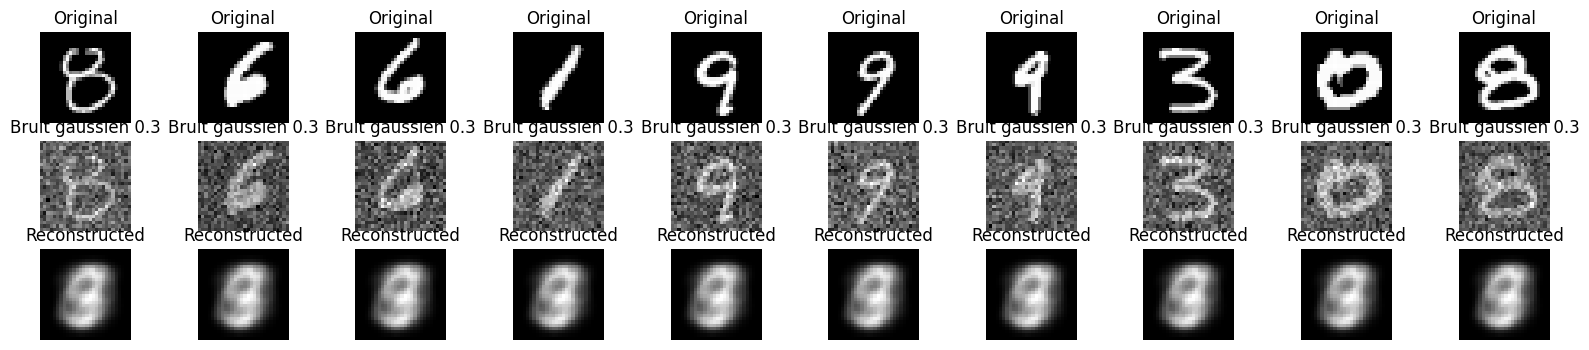

Epoch 2, Loss: 0.2574
Epoch 3, Loss: 0.2657
Epoch 4, Loss: 0.2677
Epoch 5, Loss: 0.2612
Epoch 6, Loss: 0.2579


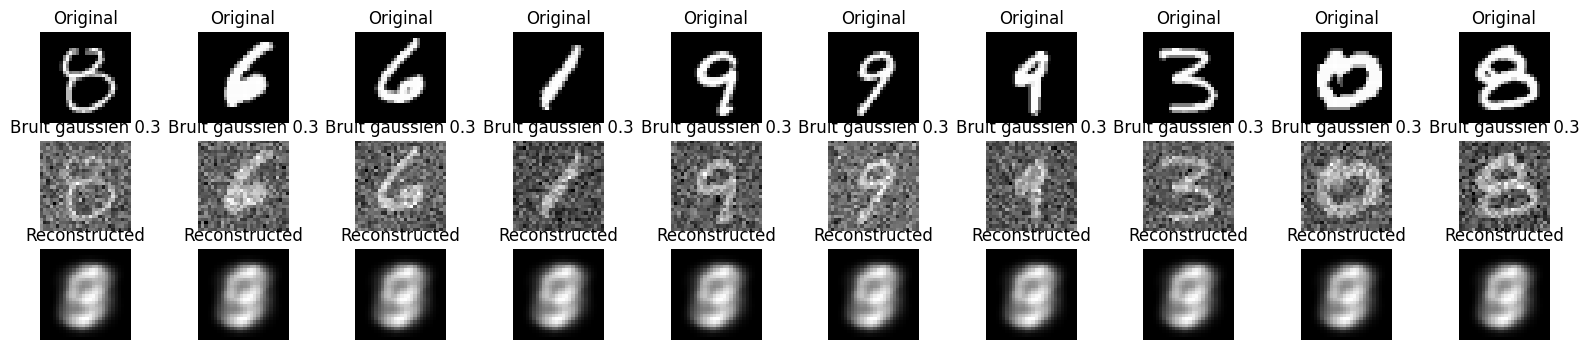

Epoch 7, Loss: 0.2549
Epoch 8, Loss: 0.2537
Epoch 9, Loss: 0.2627
Epoch 10, Loss: 0.2548
Epoch 11, Loss: 0.2681


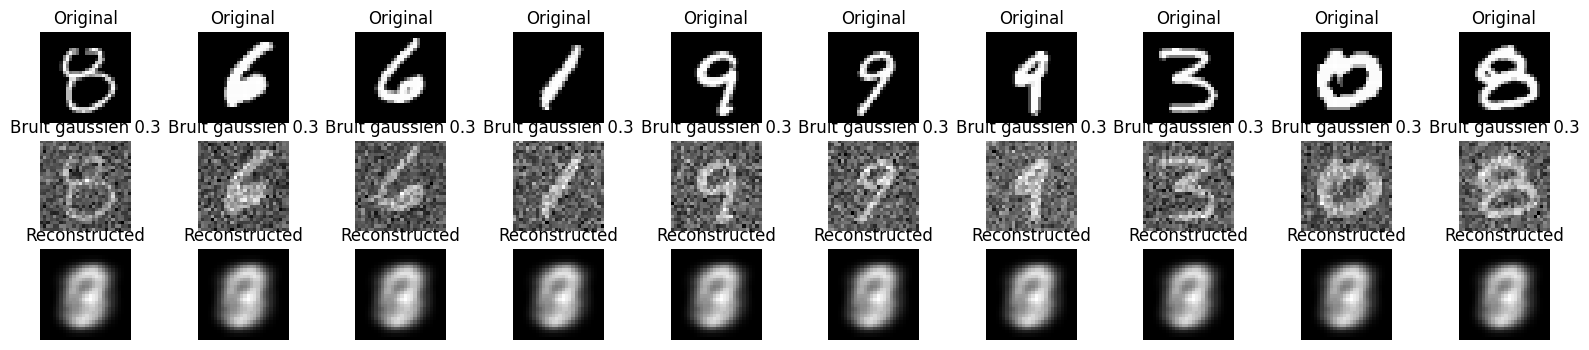

Epoch 12, Loss: 0.2657
Epoch 13, Loss: 0.2608
Epoch 14, Loss: 0.2595
Epoch 15, Loss: 0.2682
Epoch 16, Loss: 0.2550


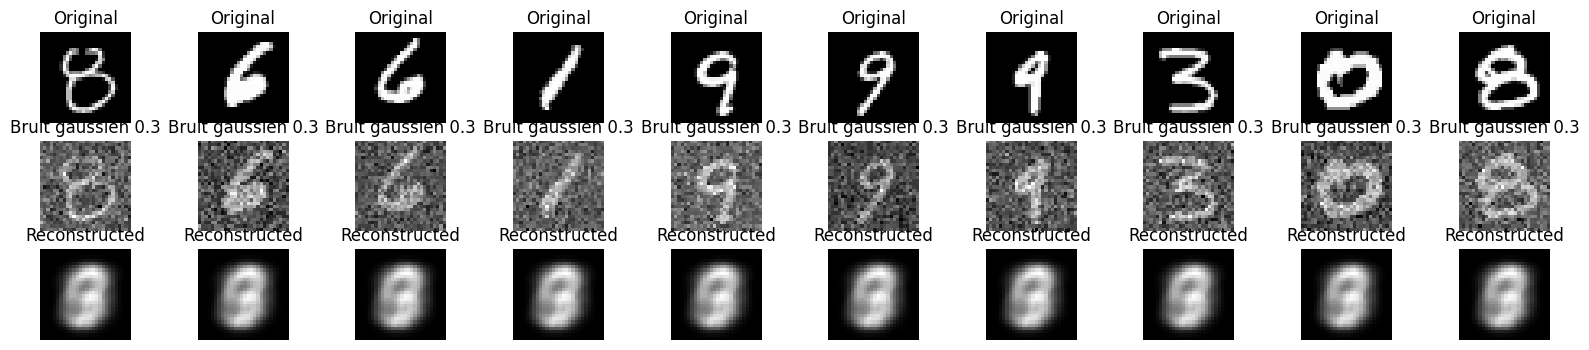

Epoch 17, Loss: 0.2665
Epoch 18, Loss: 0.2623
Epoch 19, Loss: 0.2616
Epoch 20, Loss: 0.2609


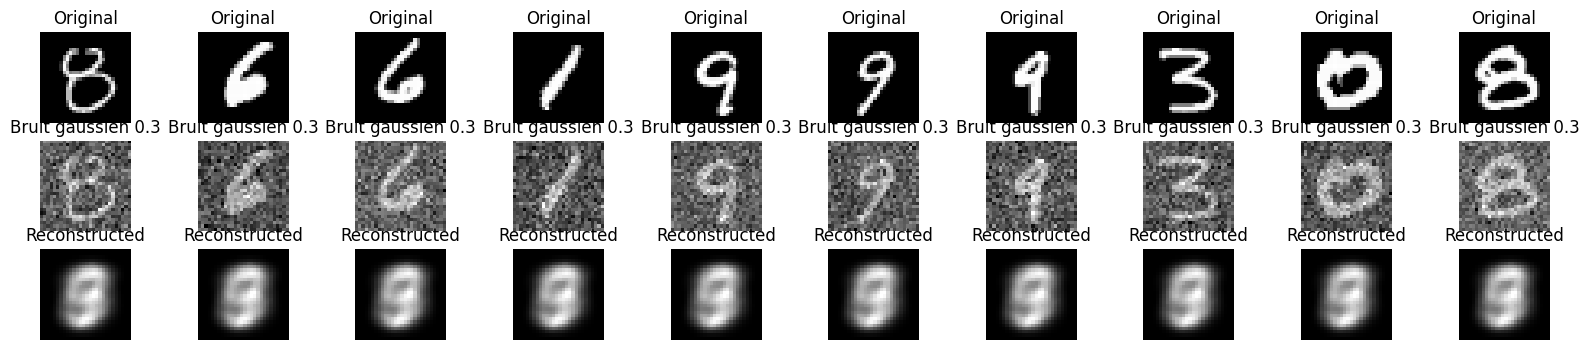

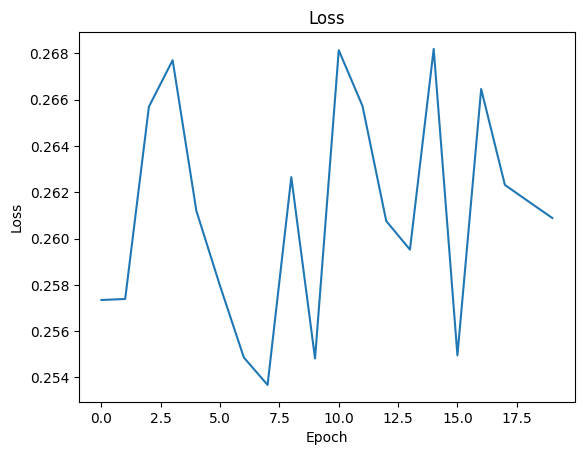

In [267]:
#0.3
autoencoder = AutoEncoder_complex(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-4)

train_and_visualize(autoencoder, optimizer, X_train, test_images, batch_size=256, epochs=20, plot=True, bruit=True)

Epoch 1, Loss: 0.2590


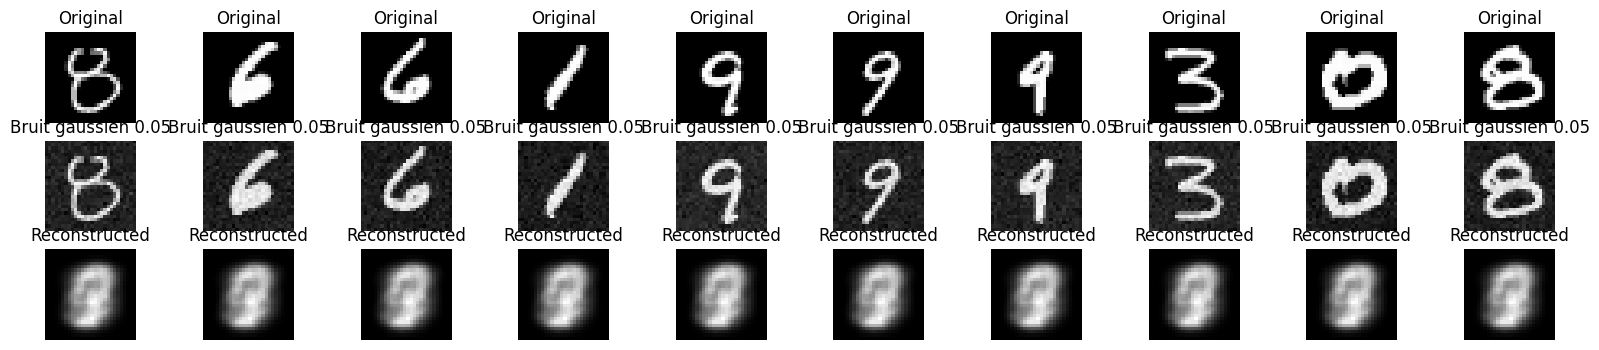

Epoch 2, Loss: 0.2630
Epoch 3, Loss: 0.2606
Epoch 4, Loss: 0.2523
Epoch 5, Loss: 0.2626
Epoch 6, Loss: 0.2565


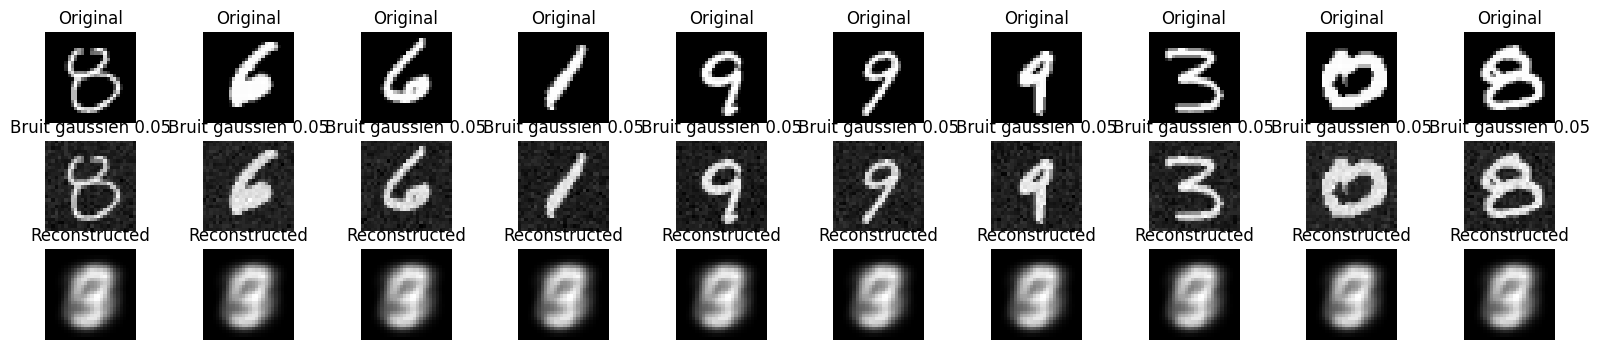

Epoch 7, Loss: 0.2554
Epoch 8, Loss: 0.2616
Epoch 9, Loss: 0.2541
Epoch 10, Loss: 0.2671
Epoch 11, Loss: 0.2641


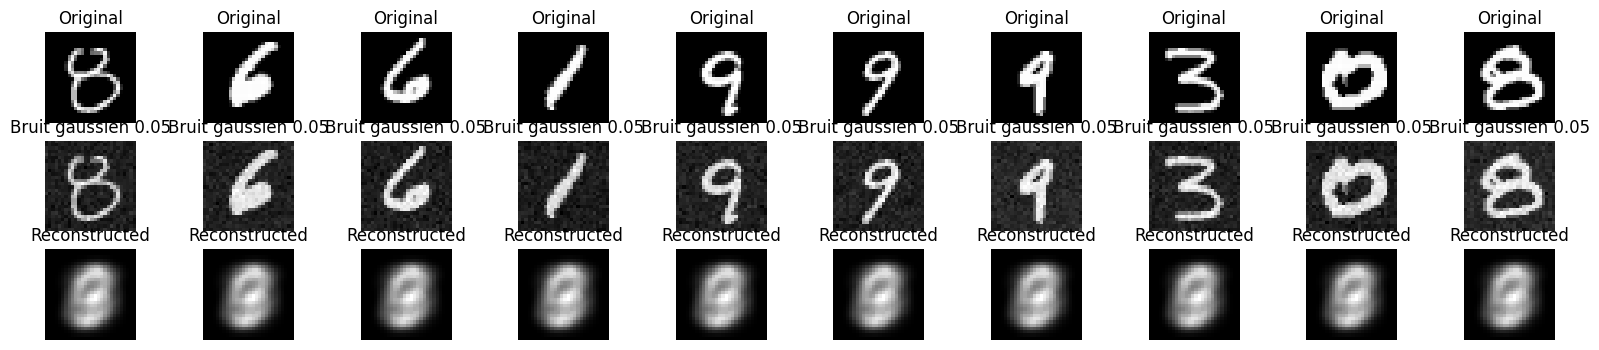

Epoch 12, Loss: 0.2650
Epoch 13, Loss: 0.2649
Epoch 14, Loss: 0.2674
Epoch 15, Loss: 0.2627
Epoch 16, Loss: 0.2576


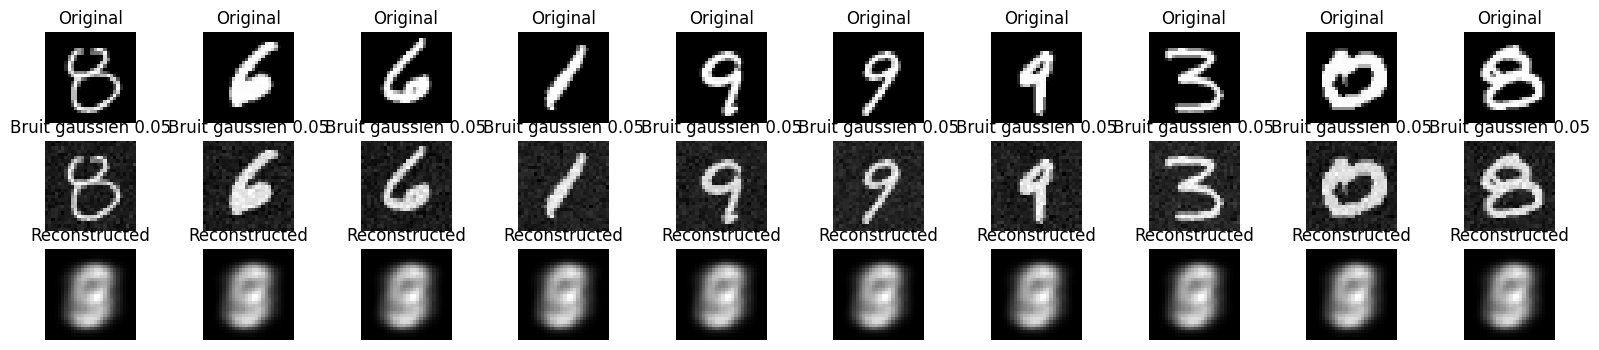

KeyboardInterrupt: 

In [273]:
# 0.05
autoencoder = AutoEncoder_complex(DIM_IN=784, fc_act=TanH())
full_autoencoder = Sequential(
            *autoencoder.encoder.modules,
            *autoencoder.decoder.modules
        )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-4)

train_and_visualize(autoencoder, optimizer, X_train,test_images, batch_size=256, epochs=20, plot=True, bruit=True)

## USPS 

Epoch 1, Loss: 119.9834


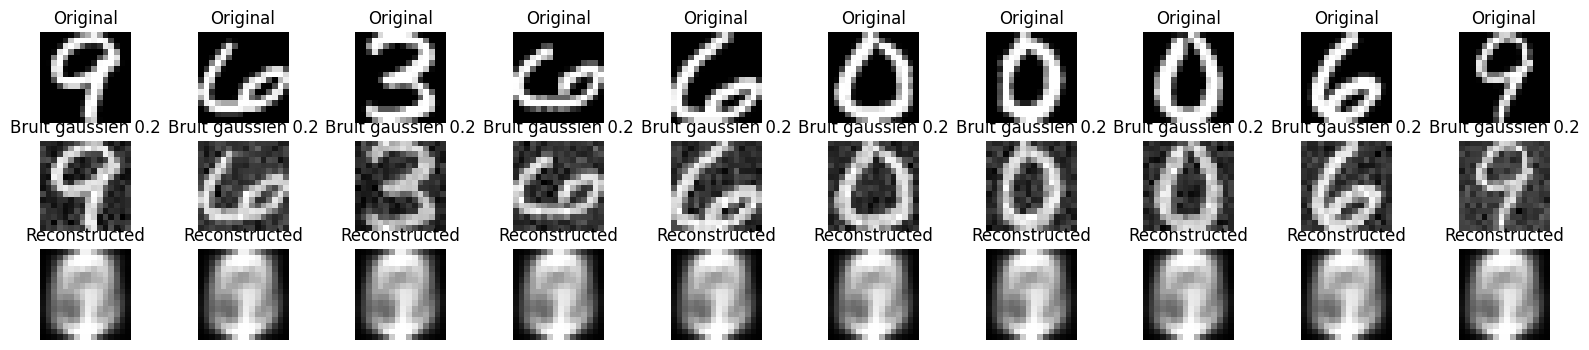

Epoch 2, Loss: 121.3910
Epoch 3, Loss: 94.0035
Epoch 4, Loss: 95.2772
Epoch 5, Loss: 86.4648
Epoch 6, Loss: 72.9813


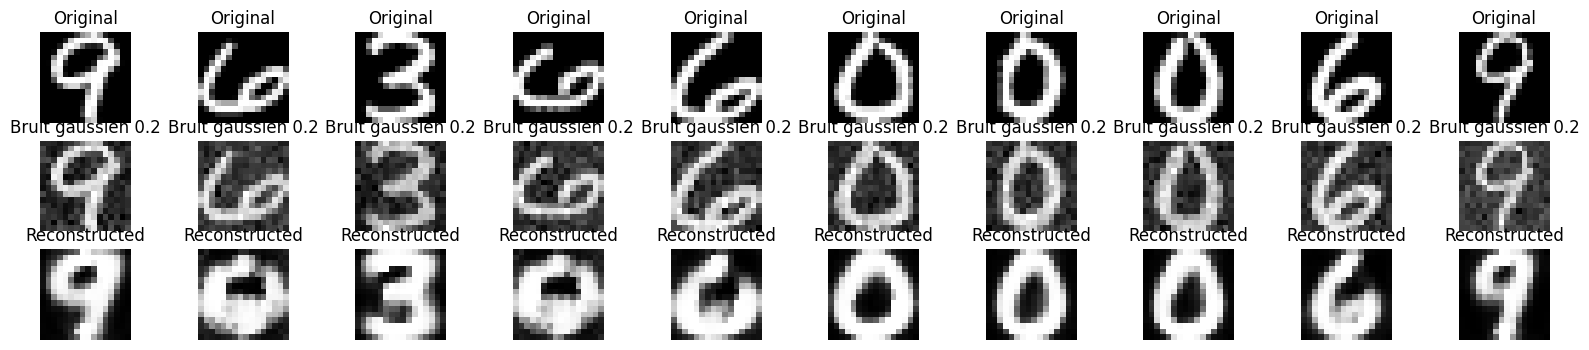

Epoch 7, Loss: 72.3087
Epoch 8, Loss: 70.4060
Epoch 9, Loss: 64.8518
Epoch 10, Loss: 64.0695
Epoch 11, Loss: 63.3120


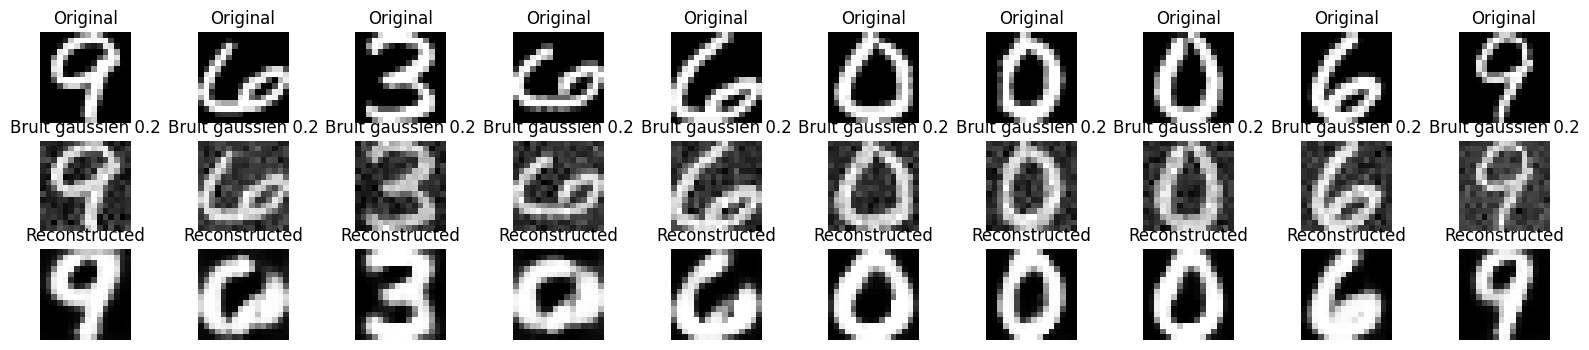

Epoch 12, Loss: 60.1093
Epoch 13, Loss: 62.6148
Epoch 14, Loss: 61.1069
Epoch 15, Loss: 66.8882
Epoch 16, Loss: 61.0270


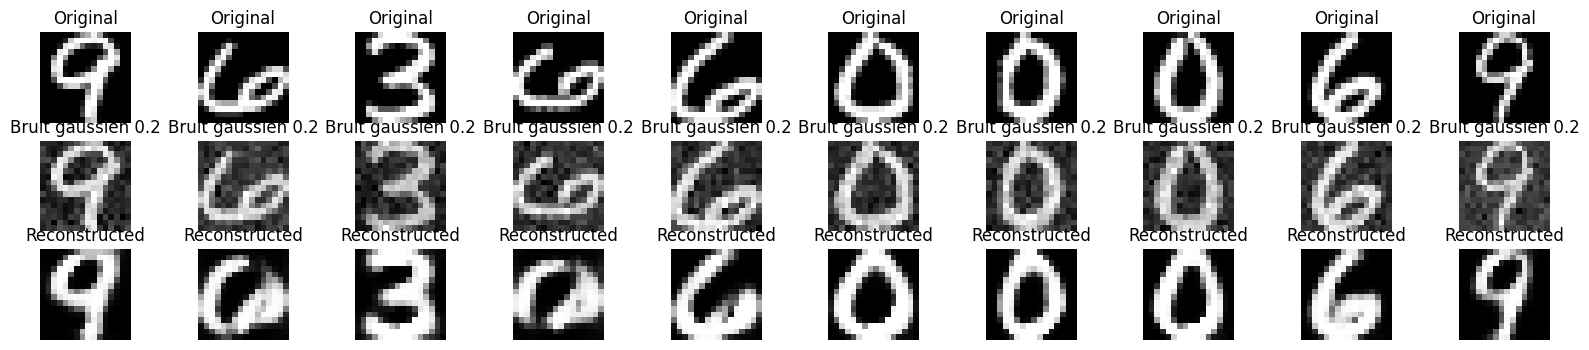

Epoch 17, Loss: 67.8151
Epoch 18, Loss: 61.3881
Epoch 19, Loss: 64.1935
Epoch 20, Loss: 56.7376
Epoch 21, Loss: 59.5809


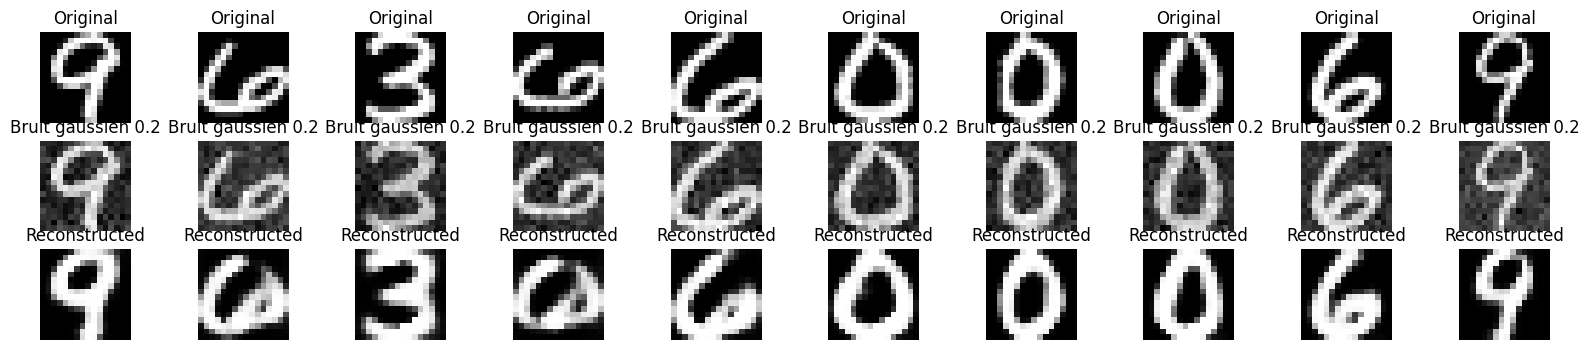

Epoch 22, Loss: 57.2808
Epoch 23, Loss: 58.6458
Epoch 24, Loss: 53.6913
Epoch 25, Loss: 59.7551
Epoch 26, Loss: 55.3941


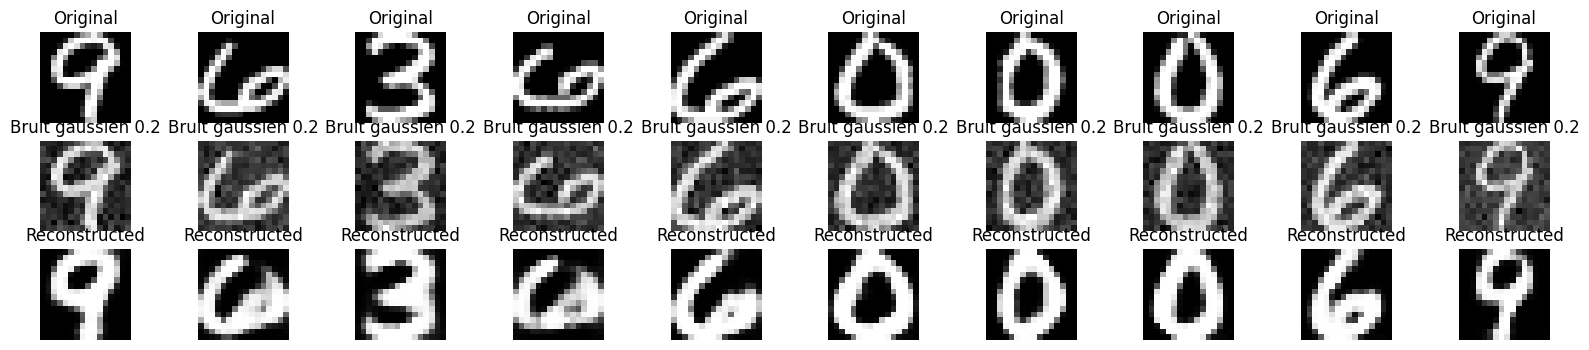

Epoch 27, Loss: 55.7870
Epoch 28, Loss: 58.0030
Epoch 29, Loss: 60.4942
Epoch 30, Loss: 56.3511


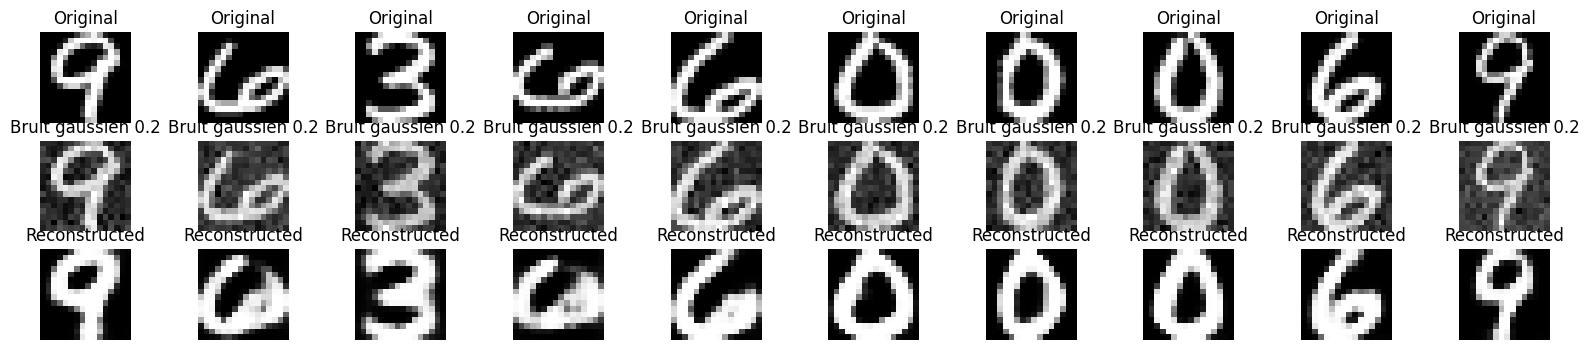

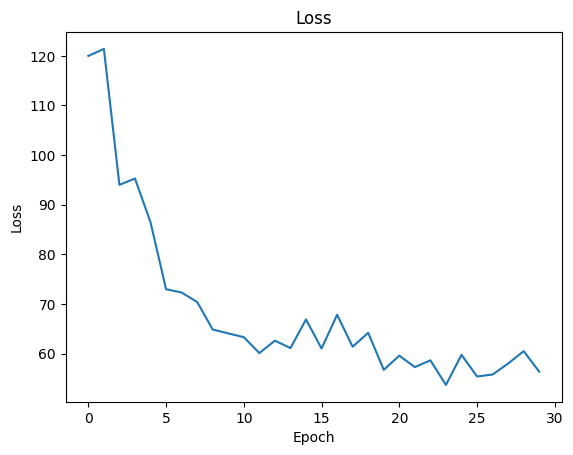

In [145]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 116.7979


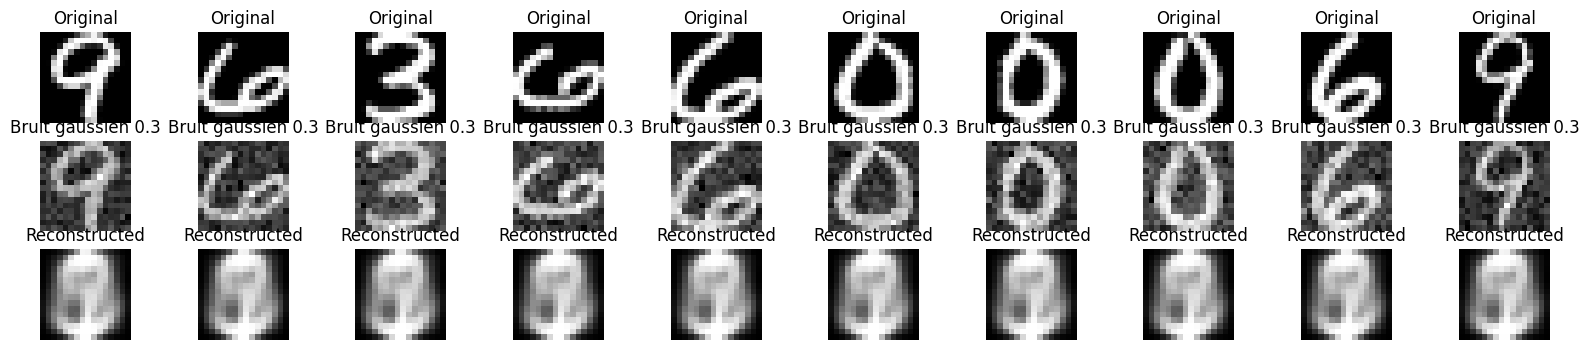

Epoch 2, Loss: 108.8207
Epoch 3, Loss: 89.5578
Epoch 4, Loss: 85.4693
Epoch 5, Loss: 82.5967
Epoch 6, Loss: 77.2905


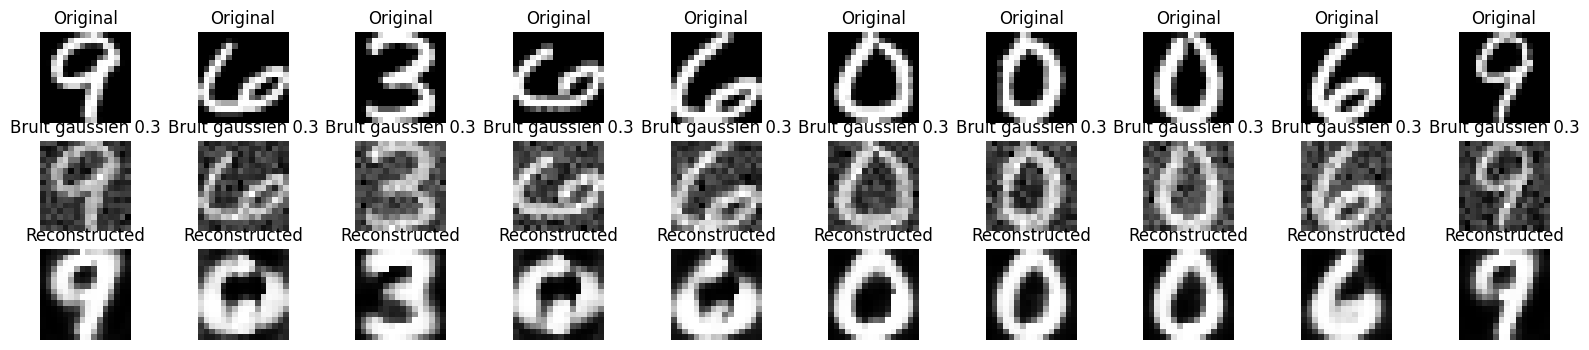

Epoch 7, Loss: 77.7514
Epoch 8, Loss: 72.4513
Epoch 9, Loss: 69.7362
Epoch 10, Loss: 75.2188
Epoch 11, Loss: 70.8610


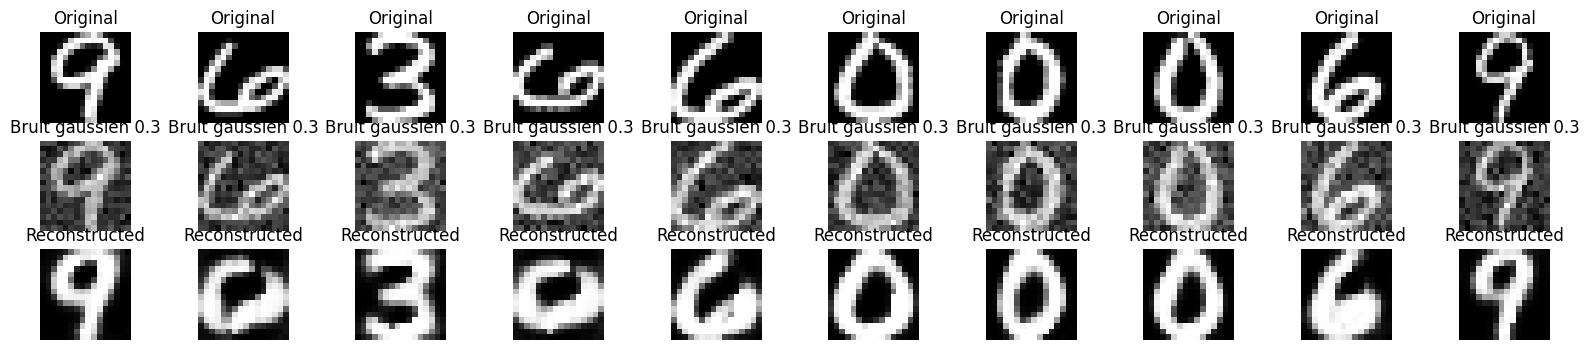

Epoch 12, Loss: 65.2592
Epoch 13, Loss: 63.5742
Epoch 14, Loss: 65.2659
Epoch 15, Loss: 64.0139
Epoch 16, Loss: 57.6617


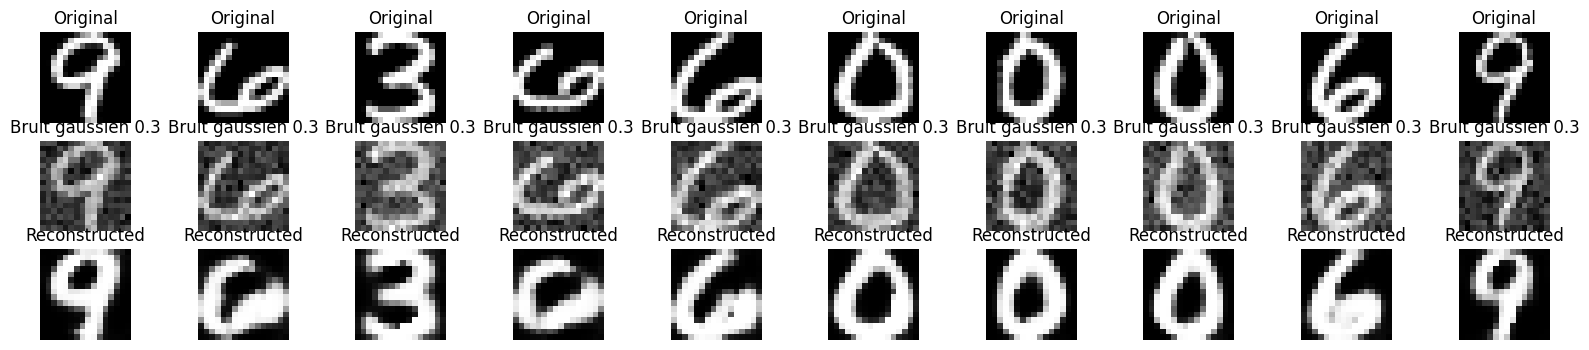

Epoch 17, Loss: 60.1295
Epoch 18, Loss: 60.9077
Epoch 19, Loss: 63.4880
Epoch 20, Loss: 59.2216
Epoch 21, Loss: 54.9109


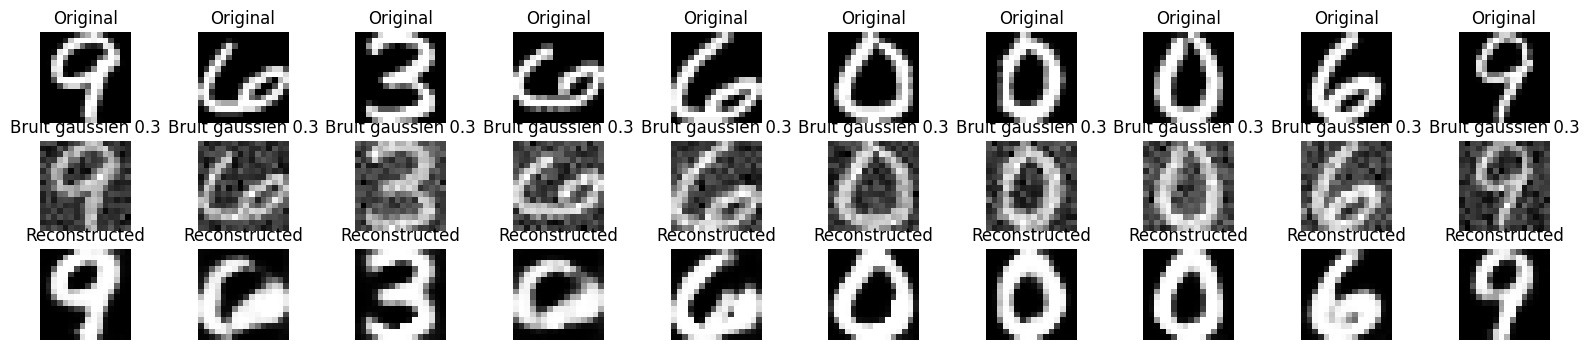

Epoch 22, Loss: 64.6597
Epoch 23, Loss: 50.6712
Epoch 24, Loss: 56.5123
Epoch 25, Loss: 52.6102
Epoch 26, Loss: 54.8733


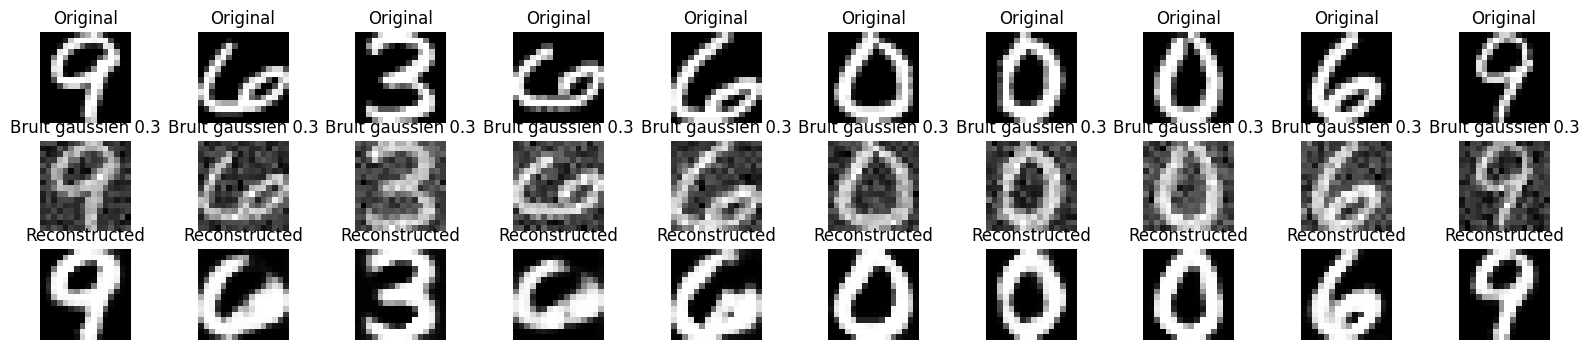

Epoch 27, Loss: 57.1327
Epoch 28, Loss: 49.1187
Epoch 29, Loss: 57.9012
Epoch 30, Loss: 54.7152


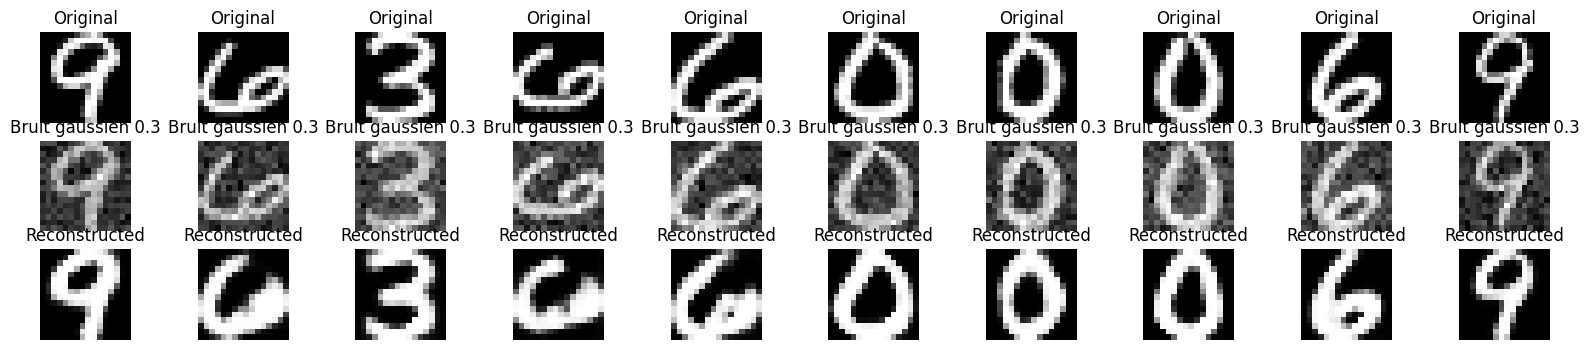

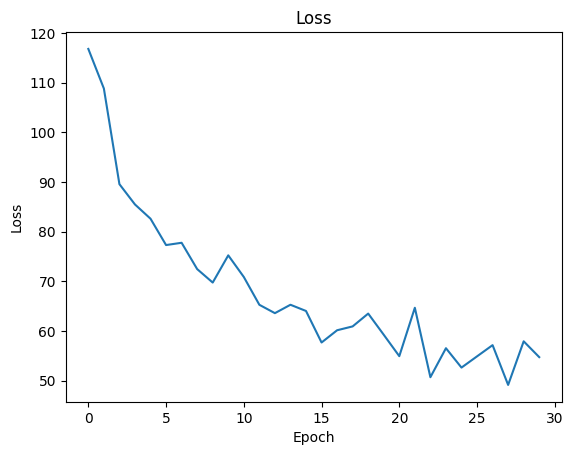

In [224]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 120.2870


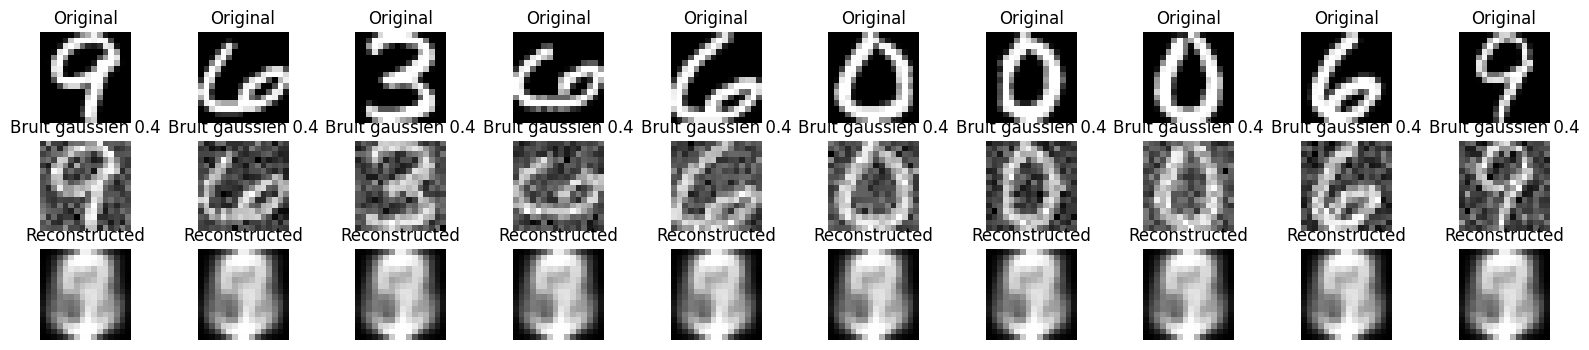

Epoch 2, Loss: 96.5228
Epoch 3, Loss: 95.3970
Epoch 4, Loss: 91.0737
Epoch 5, Loss: 75.7490
Epoch 6, Loss: 77.0184


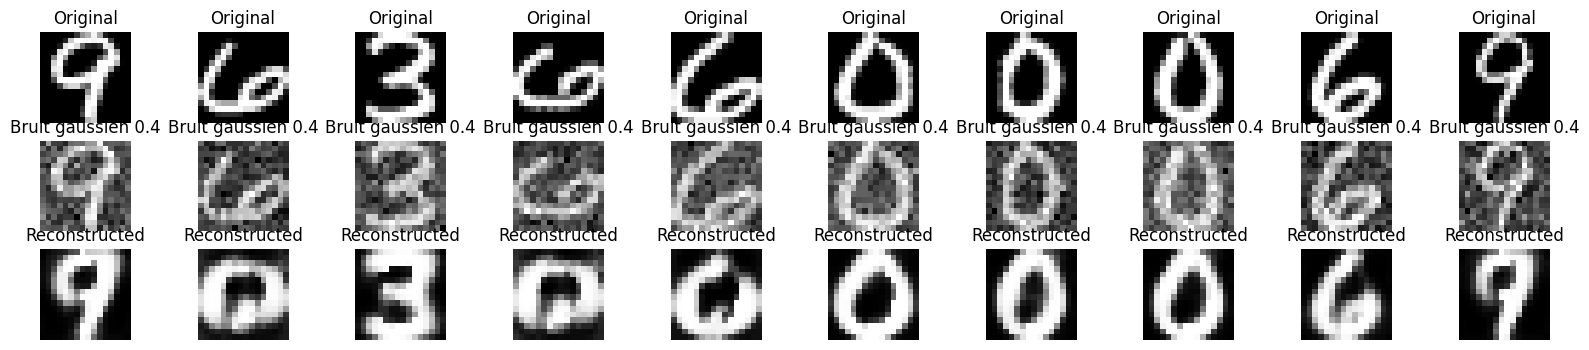

Epoch 7, Loss: 72.7006
Epoch 8, Loss: 75.6474
Epoch 9, Loss: 62.5508
Epoch 10, Loss: 66.8907
Epoch 11, Loss: 67.6721


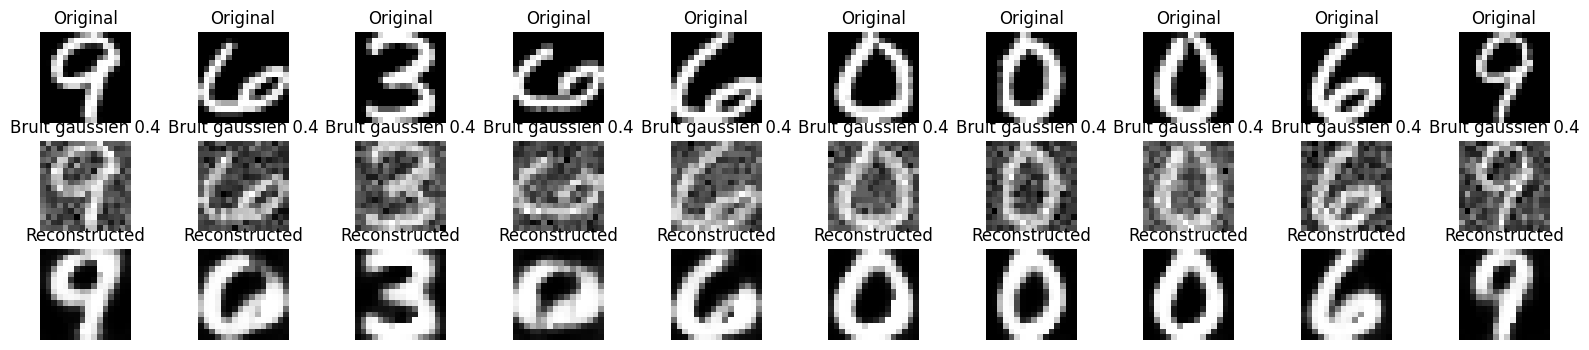

Epoch 12, Loss: 65.5420
Epoch 13, Loss: 63.7335
Epoch 14, Loss: 68.5985
Epoch 15, Loss: 60.9809
Epoch 16, Loss: 57.2603


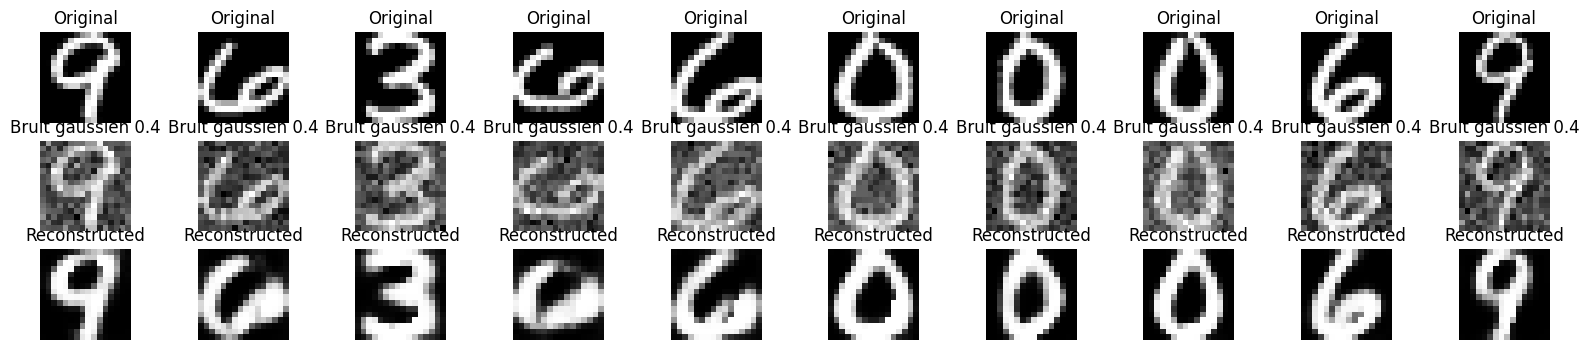

Epoch 17, Loss: 60.9064
Epoch 18, Loss: 59.6059
Epoch 19, Loss: 59.8688
Epoch 20, Loss: 61.9356
Epoch 21, Loss: 63.9604


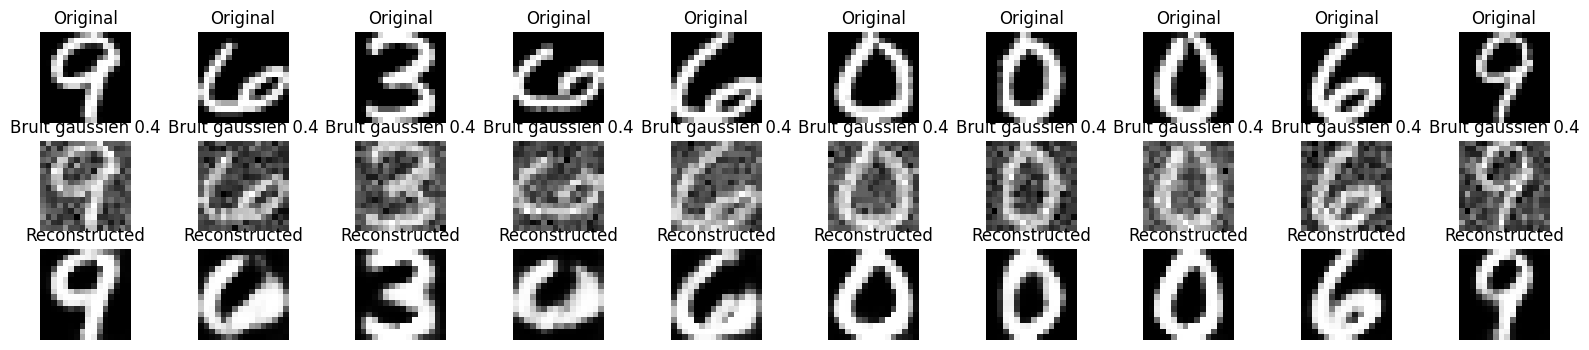

Epoch 22, Loss: 65.1369
Epoch 23, Loss: 60.7596
Epoch 24, Loss: 63.6744
Epoch 25, Loss: 58.3839
Epoch 26, Loss: 55.7057


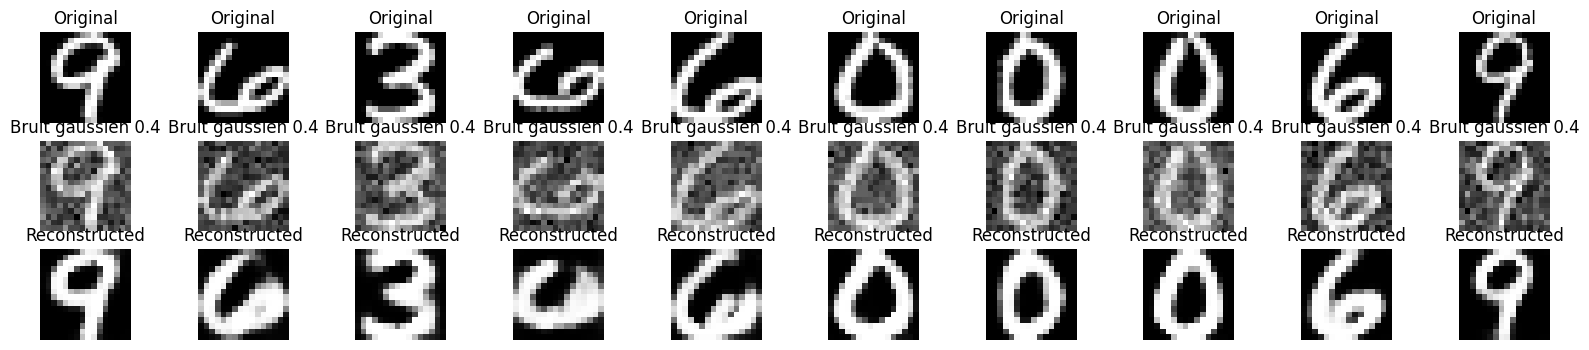

Epoch 27, Loss: 54.0492
Epoch 28, Loss: 58.8312
Epoch 29, Loss: 52.9897
Epoch 30, Loss: 58.1900


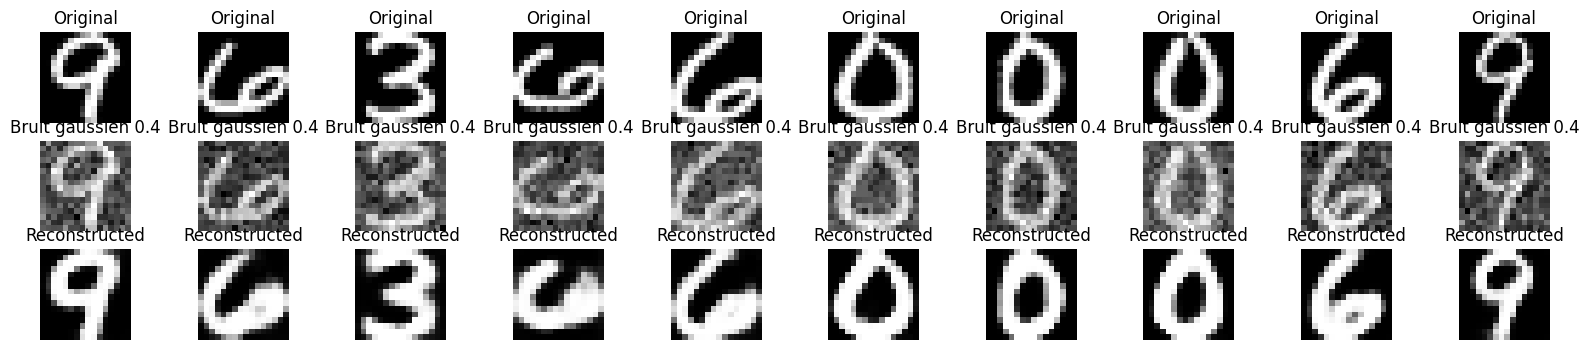

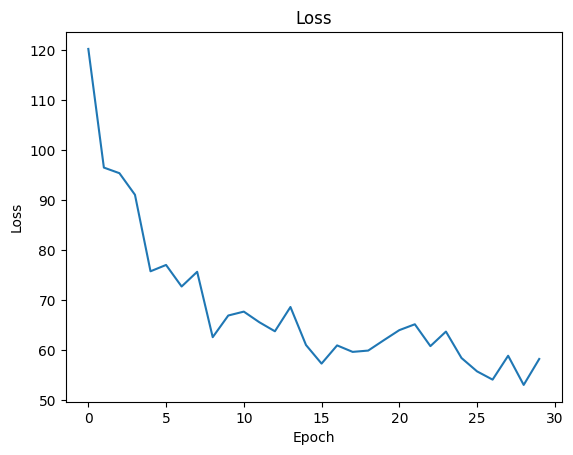

In [228]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, MSELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.2417


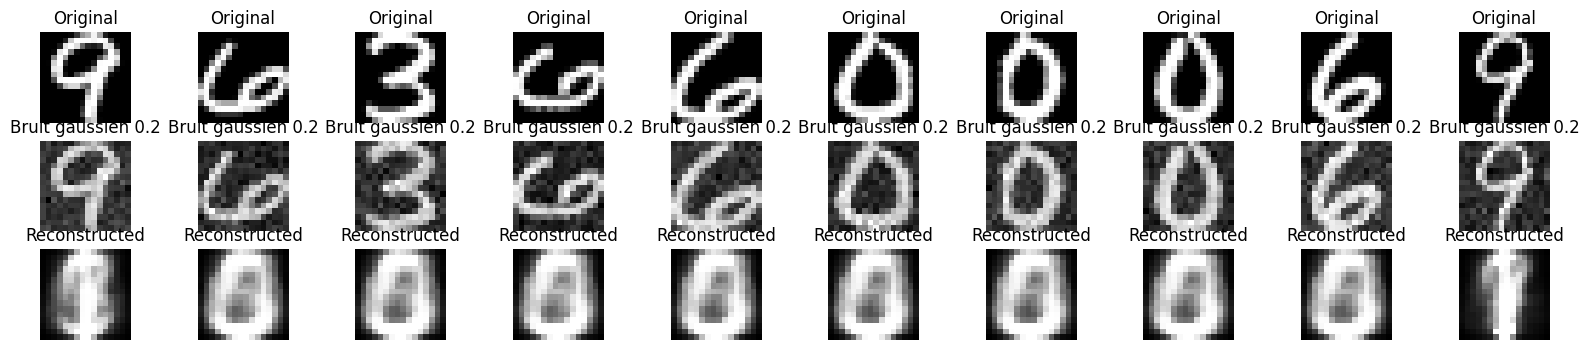

Epoch 2, Loss: 0.1987
Epoch 3, Loss: 0.0768
Epoch 4, Loss: -0.0960
Epoch 5, Loss: -0.0855
Epoch 6, Loss: 0.1023


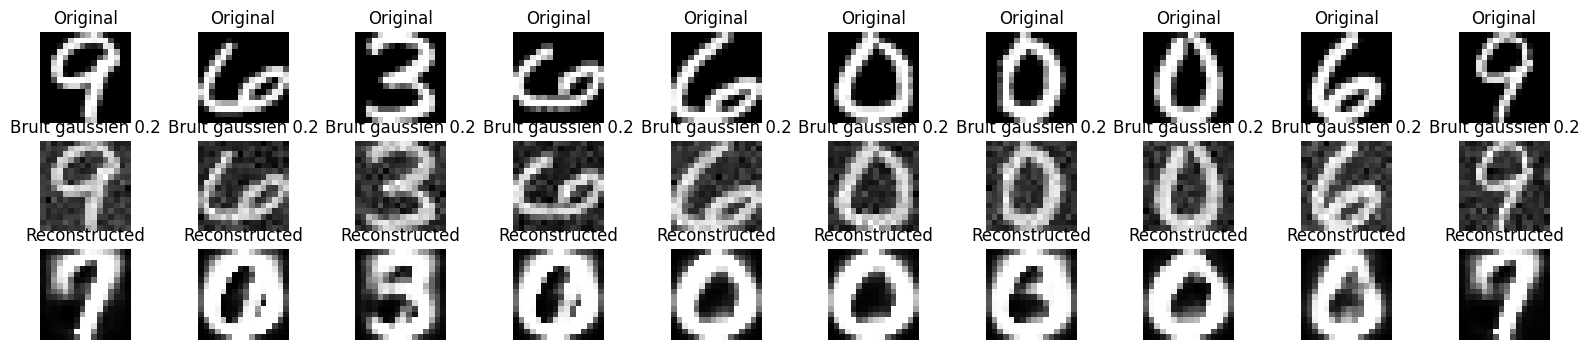

Epoch 7, Loss: -0.2287
Epoch 8, Loss: -0.1921
Epoch 9, Loss: -0.2875
Epoch 10, Loss: -0.0729
Epoch 11, Loss: -0.2875


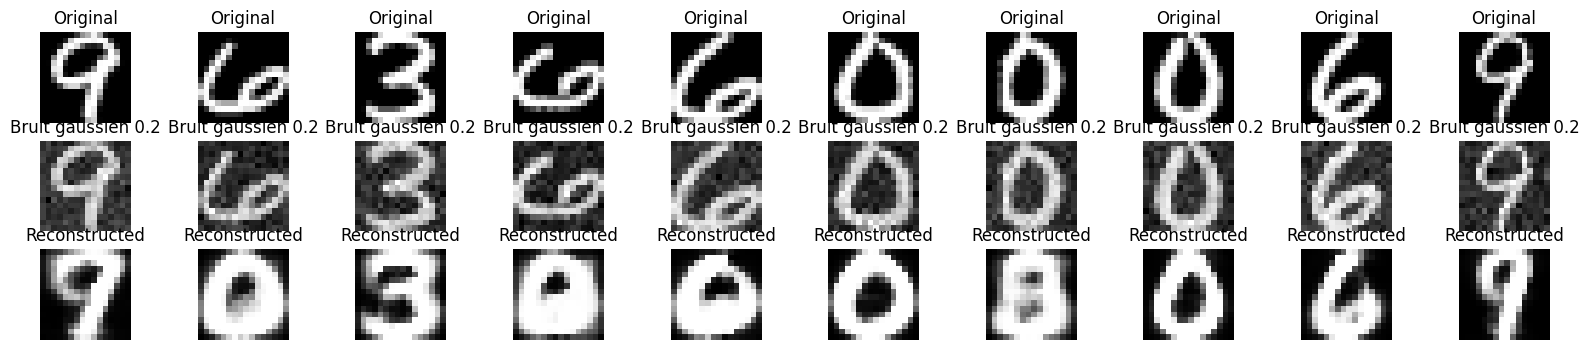

Epoch 12, Loss: -0.2310
Epoch 13, Loss: -0.3537
Epoch 14, Loss: -0.3556
Epoch 15, Loss: -0.2727
Epoch 16, Loss: -0.4060


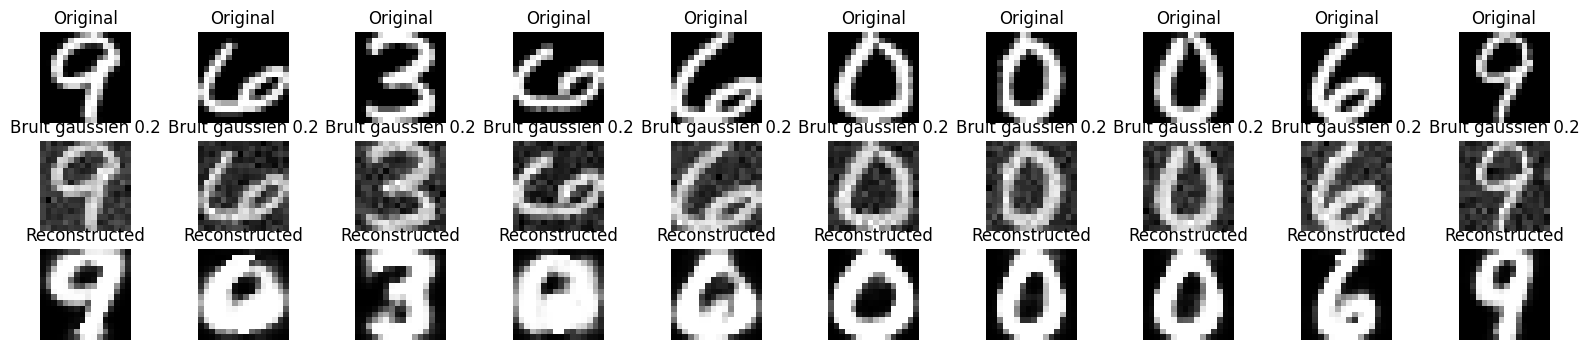

Epoch 17, Loss: -0.5164
Epoch 18, Loss: -0.4871
Epoch 19, Loss: -0.4347
Epoch 20, Loss: -0.5323
Epoch 21, Loss: -0.5248


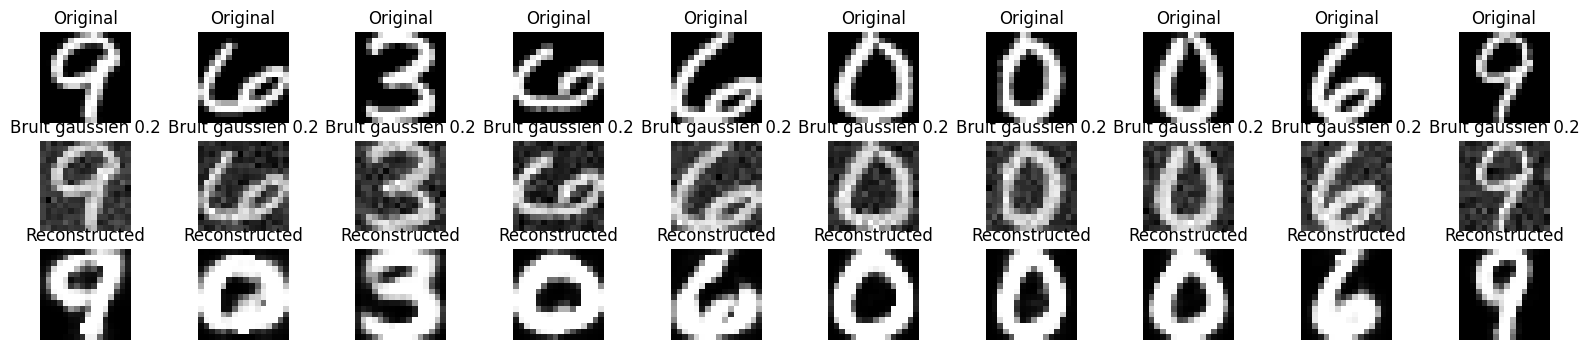

Epoch 22, Loss: -0.5248
Epoch 23, Loss: -0.3493
Epoch 24, Loss: -0.4883
Epoch 25, Loss: -0.3979
Epoch 26, Loss: -0.4997


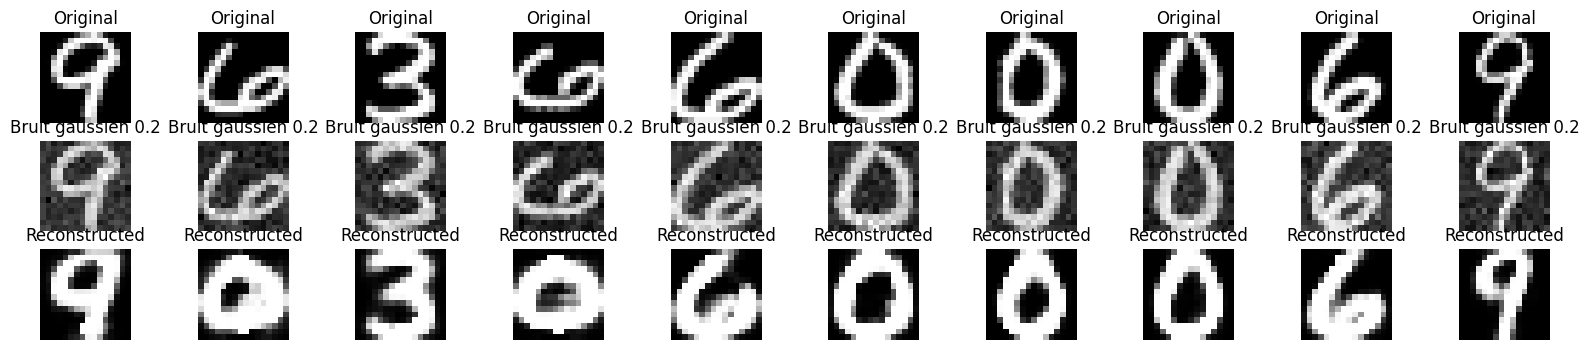

Epoch 27, Loss: -0.4518
Epoch 28, Loss: -0.5296
Epoch 29, Loss: -0.4673
Epoch 30, Loss: -0.5990


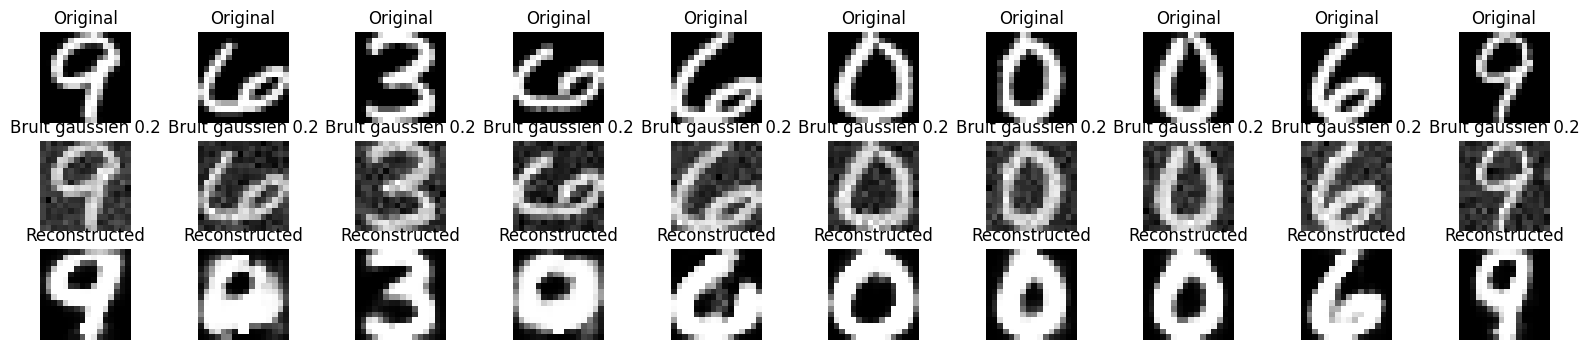

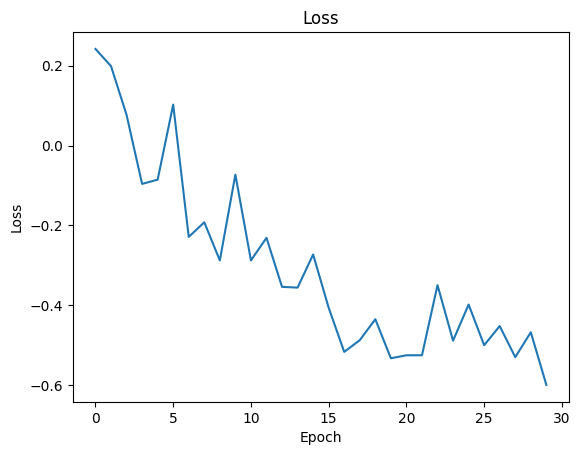

In [144]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.0658


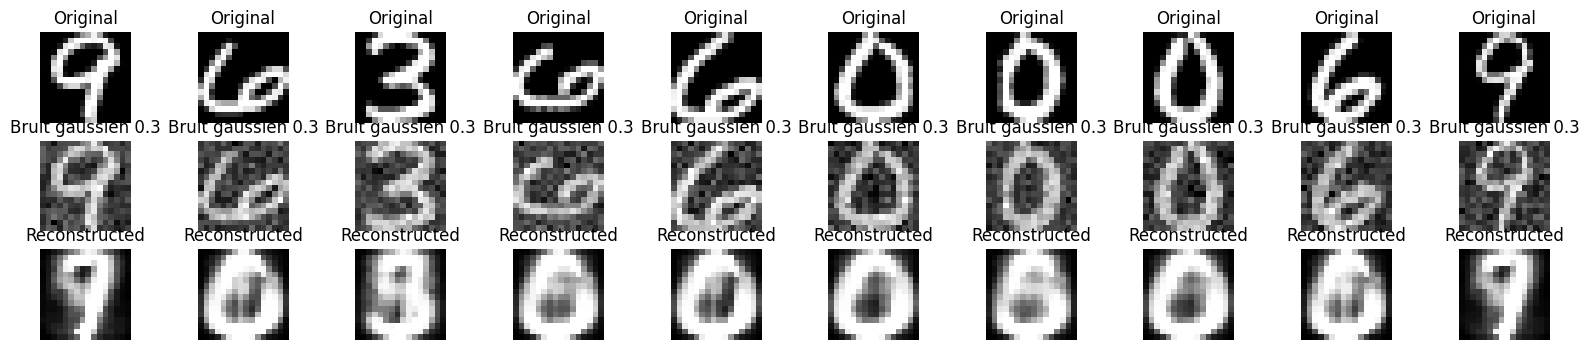

Epoch 2, Loss: -0.4596
Epoch 3, Loss: -0.4661
Epoch 4, Loss: -0.5890
Epoch 5, Loss: -0.5763
Epoch 6, Loss: -0.6413


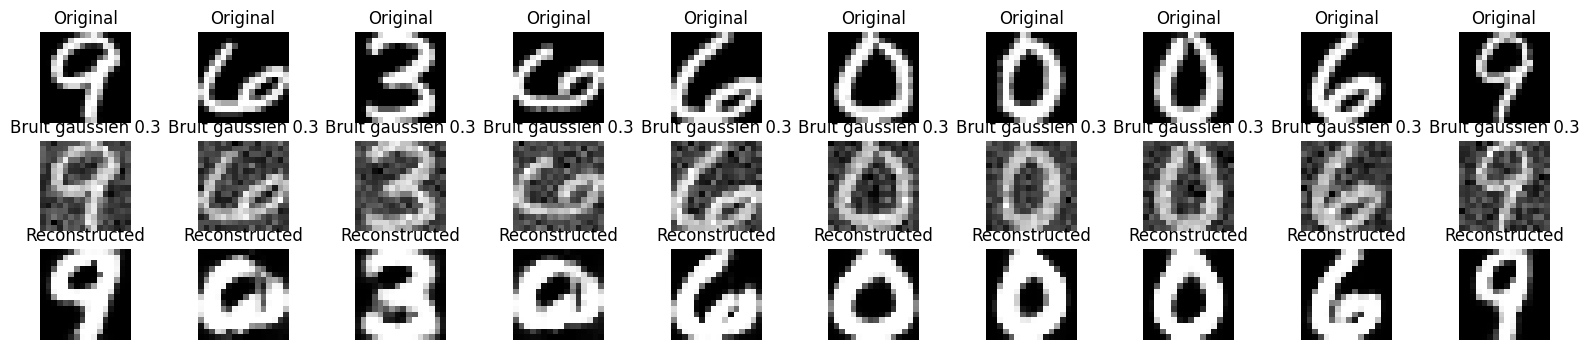

Epoch 7, Loss: -0.7000
Epoch 8, Loss: -0.6269
Epoch 9, Loss: -0.6454
Epoch 10, Loss: -0.6573
Epoch 11, Loss: -0.7048


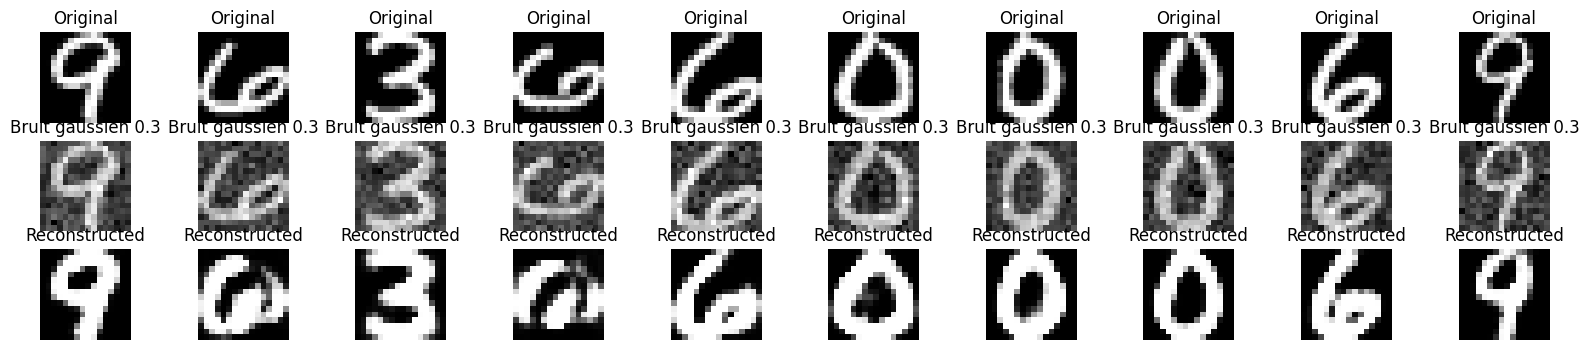

Epoch 12, Loss: -0.7601
Epoch 13, Loss: -0.7673
Epoch 14, Loss: -0.8317
Epoch 15, Loss: -1.0331
Epoch 16, Loss: -0.7446


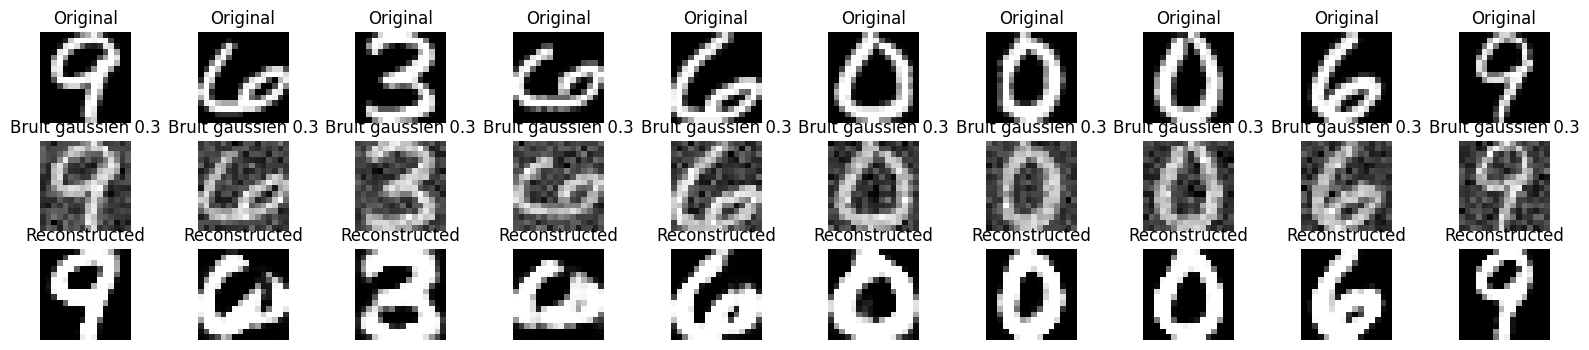

Epoch 17, Loss: -0.9279
Epoch 18, Loss: -0.9079
Epoch 19, Loss: -0.6588
Epoch 20, Loss: -0.7805
Epoch 21, Loss: -1.0565


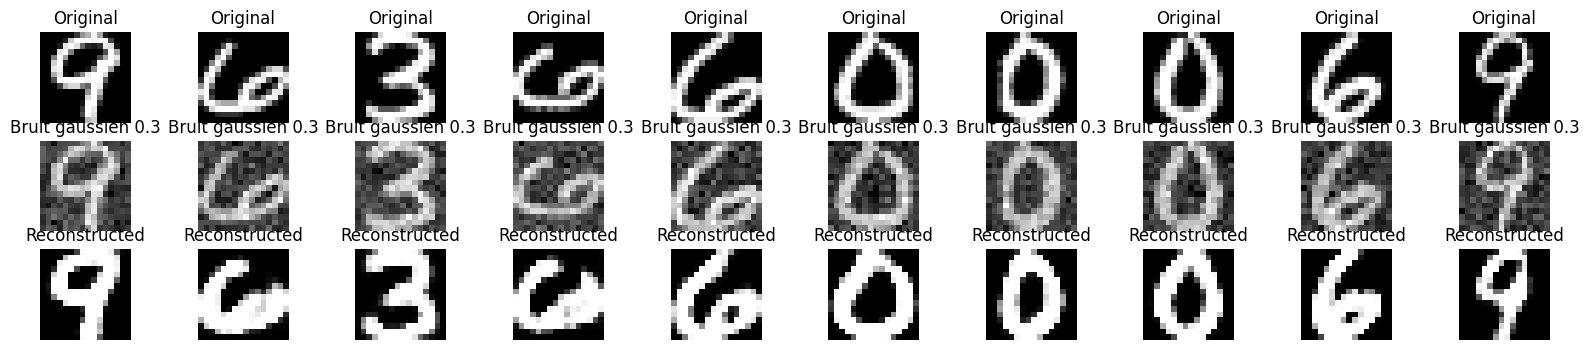

Epoch 22, Loss: -0.8757
Epoch 23, Loss: -0.9534
Epoch 24, Loss: -0.8205
Epoch 25, Loss: -0.8938
Epoch 26, Loss: -0.9046


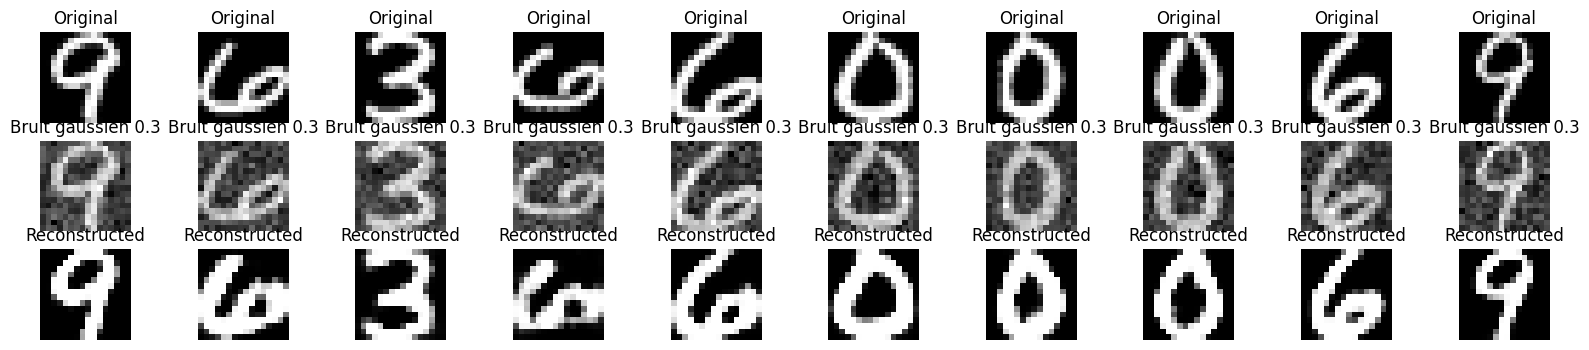

Epoch 27, Loss: -0.7913
Epoch 28, Loss: -0.9022
Epoch 29, Loss: -0.9259
Epoch 30, Loss: -0.8157


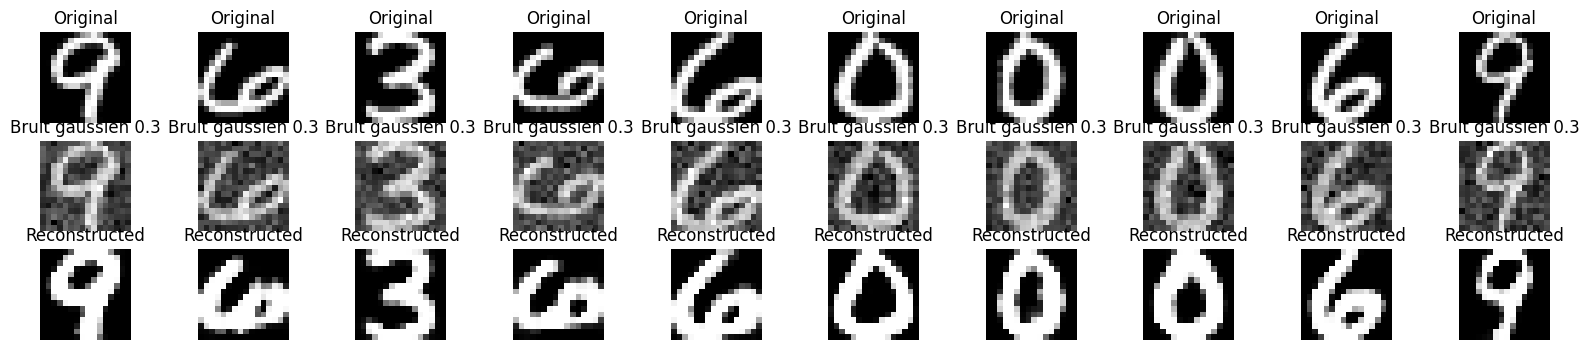

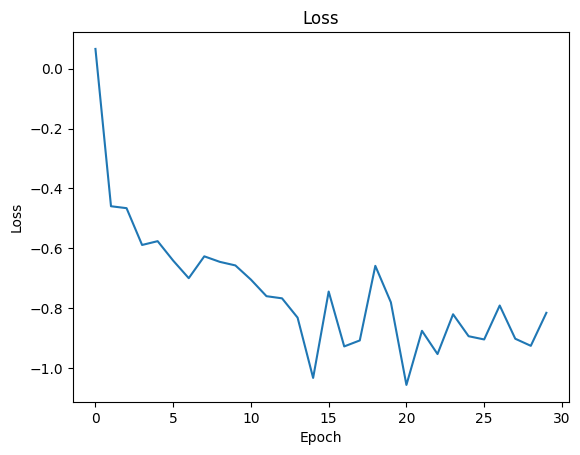

In [225]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.2683


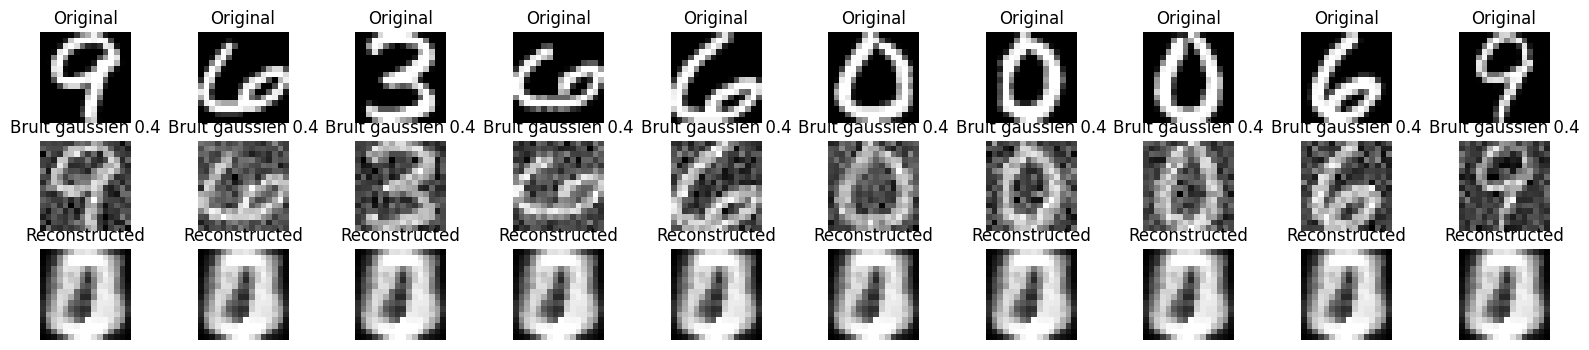

Epoch 2, Loss: -0.1241
Epoch 3, Loss: -0.2953
Epoch 4, Loss: -0.3917
Epoch 5, Loss: -0.4763
Epoch 6, Loss: -0.5744


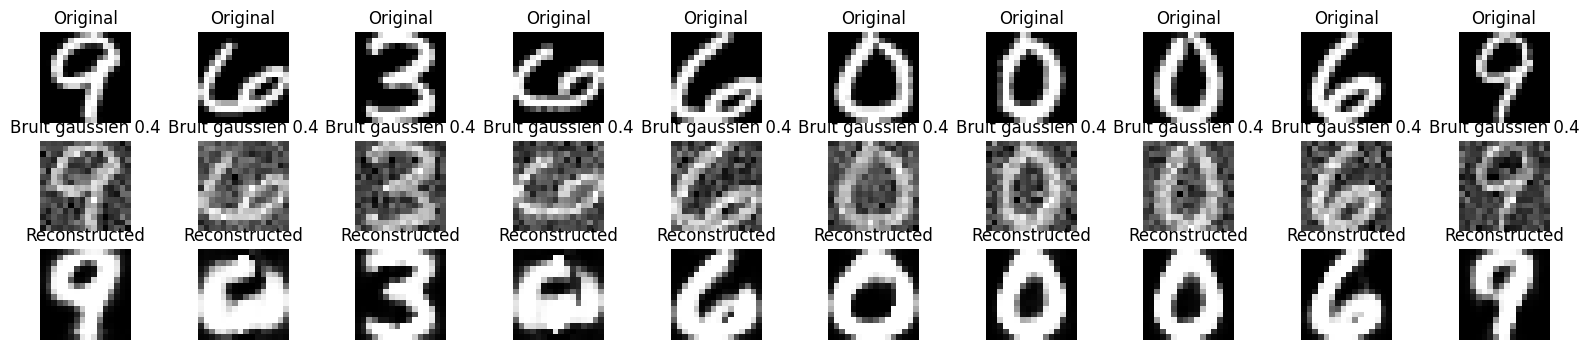

Epoch 7, Loss: -0.6345
Epoch 8, Loss: -0.6213
Epoch 9, Loss: -0.7522
Epoch 10, Loss: -0.6347
Epoch 11, Loss: -0.6670


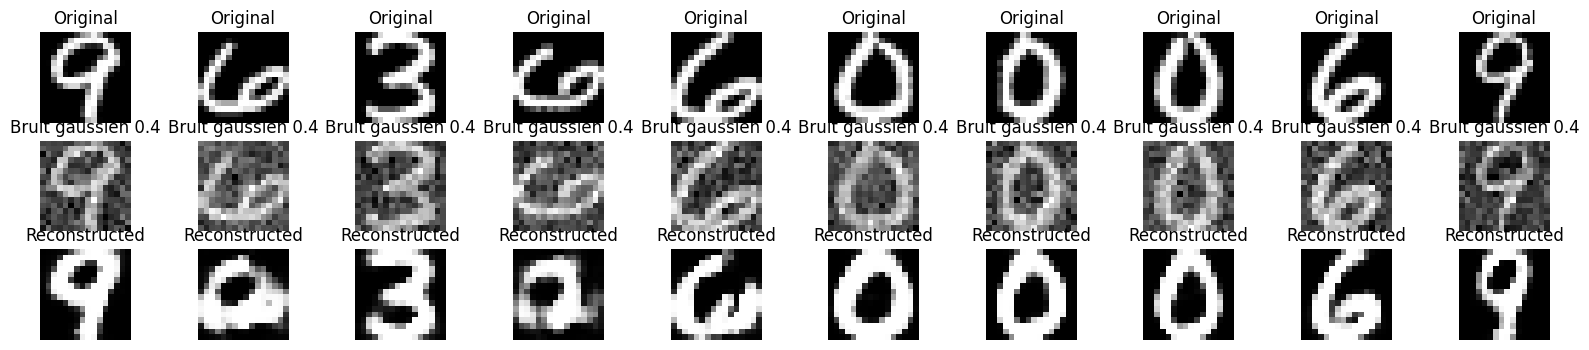

Epoch 12, Loss: -0.6036
Epoch 13, Loss: -0.7489
Epoch 14, Loss: -0.7729
Epoch 15, Loss: -0.8424
Epoch 16, Loss: -0.8674


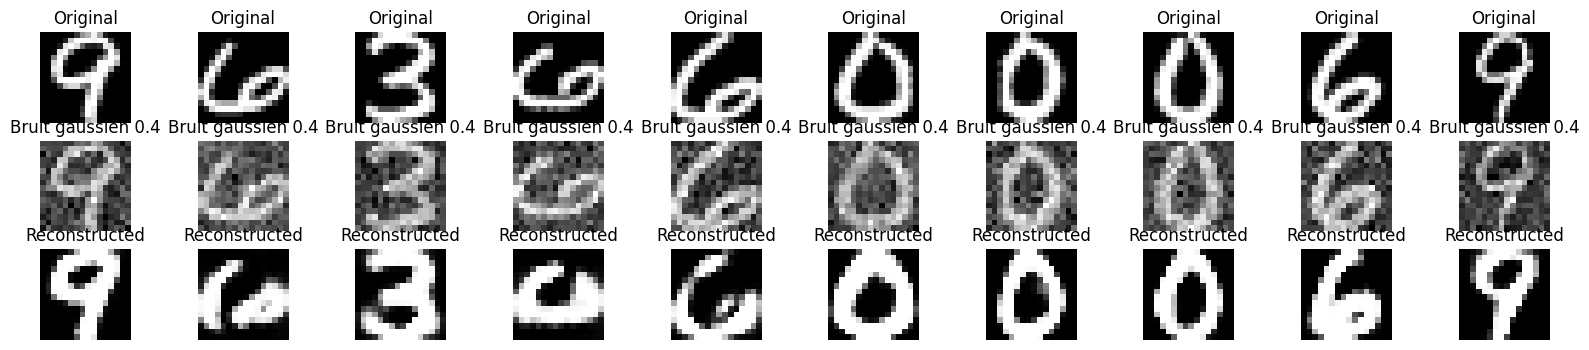

Epoch 17, Loss: -0.6877
Epoch 18, Loss: -0.8883
Epoch 19, Loss: -0.8339
Epoch 20, Loss: -0.7708
Epoch 21, Loss: -0.7980


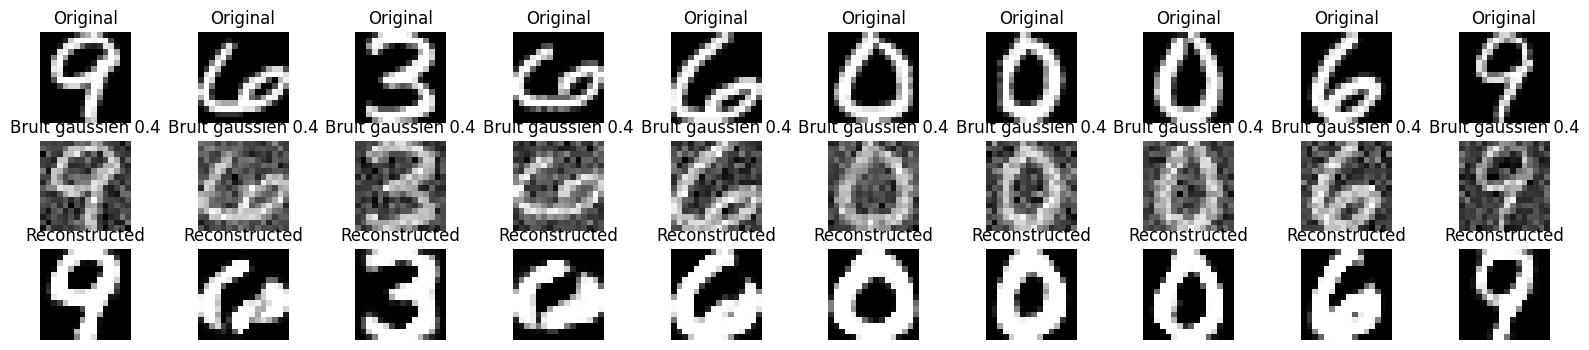

Epoch 22, Loss: -0.8558
Epoch 23, Loss: -0.8887
Epoch 24, Loss: -0.7332
Epoch 25, Loss: -0.7417
Epoch 26, Loss: -0.8226


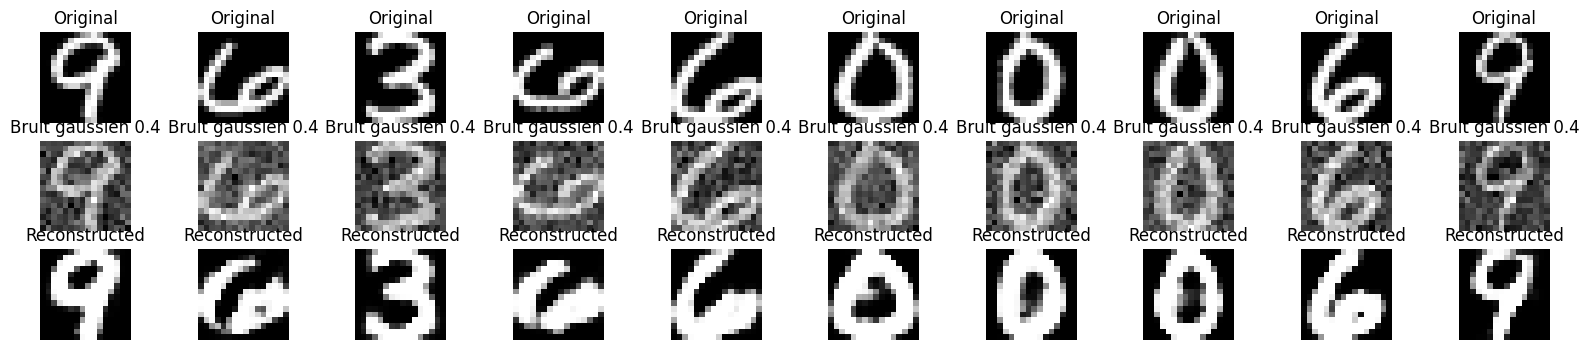

Epoch 27, Loss: -0.9167
Epoch 28, Loss: -0.9277
Epoch 29, Loss: -0.7684
Epoch 30, Loss: -0.7626


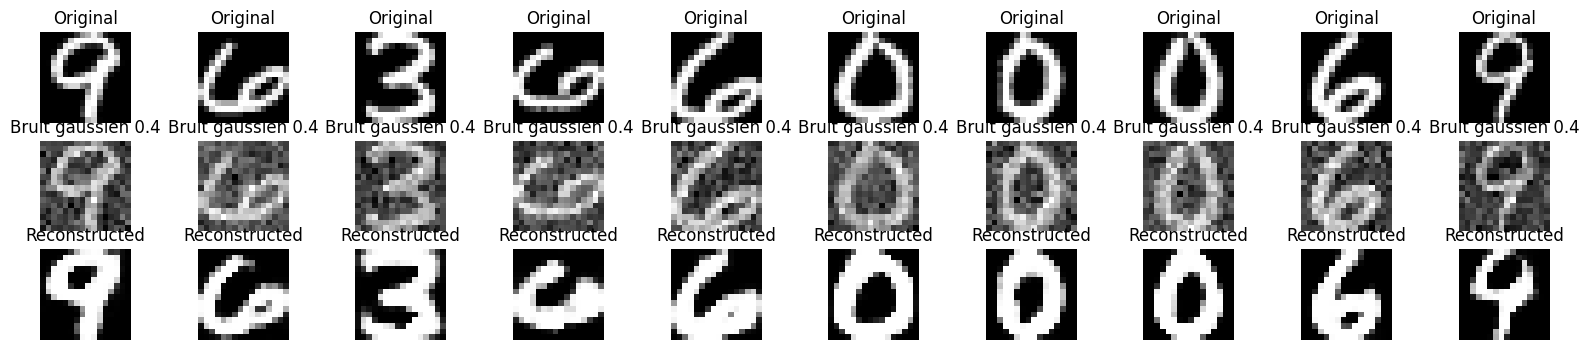

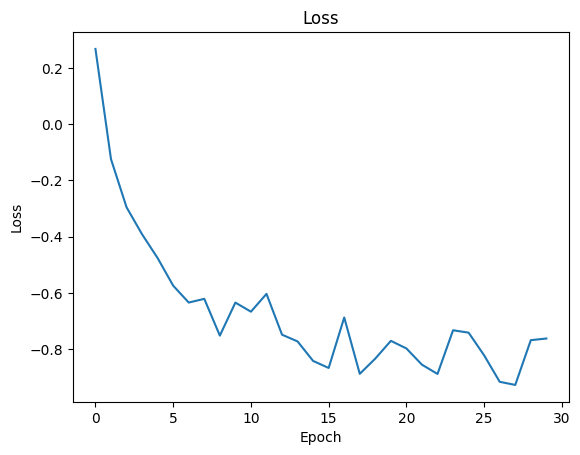

In [229]:
autoencoder = AutoEncoder_simple(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.4334


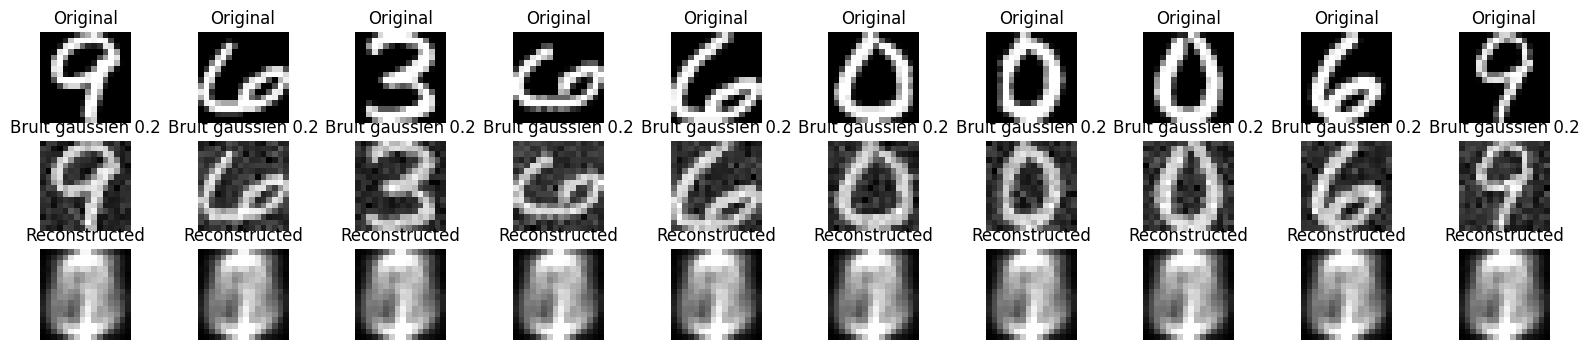

Epoch 2, Loss: 0.4449
Epoch 3, Loss: 0.2937
Epoch 4, Loss: 0.2657
Epoch 5, Loss: 0.3446
Epoch 6, Loss: 0.4390


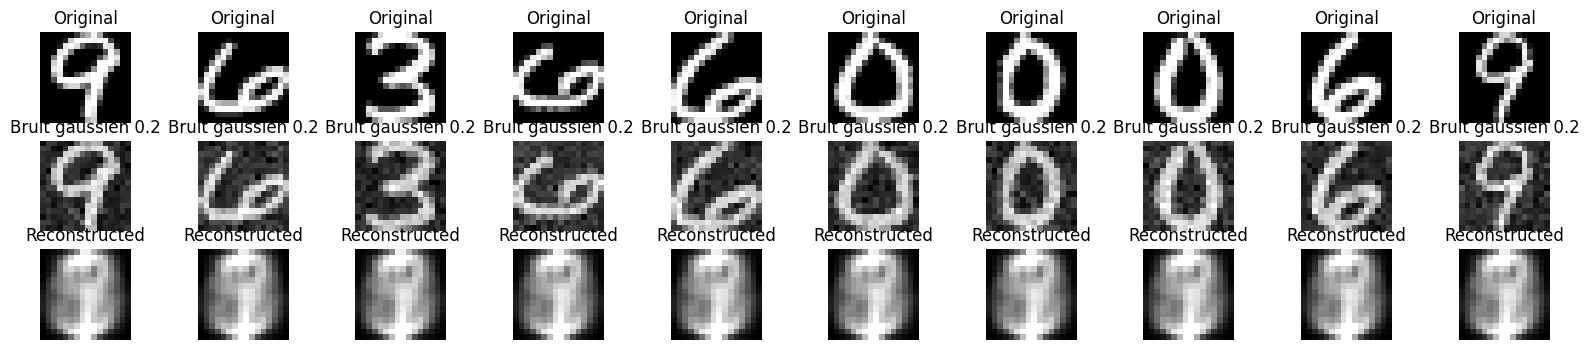

Epoch 7, Loss: 0.3628
Epoch 8, Loss: 0.3719
Epoch 9, Loss: 0.3261
Epoch 10, Loss: 0.4437
Epoch 11, Loss: 0.4214


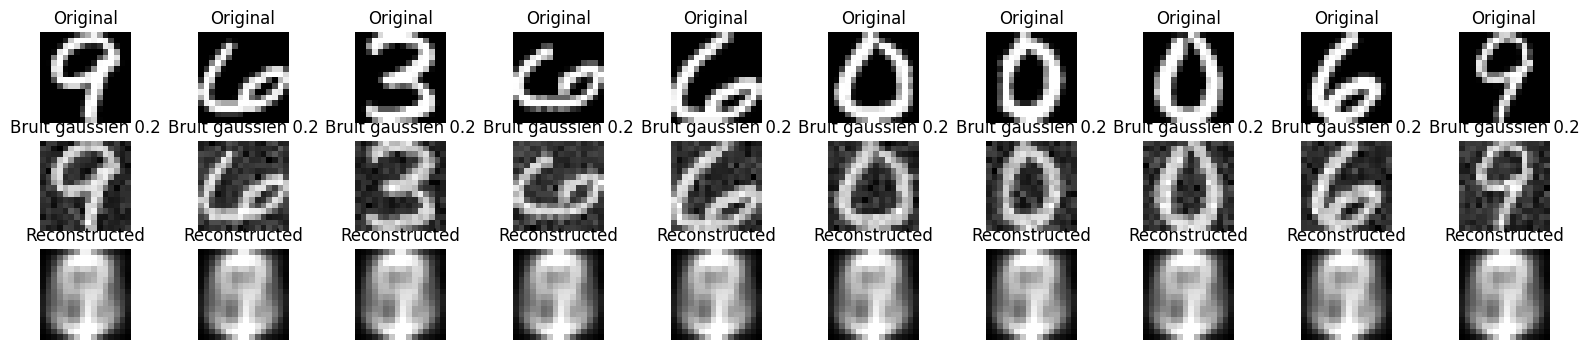

Epoch 12, Loss: 0.3374
Epoch 13, Loss: 0.4723
Epoch 14, Loss: 0.3890
Epoch 15, Loss: 0.1984
Epoch 16, Loss: -0.0923


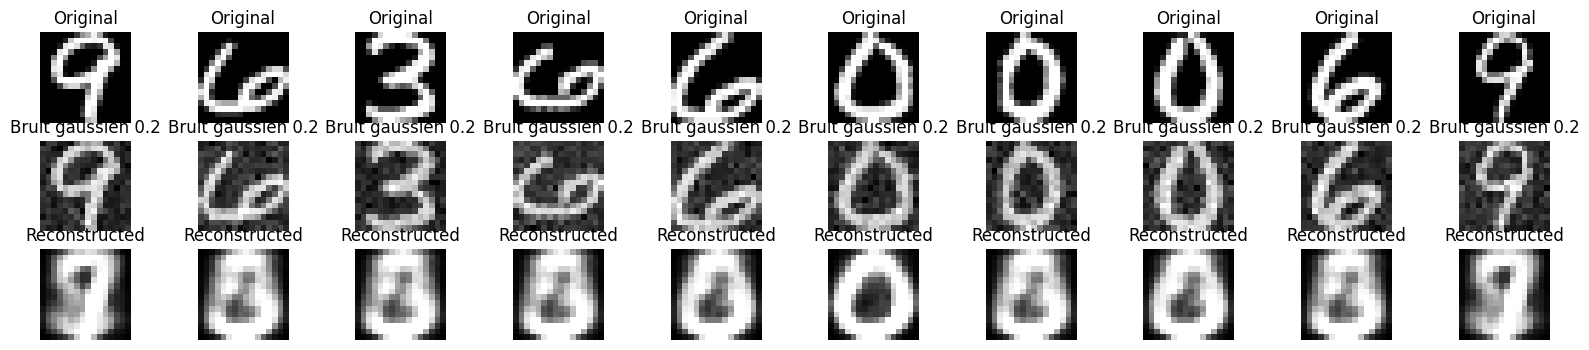

Epoch 17, Loss: -0.0331
Epoch 18, Loss: -0.1099
Epoch 19, Loss: -0.2158
Epoch 20, Loss: -0.3168
Epoch 21, Loss: -0.2787


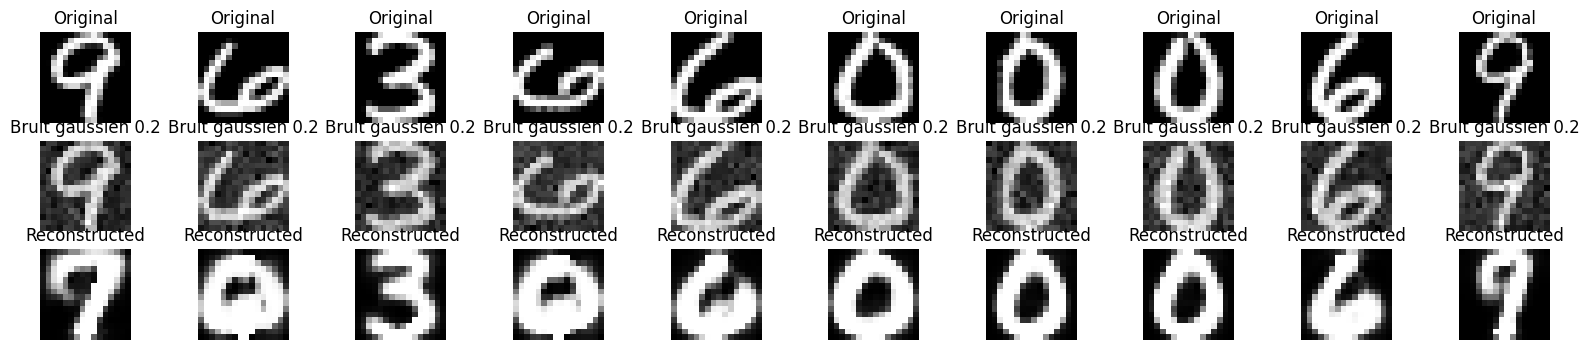

Epoch 22, Loss: -0.3742
Epoch 23, Loss: -0.3679
Epoch 24, Loss: -0.3631
Epoch 25, Loss: -0.4965
Epoch 26, Loss: -0.2844


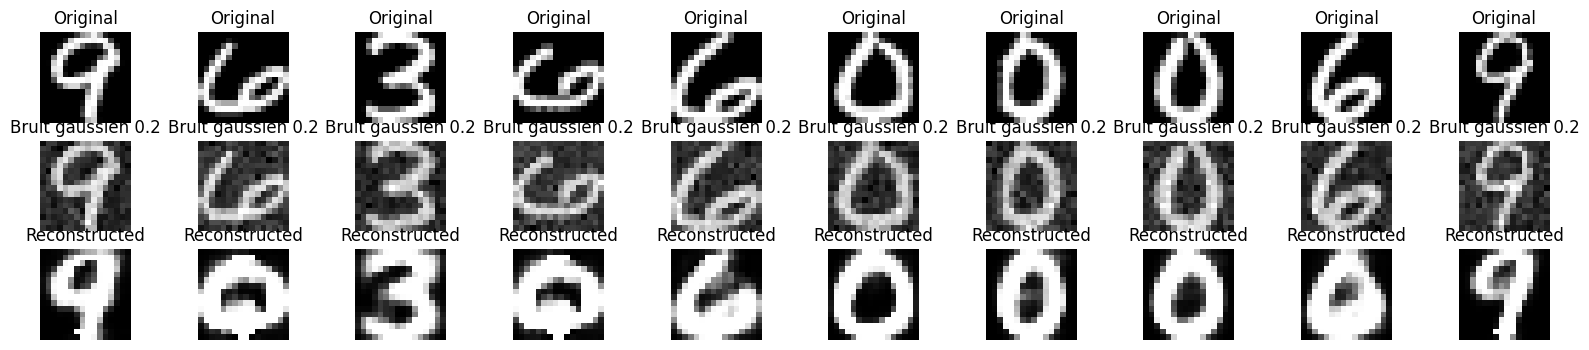

Epoch 27, Loss: -0.2898
Epoch 28, Loss: -0.4887
Epoch 29, Loss: -0.2554
Epoch 30, Loss: -0.4210


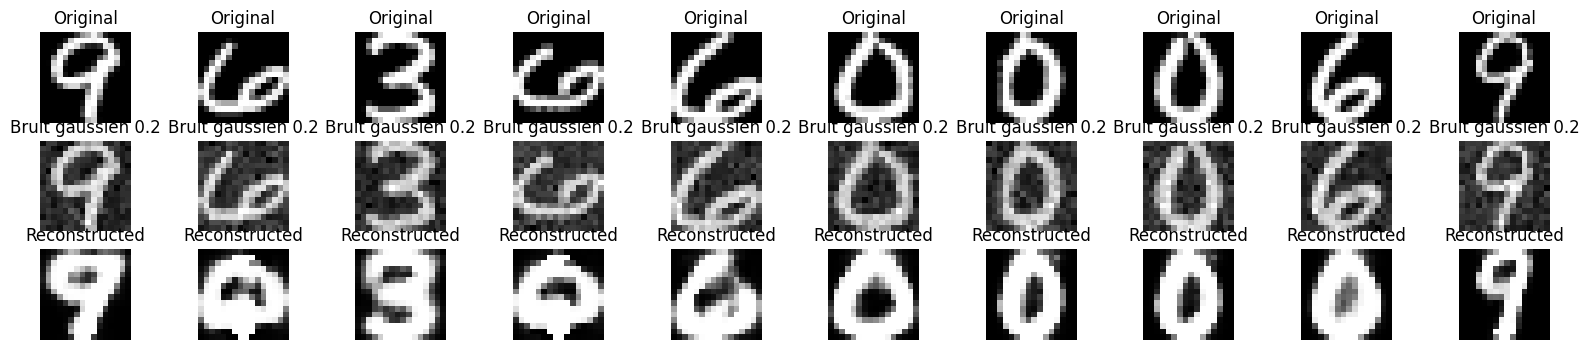

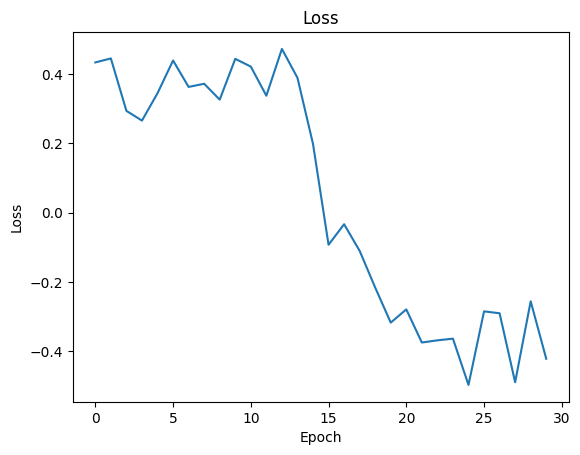

In [143]:
autoencoder = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.3341


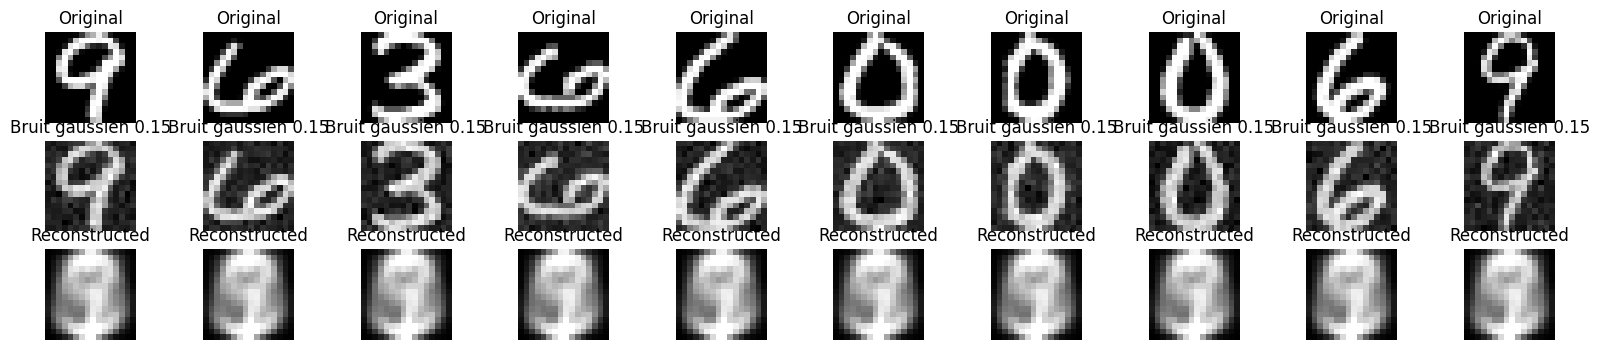

Epoch 2, Loss: 0.4177
Epoch 3, Loss: 0.3474
Epoch 4, Loss: 0.4079
Epoch 5, Loss: 0.0316
Epoch 6, Loss: 0.0555


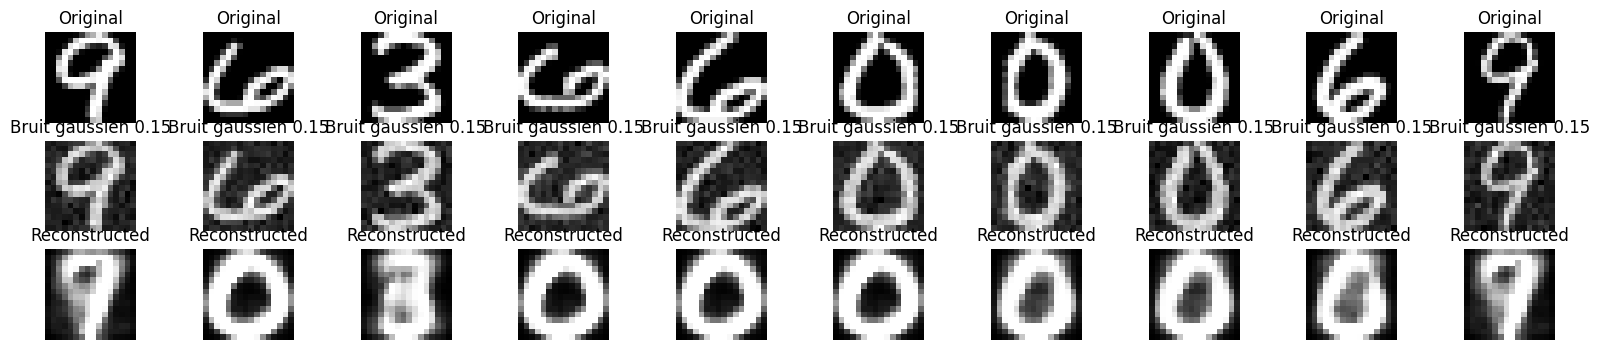

Epoch 7, Loss: -0.3553
Epoch 8, Loss: -0.6008
Epoch 9, Loss: -0.5630
Epoch 10, Loss: -0.6341
Epoch 11, Loss: -0.4937


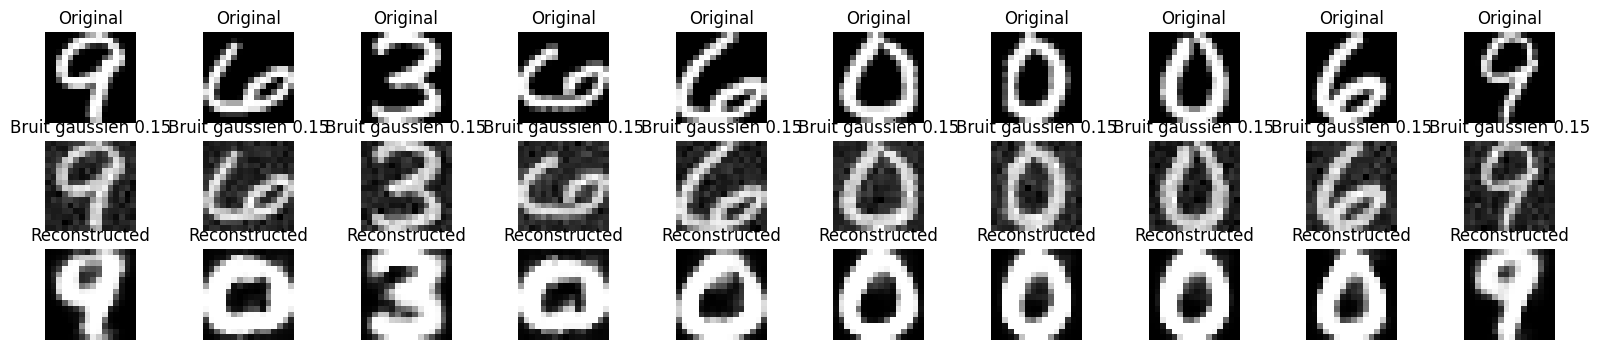

Epoch 12, Loss: -0.6261
Epoch 13, Loss: -0.5262
Epoch 14, Loss: -0.3450
Epoch 15, Loss: -0.4532
Epoch 16, Loss: -0.6191


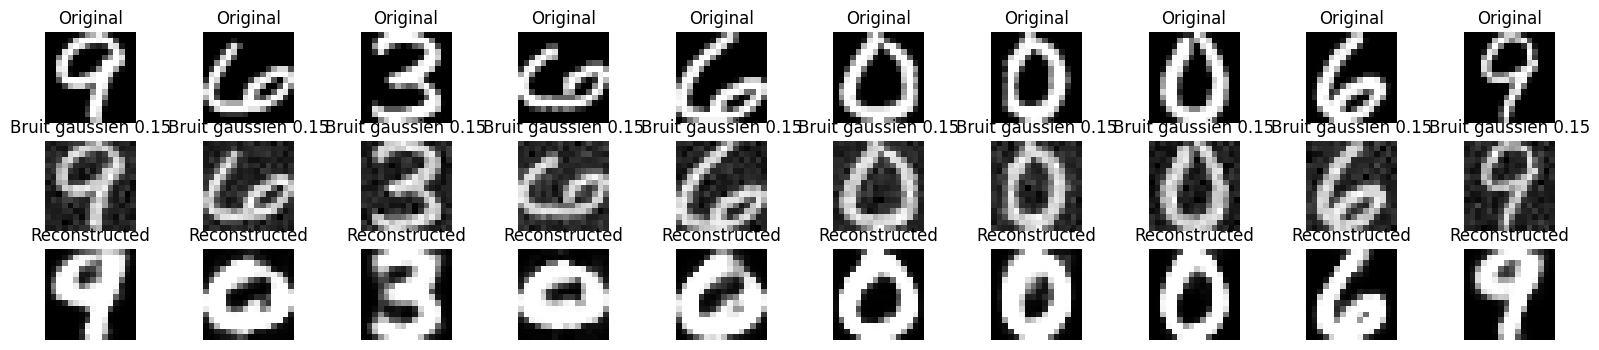

Epoch 17, Loss: -0.7355
Epoch 18, Loss: -0.5602
Epoch 19, Loss: -0.5226
Epoch 20, Loss: -0.5285
Epoch 21, Loss: -0.6557


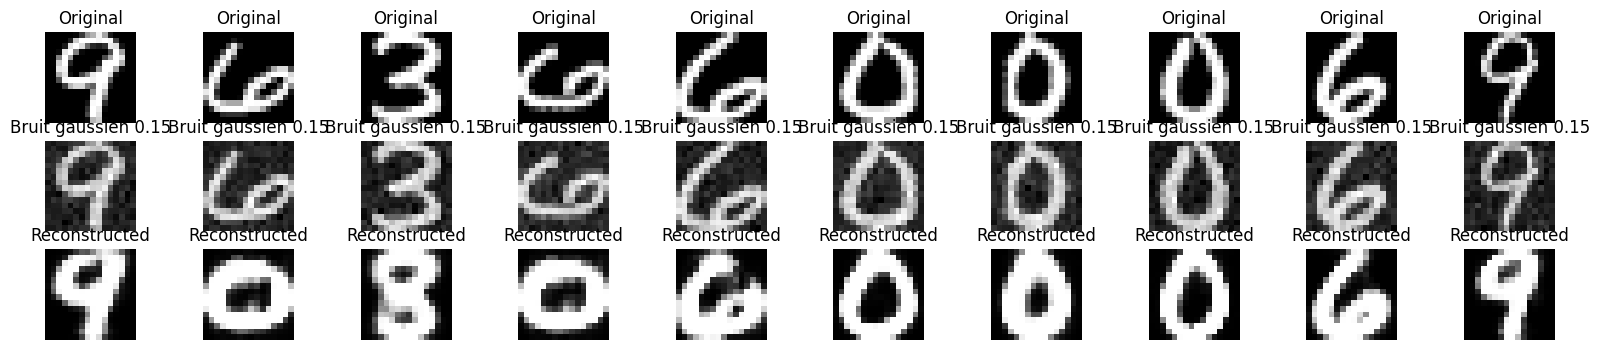

Epoch 22, Loss: -0.4946
Epoch 23, Loss: -0.7594
Epoch 24, Loss: -0.4260
Epoch 25, Loss: -0.7630
Epoch 26, Loss: -0.3759


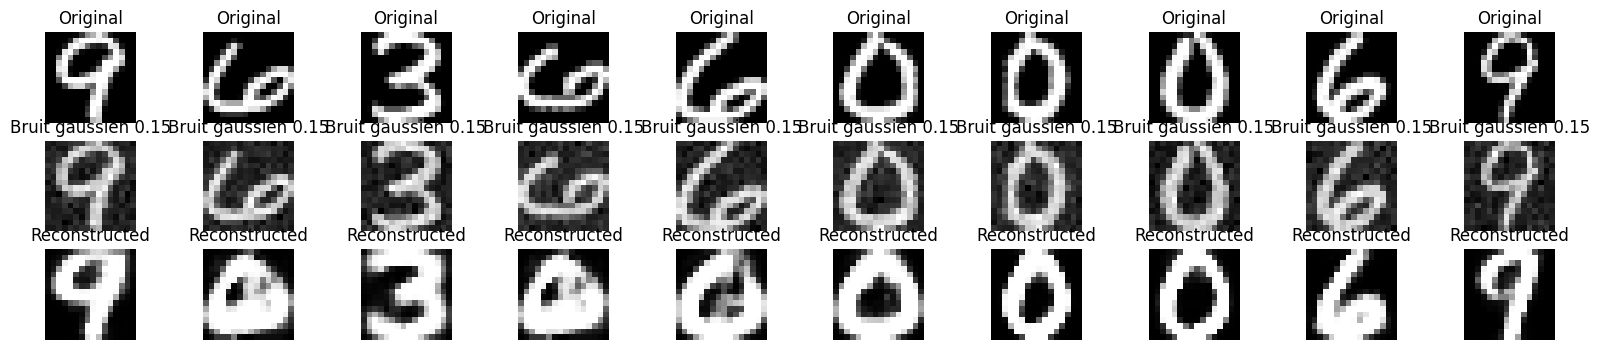

Epoch 27, Loss: -0.4016
Epoch 28, Loss: -0.3931
Epoch 29, Loss: -0.6611
Epoch 30, Loss: -0.3743


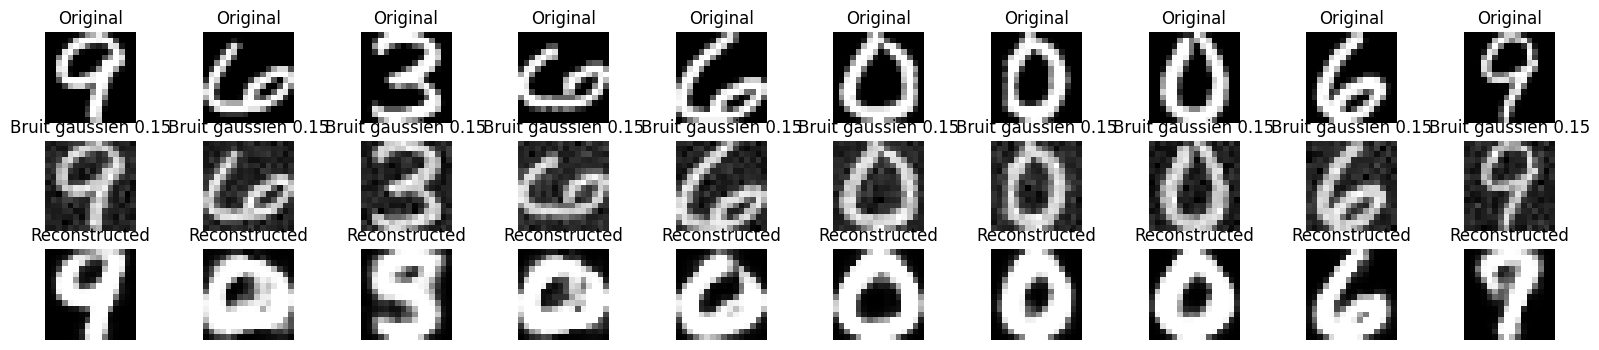

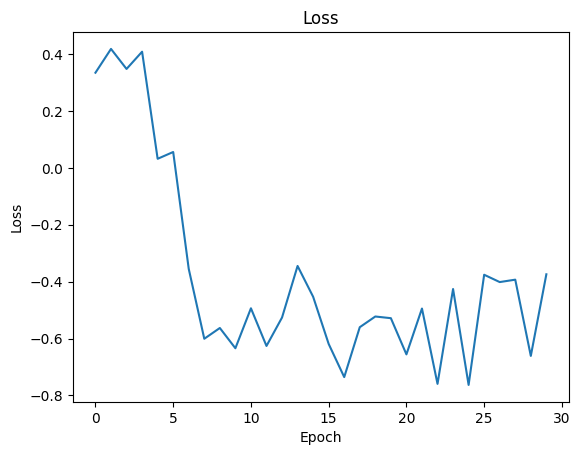

In [141]:
autoencoder = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=32, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.3920


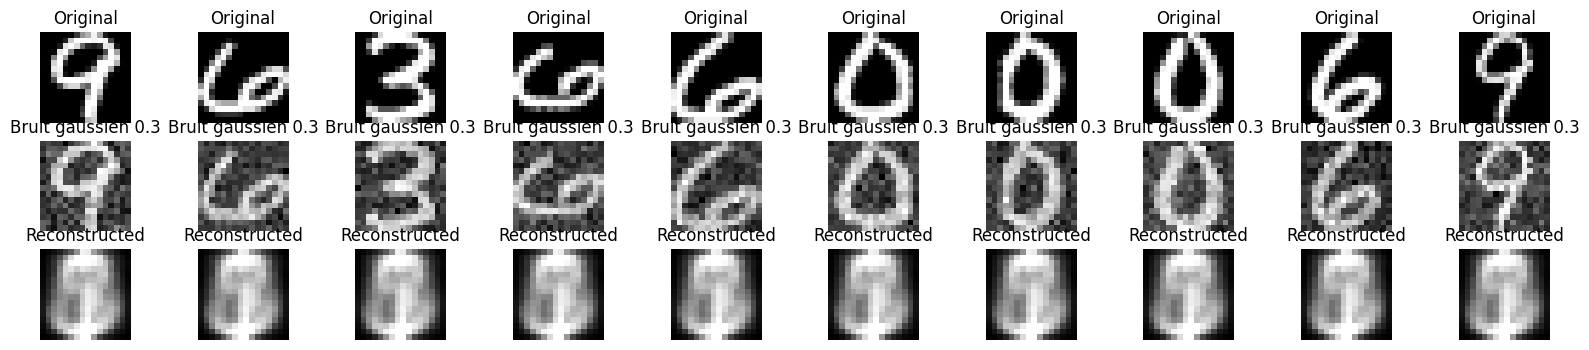

Epoch 2, Loss: 0.3400
Epoch 3, Loss: 0.3044
Epoch 4, Loss: 0.3483
Epoch 5, Loss: 0.3624
Epoch 6, Loss: 0.3963


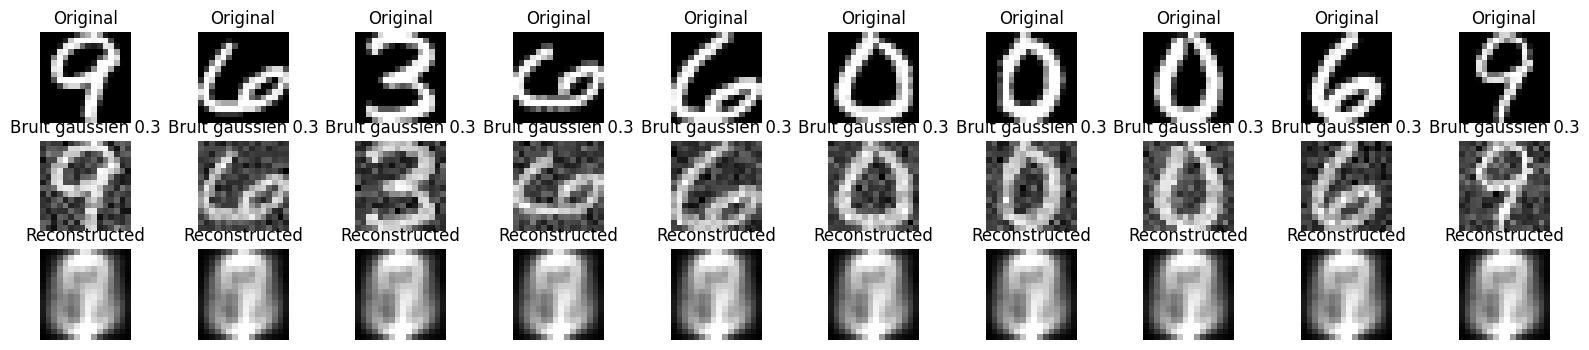

Epoch 7, Loss: 0.2943
Epoch 8, Loss: 0.3439
Epoch 9, Loss: 0.3642
Epoch 10, Loss: 0.2985
Epoch 11, Loss: 0.3685


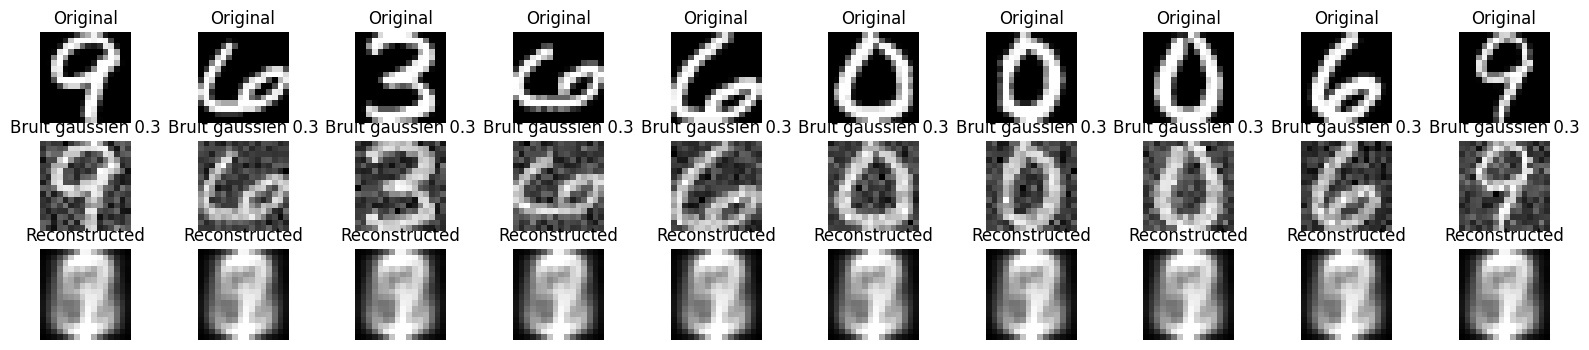

Epoch 12, Loss: 0.3553
Epoch 13, Loss: 0.3506
Epoch 14, Loss: 0.3213
Epoch 15, Loss: 0.3458
Epoch 16, Loss: 0.2739


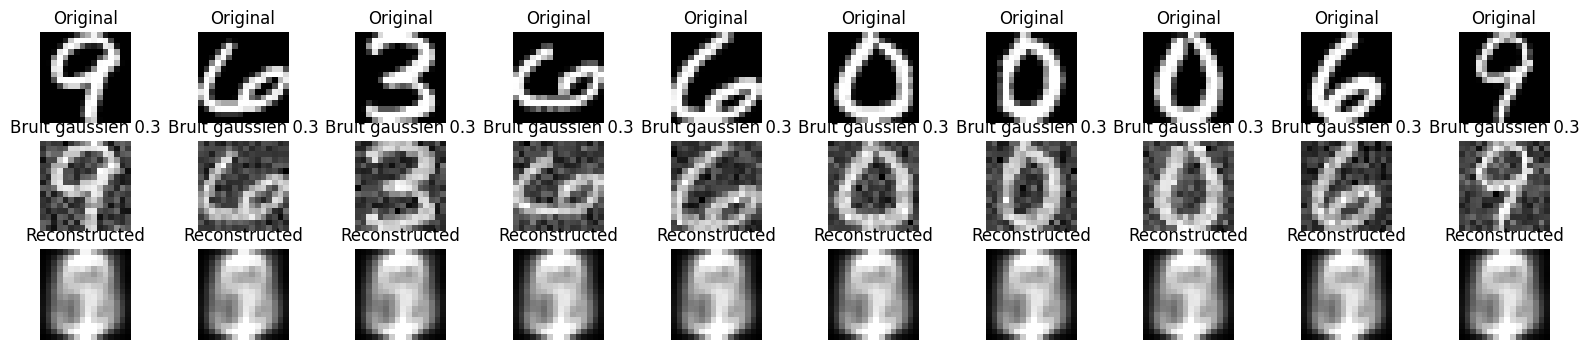

Epoch 17, Loss: 0.1844
Epoch 18, Loss: -0.0801
Epoch 19, Loss: -0.3364
Epoch 20, Loss: -0.3997
Epoch 21, Loss: -0.3333


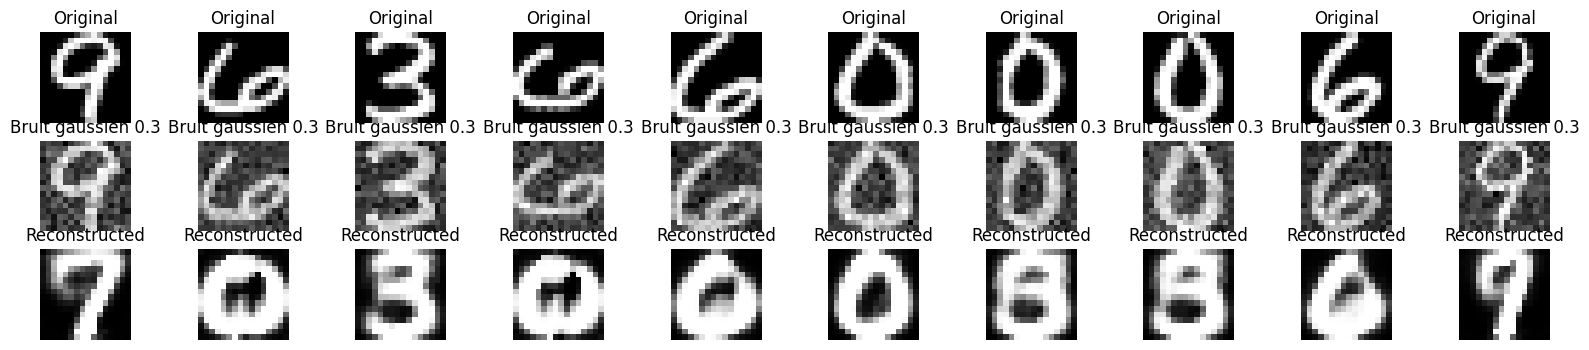

Epoch 22, Loss: -0.3341
Epoch 23, Loss: -0.2623
Epoch 24, Loss: -0.2415
Epoch 25, Loss: -0.4260
Epoch 26, Loss: -0.3238


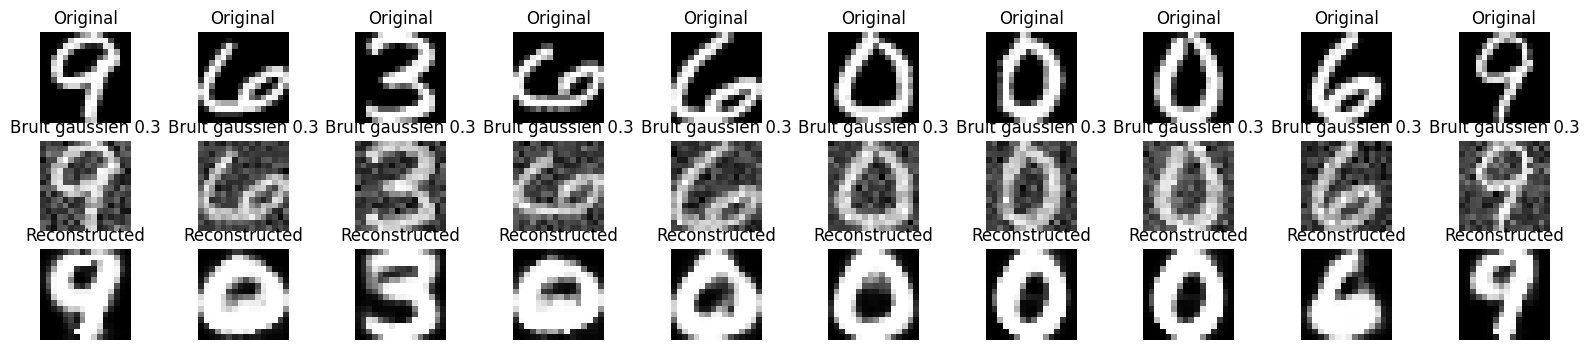

Epoch 27, Loss: -0.4253
Epoch 28, Loss: -0.4861
Epoch 29, Loss: -0.5288
Epoch 30, Loss: -0.4407


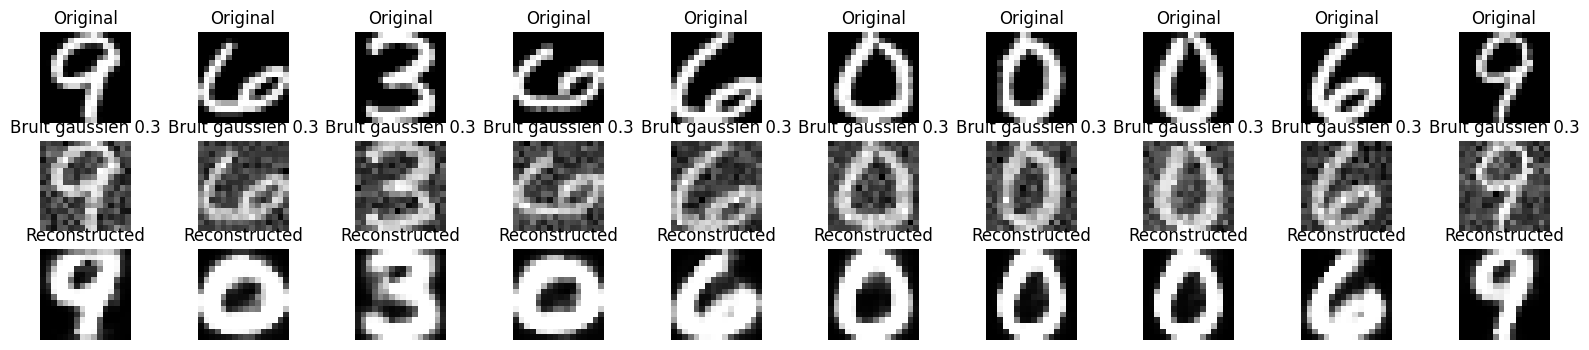

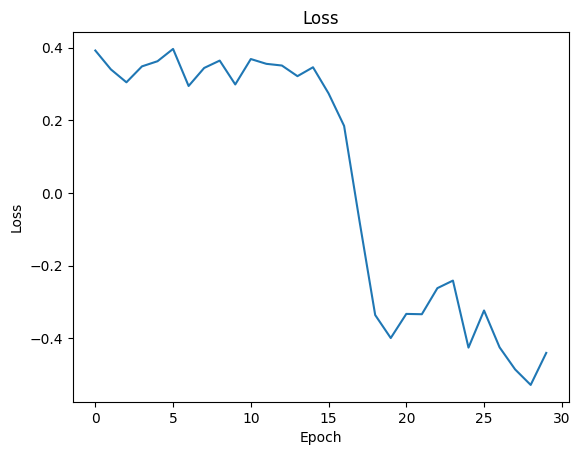

In [226]:
autoencoder = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=64, epochs=30, plot=True, bruit=True)

Epoch 1, Loss: 0.3244


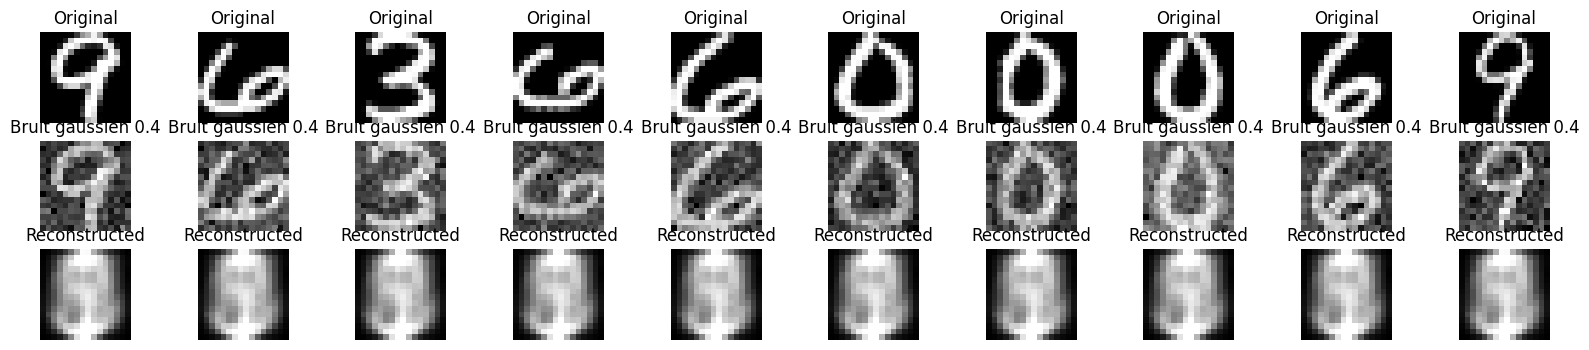

Epoch 2, Loss: 0.4442
Epoch 3, Loss: 0.2813
Epoch 4, Loss: 0.4793
Epoch 5, Loss: 0.3431
Epoch 6, Loss: 0.1298


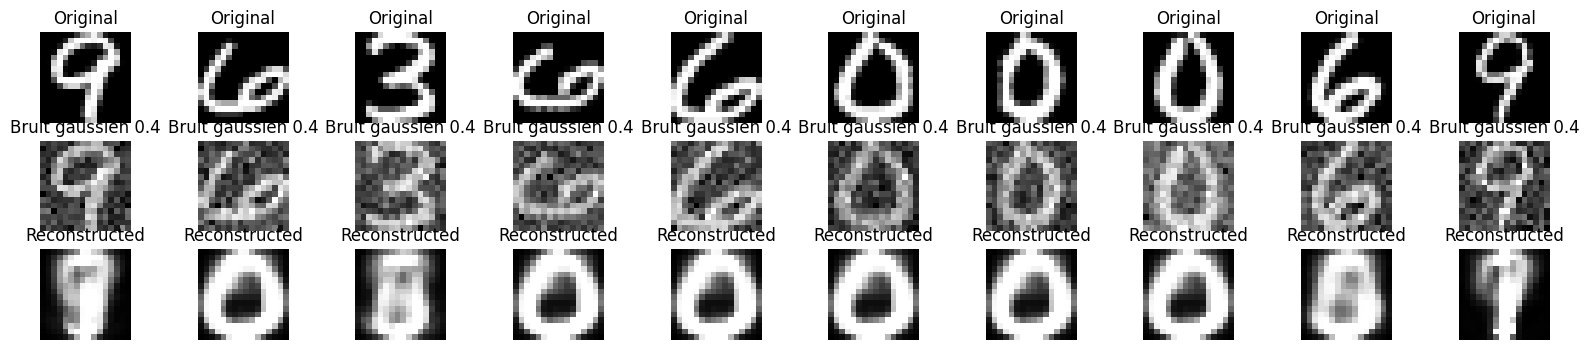

Epoch 7, Loss: 0.0384
Epoch 8, Loss: -0.1717
Epoch 9, Loss: -0.3467
Epoch 10, Loss: -0.4237
Epoch 11, Loss: -0.4534


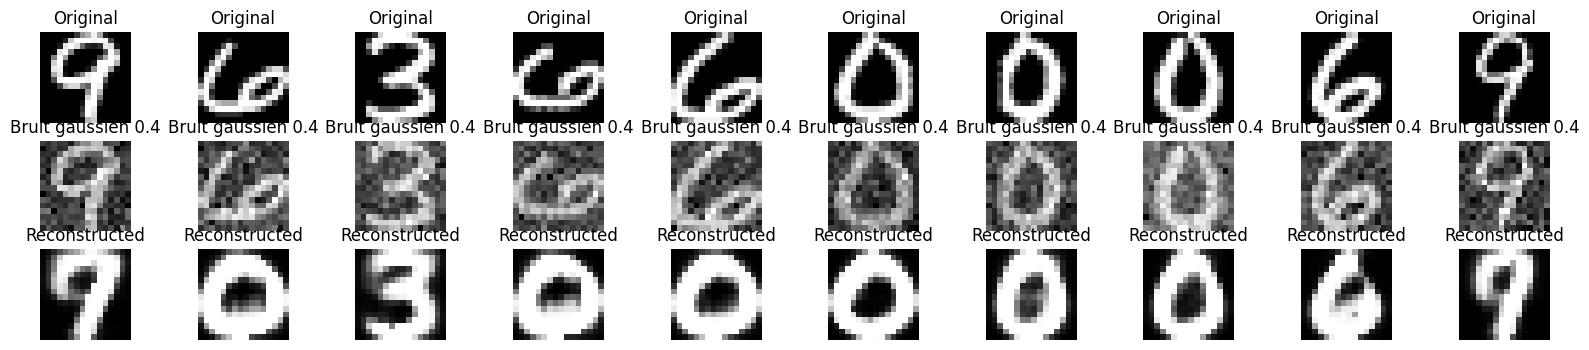

Epoch 12, Loss: -0.5628
Epoch 13, Loss: -0.7415
Epoch 14, Loss: -0.3486
Epoch 15, Loss: -0.6278
Epoch 16, Loss: -0.7605


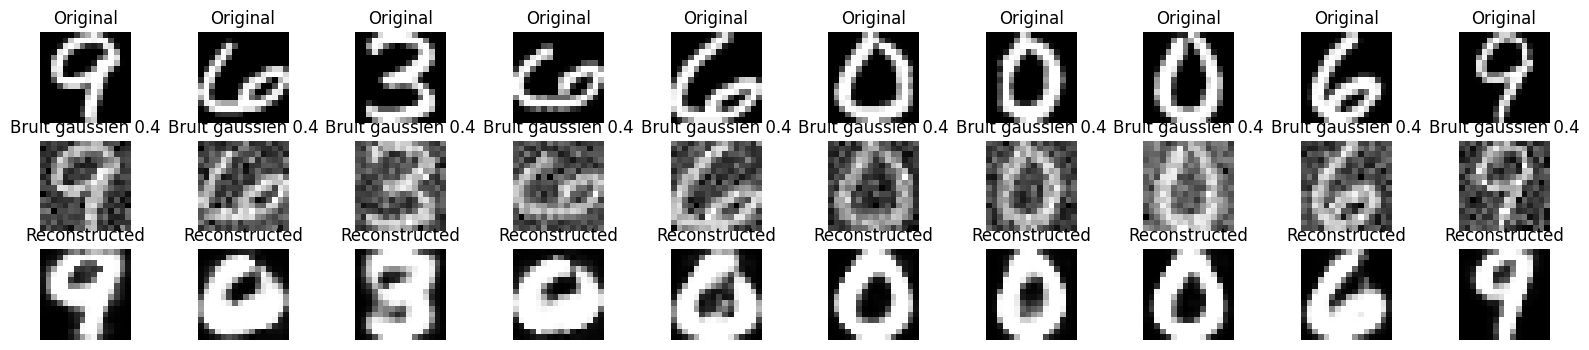

Epoch 17, Loss: -0.4628
Epoch 18, Loss: -0.4414
Epoch 19, Loss: -0.5252
Epoch 20, Loss: -0.6124
Epoch 21, Loss: -0.5786


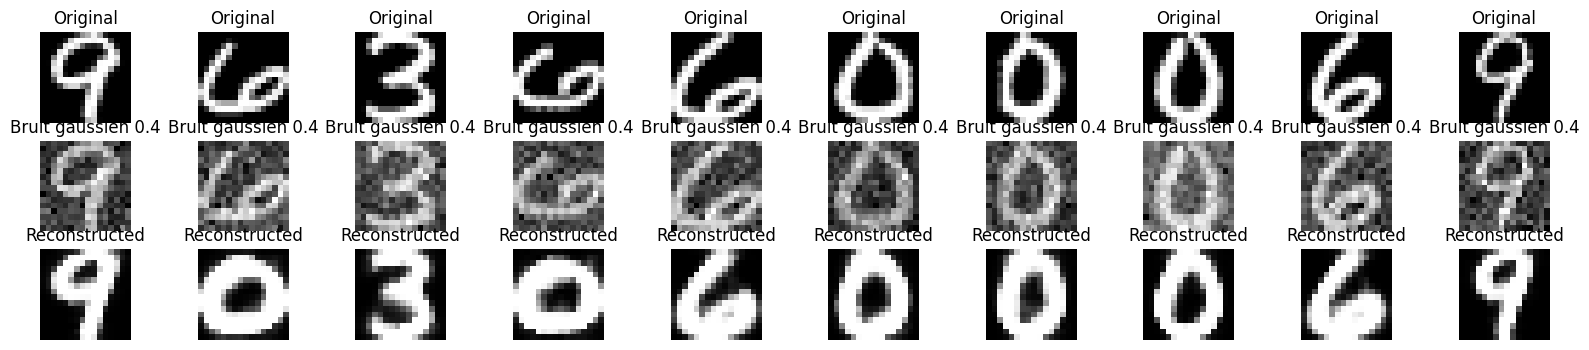

Epoch 22, Loss: -0.5014
Epoch 23, Loss: -0.3616
Epoch 24, Loss: -0.6929
Epoch 25, Loss: -0.2453
Epoch 26, Loss: -0.6273


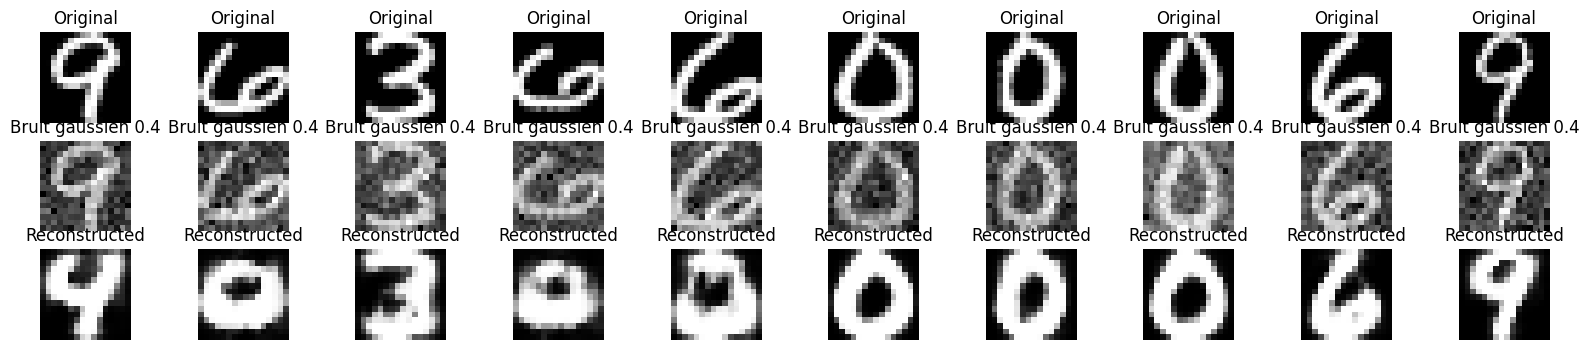

Epoch 27, Loss: -0.4981
Epoch 28, Loss: -0.6388
Epoch 29, Loss: -0.1262
Epoch 30, Loss: -0.4388


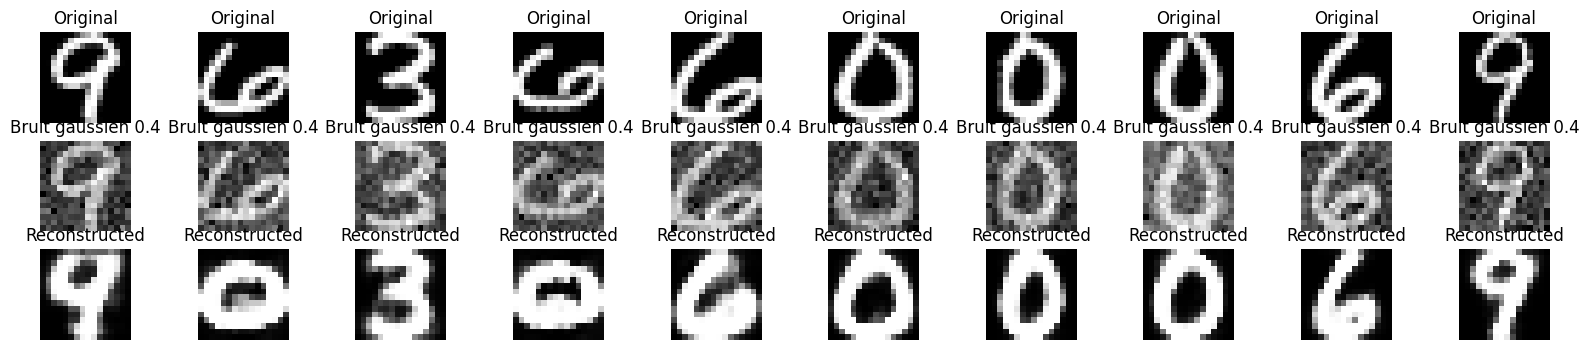

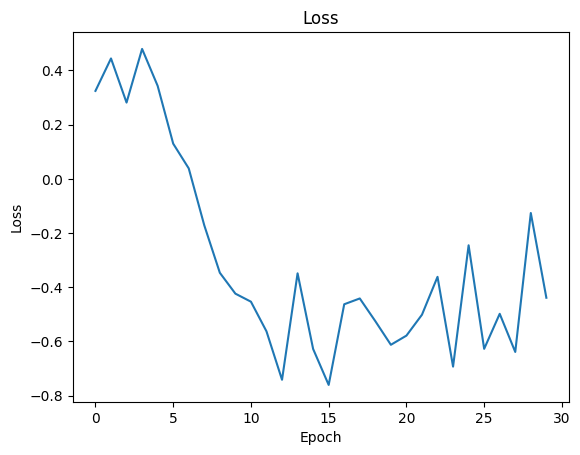

In [230]:
autoencoder = AutoEncoder_complex2(DIM_IN=256, fc_act=TanH())
full_autoencoder = Sequential(
                *autoencoder.encoder.modules,
                *autoencoder.decoder.modules
            )
optimizer = Optim(full_autoencoder, BCELoss(), 1e-3)

train_visualize_Usps(autoencoder, optimizer, alltrainx, batch_size=32, epochs=30, plot=True, bruit=True)